# No Preprocessing: Cats vs Dogs: VGG19

Using the Intel Images dataset, we will read the data files into memory as-is. The only processing that will be performed is reshaping the dataset into squares, since the neural network structure used requires the inputs to be of fixed dimensions. We will feed the dataset into a customly defined Convolutional Neural Network model, which will be trained for 25 epochs. This is intended to act as a baseline for this model/dataset, showing how the network performs without any regularization schemes. 

## Imports

Before we begin, we need to import the necessary python packages and appropriately configure the tensorflow gpu enviornment for use with the correct GPU on this system (RTX 2070 in GPU slot 0). 

* **`numpy`:** used for matrix operations, storing the pixel data of the images while working
* **`pandas`:** used for tabular organization of the results for storing in a formatted csv style for later evaluation in another notebook
* **`matplotlib.pyplot`:** used for data visualization for the model performance after training
* **`cv2`:** OpenCV for python, used for reading and manipulating the image files from the dataset before storing in working memory.
* **`os`:** used for streamlined access of the filesystem for determining the paths to each of the data files
* **`tensorflow.keras`:** used for model creation, compiling, and training. The GPU variant of tensorflow was used; this program has not been tested for systems without access to the GPU acclerations. 
* **`sklearn.utils.shuffle`:** used for an efficient shuffling of the X and y datasets together. 
* **`timeit.default_timer`:** used for timing the overhead and training runtime performance of the model when no preprocessing is performed

In [1]:
# === Imports === #
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import kerastuner        as kt
import cv2
import os
from tensorflow    import keras
from sklearn.utils import shuffle
from timeit        import default_timer


# === Extra Configurations for the GPU Environment === #
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# === Total Times Log === #
times = list( )

## Determine Train/Test Data Files

First, we need to determine the files which are to be used for training and validation. In order to do this, we will use our knowledge of the filesystem structure for the project, as well as the os listdir function to produce two lists: one of the filepaths used for the training data, and one of the filepaths used for the validation data. Finally, the first ten items of each list are printed to verify the success of the file list creation. 

In [2]:
# === Setup Variables === #
data_root_dir   = 'Dataset/Dog_vs_Cat/'
data_classes    = os.listdir( data_root_dir + 'training_set/' )
training_subdir = 'training_set/'
testing_subdir  = 'test_set/'
training_files  = [ ]
testing_files   = [ ]


# === For Each Class, Add Files to Appropriate List === #
for data_class in data_classes:
    for f in os.listdir( data_root_dir + training_subdir + data_class + '/' ):
        training_files.append( data_root_dir + training_subdir + data_class + '/' + f )
    for f in os.listdir( data_root_dir + testing_subdir + data_class + '/' ):
        testing_files.append( data_root_dir + testing_subdir + data_class + '/' + f )

    
# === Show First 10 of Each to Prove Success === #
print( 'Training Set:\n{}'.format( training_files[:10] ) )
print( '\nTesting Set: \n{}'.format( testing_files[:10] ) )

Training Set:
['Dataset/Dog_vs_Cat/training_set/cats/cat.1.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.10.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.100.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.1000.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.1001.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.1002.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.1003.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.1004.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.1005.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.1006.jpg']

Testing Set: 
['Dataset/Dog_vs_Cat/test_set/cats/cat.4001.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4002.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4003.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4004.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4005.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4006.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4007.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4008.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4009.jpg', 'Dat

## Get Image Data & Label from File Names

Using our two file lists, we need to read the image data into working memory for the model to use in the training process. Since our model requires all training and validation data to be of the same shape, reshaping the image as its read will be the only transformation performed on the data. Analyzing the dataset showed that the average training image shape was `(360,400)`. In order to maintain the integrity of the experiment, all images were manually reshaped to be a square of this larger dimension `(400,400)`. We keep the read images as 8-bit integers, without regularization, and we keep the RGB color scheme of the images. 

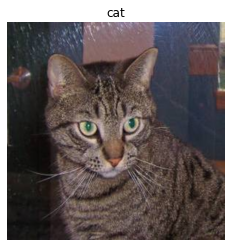

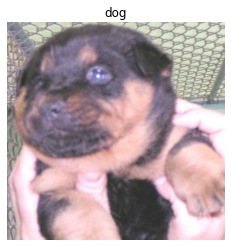

In [3]:
# ================================================================================
# FUNCTION: files_to_Xy( file_list , desired_shape )
# ================================================================================
# 
# Input: 
#   - file_list: list of filepaths to be read (as generated in the previous cell)
#   - desired_shape (optional): dimensions to transform the image data into
#        * default = (400,400,3): a 400x400 RGB image
#
# Output:
#   - Numpy array of shape (n,h,w,c) containing every image present in the list
#        * n = number of images listed to be read
#        * h = first dimension of desired_shape: height of image 
#        * w = second dimension of desired_shape: width of image
#        * c = third dimension of desired_shape: number of channels in the image (RGB=3)
#
# Task:
#   1. Iterate over the file list
#   2. Parse the y label for the image out of the file path
#   3. Use OpenCV (cv2) to read the image data and reshape appropriately
#   4. store the image data/label into numpy arrays of the desired shape
#   5. return the populated X and y after finished iterating
#
# ================================================================================
def files_to_Xy( file_list , desired_shape=(400,400,3) ):
    
    # === Setup Variables === #
    X = np.empty( (len( file_list ), desired_shape[0], desired_shape[1], desired_shape[2] ) , dtype=np.uint8 )
    y = np.empty( len( file_list ) , dtype=object )
    
    # === Iterate Files === #
    for i in range( len( file_list ) ):
        y[i] = file_list[i][ file_list[i].rfind('/')+1:file_list[i].index( '.' ) ]  # either "dog" or "cat"
        X[i] = cv2.cvtColor( 
                    cv2.resize( 
                        cv2.imread( file_list[i] , cv2.IMREAD_UNCHANGED ), 
                        ( desired_shape[0] , desired_shape[1] ) 
                    ), 
                    cv2.COLOR_BGR2RGB )  # read as rgb instead of bgr
        
    # === Return Results === #
    return X , y



# ================================================================================
# FUNCTION: show_image( X , y , idx )
# ================================================================================
#
# Input:
#   - X: numpy array containing the image data
#   - y: numpy array containing the corresponding class labels
#   - idx: index of the image to be shown
#
# Output:
#   - no return
#   - matplotlib imshow figure displayed
#
# Task:
#   1. using matplotlib.pyplot.imshow() to display the specified image
#
# Note:
#   - This function is not necessary for program completion, but it serves as a 
#     utility function to help demonstrate the success of the other necessary 
#     functions. 
#
# ================================================================================
def show_image( X , y , idx ):
    plt.figure( )
    plt.axis( 'off' )
    plt.imshow( X[idx] )
    plt.title( y[idx] )
    plt.show( )
        
        
        
# === Use Function to Get Train/Test Data === #
start             = default_timer( )
X_train , y_train = files_to_Xy( training_files )
X_test  , y_test  = files_to_Xy( testing_files  )
end               = default_timer( )
times.append( { 'Event': 'Load/Process Dataset' , 'Time (sec)': end - start } )



# === Show First and Last Images and Classes as Proof === #
show_image( X_train , y_train , 0 )
show_image( X_train , y_train , y_train.shape[0] - 1 )

## Shuffle the Training Data

Shuffling the training data is an important step to be performed before training any model. This helps to allow fairness in the training, and ensure the model is learning most effectively without encountering any biases due to ordering (for example, all cats are listed before all dogs currently, so the model may overfit to dogs before learning anything about cats).

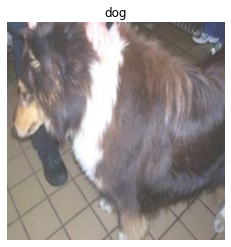

In [4]:
# === Shuffle X and y Together === #
X_train , y_train = shuffle( X_train , y_train )


# === Prove by Printing First Again to show it's Different === #
show_image( X_train , y_train , 0 )

## Convert Classes from Strings to Integers

Keras models don't handle categorical classes as well as numerical classes -- especially fora  binary classifier. Because of this, instead of having two class categories, we will translate the two possible classes to either a zero or a one to let the numerical output of the model specify the predicted class of the data. 

    Cat --> 0
    Dog --> 1

This translation is performed against both the training and validation labels. 

In [5]:
# === Key to Translate in Either Direction
label_keys = {
    'cat' : 0,
    'dog' : 1,
    0     : 'cat',
    1     : 'dog'
}

# === Update Training y === #
y_train[y_train=='cat'] = 0
y_train[y_train=='dog'] = 1
y_train = y_train.astype( X_train.dtype )

# === Update Testing y === #
y_test[y_test=='cat'] = 0
y_test[y_test=='dog'] = 1
y_test = y_test.astype( X_test.dtype )

# === Prove Success === #
y_train

array([1, 0, 0, ..., 0, 0, 1], dtype=uint8)

## Create Model with Tuning Options

We will be using a convolutional neural network, whose layers are specified to resemble the VGG19 model architecture. Consisting of 5 convolution blocks: 2x64, 2x128, 4x256, 4x512, 4x512. Each convolution block has a 2x2 pooling layer at the end of the block. After the five convolution blocks, the model is flattened, connected to a 1024 depth dense layer, then a dropout of 0.3, then a 64 depth dense layer, and finally a 1-depth dense layer for output. the ReLU activation function is used for all relevant layers with the exception of the output layer, which uses the sigmorid activation since this is a binary classification problem. 

In terms of tuning, we will test ten different learning rates between `1e-5` and `1e-4` in order to determine which one best converges the model in terms of accuracy. 

In [6]:
def model_builder( hp ):
    model_layers = [
        keras.Input( shape=X_train[0].shape , name='Input_Layer' ),
    
        keras.layers.Conv2D( 64 , kernel_size=(3,3) , activation='relu' , name='Conv_1_1' , padding='same' ),
        keras.layers.Conv2D( 64 , kernel_size=(3,3) , activation='relu' , name='Conv_1_2' , padding='same' ),
        keras.layers.MaxPooling2D( pool_size=(2,2) , name='Conv_1_Pooling' ),

        keras.layers.Conv2D( 128 , kernel_size=(3,3) , activation='relu' , name='Conv_2_1' , padding='same' ),
        keras.layers.Conv2D( 128 , kernel_size=(3,3) , activation='relu' , name='Conv_2_2' , padding='same' ),
        keras.layers.MaxPooling2D( pool_size=(2,2) , name='Conv_2_Pooling' ),

        keras.layers.Conv2D( 256 , kernel_size=(3,3) , activation='relu' , name='Conv_3_1' , padding='same' ),
        keras.layers.Conv2D( 256 , kernel_size=(3,3) , activation='relu' , name='Conv_3_2' , padding='same' ),
        keras.layers.Conv2D( 256 , kernel_size=(3,3) , activation='relu' , name='Conv_3_3' , padding='same' ),
        keras.layers.Conv2D( 256 , kernel_size=(3,3) , activation='relu' , name='Conv_3_4' , padding='same' ),
        keras.layers.MaxPooling2D( pool_size=(2,2) , name='Conv_3_Pooling' ),

        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_4_1' , padding='same' ),
        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_4_2' , padding='same' ),
        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_4_3' , padding='same' ),
        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_4_4' , padding='same' ),
        keras.layers.MaxPooling2D( pool_size=(2,2) , name='Conv_4_Pooling' ),

        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_5_1' , padding='same' ),
        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_5_2' , padding='same' ),
        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_5_3' , padding='same' ),
        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_5_4' , padding='same' ),
        keras.layers.MaxPooling2D( pool_size=(2,2) , name='Conv_5_Pooling' ),

        keras.layers.Flatten( ),

        keras.layers.Dense( 1024 , activation='relu' ),
        keras.layers.Dropout( 0.3 ),

        keras.layers.Dense( 64 , activation='relu' ),
        keras.layers.Dropout( 0.3 ),

        keras.layers.Dense( 1 , activation='sigmoid' )
    ]
    model            = keras.Sequential( layers=model_layers )
    hp_learning_rate = hp.Choice('learning_rate', values=list(np.linspace(0.000001, 0.00001, 10)))
    optimizer        = keras.optimizers.Adam( lr=hp_learning_rate )
    model.compile( optimizer=optimizer , loss="binary_crossentropy" , metrics=["accuracy"])
    return model

## Tune the Model

Using the keras-tuner package, we will tune the learning rate for the model in order to achieve the optimal validation accuracy via the hyperband tuning altorithm. This value may overfit, but it shows an example of how light tuning may result in better val accuracy in an automated tuning for this specific model architecture. 

In [7]:
start      = default_timer( )
tuner      = kt.Hyperband(model_builder, objective='val_accuracy', max_epochs=10, factor=3, hyperband_iterations=10, directory=os.path.normpath('C:/Users/dryyo/Documents/keras_tuner'), project_name='SmallGrayReg' , overwrite=True)
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner.search(X_train, y_train, epochs=25, batch_size=16, validation_data=(X_test, y_test), callbacks=[stop_early])
best_hps   = tuner.get_best_hyperparameters(num_trials=1)[0]
end        = default_timer( )
times.append( { 'Event': 'Hyperparameter Tuning' , 'Time (sec)': end - start } )

print('The Optimal Leanring Rate is: {}'.format(best_hps.get('learning_rate')))

Train on 8000 samples, validate on 2000 samples
Epoch 1/2


2944/8000 [==========>...................] - ETA: 1:02:09 - loss: 0.6966 - accuracy: 0.500 - ETA: 33:09 - loss: 0.7103 - accuracy: 0.4688  - ETA: 23:32 - loss: 0.6997 - accuracy: 0.520 - ETA: 18:44 - loss: 0.6997 - accuracy: 0.484 - ETA: 15:50 - loss: 0.7133 - accuracy: 0.425 - ETA: 13:54 - loss: 0.7156 - accuracy: 0.416 - ETA: 12:31 - loss: 0.7037 - accuracy: 0.473 - ETA: 11:28 - loss: 0.6979 - accuracy: 0.484 - ETA: 10:39 - loss: 0.6954 - accuracy: 0.486 - ETA: 10:01 - loss: 0.6930 - accuracy: 0.481 - ETA: 9:29 - loss: 0.6909 - accuracy: 0.494 - ETA: 9:02 - loss: 0.6865 - accuracy: 0.51 - ETA: 8:39 - loss: 0.6858 - accuracy: 0.51 - ETA: 8:19 - loss: 0.6856 - accuracy: 0.51 - ETA: 8:02 - loss: 0.6868 - accuracy: 0.51 - ETA: 7:47 - loss: 0.6878 - accuracy: 0.50 - ETA: 7:34 - loss: 0.6883 - accuracy: 0.50 - ETA: 7:22 - loss: 0.6869 - accuracy: 0.51 - ETA: 7:11 - loss: 0.6891 - accuracy: 0.50 - ETA: 7:02 - loss: 0.6878 - accuracy: 0.50 - ETA: 6:54 - loss: 0.6898 - accuracy: 0.50 - ETA: 6

5920/8000 [=====================>........] - ETA: 3:04 - loss: 0.6897 - accuracy: 0.52 - ETA: 3:03 - loss: 0.6899 - accuracy: 0.52 - ETA: 3:03 - loss: 0.6897 - accuracy: 0.52 - ETA: 3:02 - loss: 0.6896 - accuracy: 0.52 - ETA: 3:01 - loss: 0.6897 - accuracy: 0.52 - ETA: 3:01 - loss: 0.6898 - accuracy: 0.52 - ETA: 3:00 - loss: 0.6898 - accuracy: 0.52 - ETA: 3:00 - loss: 0.6897 - accuracy: 0.52 - ETA: 2:59 - loss: 0.6896 - accuracy: 0.52 - ETA: 2:58 - loss: 0.6896 - accuracy: 0.52 - ETA: 2:58 - loss: 0.6893 - accuracy: 0.53 - ETA: 2:57 - loss: 0.6894 - accuracy: 0.53 - ETA: 2:56 - loss: 0.6893 - accuracy: 0.53 - ETA: 2:56 - loss: 0.6892 - accuracy: 0.53 - ETA: 2:55 - loss: 0.6892 - accuracy: 0.53 - ETA: 2:55 - loss: 0.6892 - accuracy: 0.53 - ETA: 2:54 - loss: 0.6890 - accuracy: 0.53 - ETA: 2:53 - loss: 0.6888 - accuracy: 0.53 - ETA: 2:53 - loss: 0.6885 - accuracy: 0.53 - ETA: 2:52 - loss: 0.6889 - accuracy: 0.53 - ETA: 2:52 - loss: 0.6891 - accuracy: 0.53 - ETA: 2:51 - loss: 0.6892 - accu

8000/8000 [==============================] - ETA: 1:14 - loss: 0.6867 - accuracy: 0.54 - ETA: 1:14 - loss: 0.6868 - accuracy: 0.54 - ETA: 1:13 - loss: 0.6869 - accuracy: 0.54 - ETA: 1:13 - loss: 0.6869 - accuracy: 0.54 - ETA: 1:12 - loss: 0.6869 - accuracy: 0.54 - ETA: 1:12 - loss: 0.6869 - accuracy: 0.54 - ETA: 1:11 - loss: 0.6869 - accuracy: 0.54 - ETA: 1:10 - loss: 0.6870 - accuracy: 0.54 - ETA: 1:10 - loss: 0.6870 - accuracy: 0.53 - ETA: 1:09 - loss: 0.6870 - accuracy: 0.54 - ETA: 1:09 - loss: 0.6871 - accuracy: 0.54 - ETA: 1:08 - loss: 0.6870 - accuracy: 0.54 - ETA: 1:08 - loss: 0.6869 - accuracy: 0.54 - ETA: 1:07 - loss: 0.6868 - accuracy: 0.54 - ETA: 1:06 - loss: 0.6868 - accuracy: 0.54 - ETA: 1:06 - loss: 0.6866 - accuracy: 0.54 - ETA: 1:05 - loss: 0.6867 - accuracy: 0.54 - ETA: 1:05 - loss: 0.6867 - accuracy: 0.54 - ETA: 1:04 - loss: 0.6866 - accuracy: 0.54 - ETA: 1:03 - loss: 0.6866 - accuracy: 0.54 - ETA: 1:03 - loss: 0.6865 - accuracy: 0.54 - ETA: 1:02 - loss: 0.6865 - accu

2976/8000 [==========>...................] - ETA: 4:54 - loss: 0.6379 - accuracy: 0.62 - ETA: 4:49 - loss: 0.6304 - accuracy: 0.68 - ETA: 4:49 - loss: 0.6258 - accuracy: 0.70 - ETA: 4:48 - loss: 0.6192 - accuracy: 0.68 - ETA: 4:50 - loss: 0.6409 - accuracy: 0.66 - ETA: 4:48 - loss: 0.6438 - accuracy: 0.66 - ETA: 4:48 - loss: 0.6462 - accuracy: 0.64 - ETA: 4:48 - loss: 0.6539 - accuracy: 0.63 - ETA: 4:48 - loss: 0.6605 - accuracy: 0.61 - ETA: 4:47 - loss: 0.6624 - accuracy: 0.60 - ETA: 4:47 - loss: 0.6591 - accuracy: 0.60 - ETA: 4:47 - loss: 0.6582 - accuracy: 0.59 - ETA: 4:46 - loss: 0.6601 - accuracy: 0.59 - ETA: 4:46 - loss: 0.6599 - accuracy: 0.59 - ETA: 4:45 - loss: 0.6624 - accuracy: 0.58 - ETA: 4:45 - loss: 0.6661 - accuracy: 0.58 - ETA: 4:44 - loss: 0.6663 - accuracy: 0.58 - ETA: 4:44 - loss: 0.6669 - accuracy: 0.58 - ETA: 4:43 - loss: 0.6685 - accuracy: 0.58 - ETA: 4:42 - loss: 0.6681 - accuracy: 0.58 - ETA: 4:42 - loss: 0.6699 - accuracy: 0.58 - ETA: 4:41 - loss: 0.6729 - accu

5952/8000 [=====================>........] - ETA: 3:05 - loss: 0.6660 - accuracy: 0.60 - ETA: 3:04 - loss: 0.6659 - accuracy: 0.60 - ETA: 3:04 - loss: 0.6656 - accuracy: 0.60 - ETA: 3:03 - loss: 0.6657 - accuracy: 0.60 - ETA: 3:02 - loss: 0.6653 - accuracy: 0.60 - ETA: 3:02 - loss: 0.6651 - accuracy: 0.60 - ETA: 3:01 - loss: 0.6648 - accuracy: 0.60 - ETA: 3:01 - loss: 0.6646 - accuracy: 0.60 - ETA: 3:00 - loss: 0.6647 - accuracy: 0.60 - ETA: 2:59 - loss: 0.6646 - accuracy: 0.60 - ETA: 2:59 - loss: 0.6643 - accuracy: 0.60 - ETA: 2:58 - loss: 0.6644 - accuracy: 0.60 - ETA: 2:58 - loss: 0.6648 - accuracy: 0.60 - ETA: 2:57 - loss: 0.6645 - accuracy: 0.60 - ETA: 2:56 - loss: 0.6646 - accuracy: 0.60 - ETA: 2:56 - loss: 0.6648 - accuracy: 0.60 - ETA: 2:55 - loss: 0.6643 - accuracy: 0.60 - ETA: 2:55 - loss: 0.6642 - accuracy: 0.60 - ETA: 2:54 - loss: 0.6640 - accuracy: 0.60 - ETA: 2:54 - loss: 0.6639 - accuracy: 0.60 - ETA: 2:53 - loss: 0.6638 - accuracy: 0.60 - ETA: 2:52 - loss: 0.6639 - accu

8000/8000 [==============================] - ETA: 1:14 - loss: 0.6599 - accuracy: 0.61 - ETA: 1:14 - loss: 0.6602 - accuracy: 0.61 - ETA: 1:13 - loss: 0.6600 - accuracy: 0.61 - ETA: 1:13 - loss: 0.6601 - accuracy: 0.61 - ETA: 1:12 - loss: 0.6600 - accuracy: 0.61 - ETA: 1:11 - loss: 0.6599 - accuracy: 0.61 - ETA: 1:11 - loss: 0.6601 - accuracy: 0.61 - ETA: 1:10 - loss: 0.6601 - accuracy: 0.61 - ETA: 1:10 - loss: 0.6600 - accuracy: 0.61 - ETA: 1:09 - loss: 0.6601 - accuracy: 0.61 - ETA: 1:08 - loss: 0.6599 - accuracy: 0.61 - ETA: 1:08 - loss: 0.6600 - accuracy: 0.61 - ETA: 1:07 - loss: 0.6599 - accuracy: 0.61 - ETA: 1:07 - loss: 0.6598 - accuracy: 0.61 - ETA: 1:06 - loss: 0.6597 - accuracy: 0.61 - ETA: 1:05 - loss: 0.6596 - accuracy: 0.61 - ETA: 1:05 - loss: 0.6598 - accuracy: 0.61 - ETA: 1:04 - loss: 0.6596 - accuracy: 0.61 - ETA: 1:04 - loss: 0.6597 - accuracy: 0.60 - ETA: 1:03 - loss: 0.6595 - accuracy: 0.61 - ETA: 1:02 - loss: 0.6596 - accuracy: 0.61 - ETA: 1:02 - loss: 0.6593 - accu

Train on 8000 samples, validate on 2000 samples
Epoch 1/2


2944/8000 [==========>...................] - ETA: 11:40 - loss: 0.6867 - accuracy: 0.562 - ETA: 8:07 - loss: 0.6878 - accuracy: 0.500 - ETA: 6:59 - loss: 0.6819 - accuracy: 0.52 - ETA: 6:25 - loss: 0.6789 - accuracy: 0.54 - ETA: 6:04 - loss: 0.6813 - accuracy: 0.53 - ETA: 5:49 - loss: 0.6962 - accuracy: 0.52 - ETA: 5:38 - loss: 0.6894 - accuracy: 0.54 - ETA: 5:31 - loss: 0.6978 - accuracy: 0.53 - ETA: 5:25 - loss: 0.6904 - accuracy: 0.54 - ETA: 5:20 - loss: 0.6891 - accuracy: 0.56 - ETA: 5:16 - loss: 0.6942 - accuracy: 0.55 - ETA: 5:12 - loss: 0.6931 - accuracy: 0.53 - ETA: 5:09 - loss: 0.6907 - accuracy: 0.53 - ETA: 5:06 - loss: 0.6923 - accuracy: 0.54 - ETA: 5:04 - loss: 0.6890 - accuracy: 0.55 - ETA: 5:02 - loss: 0.6908 - accuracy: 0.54 - ETA: 5:00 - loss: 0.6903 - accuracy: 0.55 - ETA: 4:58 - loss: 0.6982 - accuracy: 0.54 - ETA: 4:56 - loss: 0.6976 - accuracy: 0.54 - ETA: 4:55 - loss: 0.6964 - accuracy: 0.55 - ETA: 4:53 - loss: 0.6959 - accuracy: 0.54 - ETA: 4:52 - loss: 0.6938 - a

5920/8000 [=====================>........] - ETA: 3:04 - loss: 0.6918 - accuracy: 0.52 - ETA: 3:04 - loss: 0.6918 - accuracy: 0.52 - ETA: 3:03 - loss: 0.6918 - accuracy: 0.52 - ETA: 3:02 - loss: 0.6917 - accuracy: 0.52 - ETA: 3:02 - loss: 0.6918 - accuracy: 0.52 - ETA: 3:01 - loss: 0.6918 - accuracy: 0.52 - ETA: 3:01 - loss: 0.6916 - accuracy: 0.52 - ETA: 3:00 - loss: 0.6919 - accuracy: 0.52 - ETA: 2:59 - loss: 0.6919 - accuracy: 0.52 - ETA: 2:59 - loss: 0.6918 - accuracy: 0.52 - ETA: 2:58 - loss: 0.6920 - accuracy: 0.52 - ETA: 2:58 - loss: 0.6920 - accuracy: 0.52 - ETA: 2:57 - loss: 0.6920 - accuracy: 0.52 - ETA: 2:57 - loss: 0.6919 - accuracy: 0.52 - ETA: 2:56 - loss: 0.6918 - accuracy: 0.52 - ETA: 2:55 - loss: 0.6918 - accuracy: 0.52 - ETA: 2:55 - loss: 0.6918 - accuracy: 0.52 - ETA: 2:54 - loss: 0.6918 - accuracy: 0.52 - ETA: 2:54 - loss: 0.6917 - accuracy: 0.52 - ETA: 2:53 - loss: 0.6919 - accuracy: 0.51 - ETA: 2:52 - loss: 0.6918 - accuracy: 0.52 - ETA: 2:52 - loss: 0.6918 - accu

8000/8000 [==============================] - ETA: 1:15 - loss: 0.6916 - accuracy: 0.52 - ETA: 1:14 - loss: 0.6916 - accuracy: 0.52 - ETA: 1:14 - loss: 0.6916 - accuracy: 0.52 - ETA: 1:13 - loss: 0.6916 - accuracy: 0.52 - ETA: 1:13 - loss: 0.6916 - accuracy: 0.52 - ETA: 1:12 - loss: 0.6916 - accuracy: 0.52 - ETA: 1:11 - loss: 0.6915 - accuracy: 0.52 - ETA: 1:11 - loss: 0.6915 - accuracy: 0.52 - ETA: 1:10 - loss: 0.6916 - accuracy: 0.52 - ETA: 1:10 - loss: 0.6916 - accuracy: 0.52 - ETA: 1:09 - loss: 0.6916 - accuracy: 0.52 - ETA: 1:09 - loss: 0.6915 - accuracy: 0.52 - ETA: 1:08 - loss: 0.6915 - accuracy: 0.52 - ETA: 1:07 - loss: 0.6915 - accuracy: 0.52 - ETA: 1:07 - loss: 0.6914 - accuracy: 0.52 - ETA: 1:06 - loss: 0.6914 - accuracy: 0.52 - ETA: 1:06 - loss: 0.6914 - accuracy: 0.52 - ETA: 1:05 - loss: 0.6914 - accuracy: 0.52 - ETA: 1:04 - loss: 0.6914 - accuracy: 0.52 - ETA: 1:04 - loss: 0.6914 - accuracy: 0.52 - ETA: 1:03 - loss: 0.6913 - accuracy: 0.52 - ETA: 1:03 - loss: 0.6911 - accu

2976/8000 [==========>...................] - ETA: 4:45 - loss: 0.6771 - accuracy: 0.68 - ETA: 4:45 - loss: 0.6973 - accuracy: 0.50 - ETA: 4:45 - loss: 0.6986 - accuracy: 0.50 - ETA: 4:44 - loss: 0.6919 - accuracy: 0.56 - ETA: 4:44 - loss: 0.6897 - accuracy: 0.57 - ETA: 4:43 - loss: 0.6895 - accuracy: 0.57 - ETA: 4:43 - loss: 0.6909 - accuracy: 0.54 - ETA: 4:42 - loss: 0.6908 - accuracy: 0.54 - ETA: 4:42 - loss: 0.6862 - accuracy: 0.57 - ETA: 4:42 - loss: 0.6879 - accuracy: 0.57 - ETA: 4:42 - loss: 0.6917 - accuracy: 0.55 - ETA: 4:41 - loss: 0.6918 - accuracy: 0.54 - ETA: 4:40 - loss: 0.6938 - accuracy: 0.53 - ETA: 4:40 - loss: 0.6947 - accuracy: 0.53 - ETA: 4:40 - loss: 0.6952 - accuracy: 0.52 - ETA: 4:39 - loss: 0.6946 - accuracy: 0.52 - ETA: 4:39 - loss: 0.6934 - accuracy: 0.52 - ETA: 4:38 - loss: 0.6925 - accuracy: 0.53 - ETA: 4:38 - loss: 0.6918 - accuracy: 0.52 - ETA: 4:37 - loss: 0.6902 - accuracy: 0.53 - ETA: 4:36 - loss: 0.6902 - accuracy: 0.53 - ETA: 4:36 - loss: 0.6908 - accu

5952/8000 [=====================>........] - ETA: 3:02 - loss: 0.6696 - accuracy: 0.57 - ETA: 3:02 - loss: 0.6696 - accuracy: 0.57 - ETA: 3:01 - loss: 0.6695 - accuracy: 0.57 - ETA: 3:01 - loss: 0.6691 - accuracy: 0.57 - ETA: 3:00 - loss: 0.6689 - accuracy: 0.57 - ETA: 2:59 - loss: 0.6693 - accuracy: 0.57 - ETA: 2:59 - loss: 0.6697 - accuracy: 0.57 - ETA: 2:58 - loss: 0.6692 - accuracy: 0.57 - ETA: 2:58 - loss: 0.6690 - accuracy: 0.57 - ETA: 2:57 - loss: 0.6688 - accuracy: 0.57 - ETA: 2:57 - loss: 0.6685 - accuracy: 0.57 - ETA: 2:56 - loss: 0.6678 - accuracy: 0.57 - ETA: 2:55 - loss: 0.6673 - accuracy: 0.57 - ETA: 2:55 - loss: 0.6670 - accuracy: 0.57 - ETA: 2:54 - loss: 0.6663 - accuracy: 0.57 - ETA: 2:54 - loss: 0.6670 - accuracy: 0.57 - ETA: 2:53 - loss: 0.6668 - accuracy: 0.57 - ETA: 2:52 - loss: 0.6667 - accuracy: 0.57 - ETA: 2:52 - loss: 0.6668 - accuracy: 0.57 - ETA: 2:51 - loss: 0.6667 - accuracy: 0.57 - ETA: 2:51 - loss: 0.6669 - accuracy: 0.57 - ETA: 2:50 - loss: 0.6670 - accu

8000/8000 [==============================] - ETA: 1:14 - loss: 0.6520 - accuracy: 0.60 - ETA: 1:13 - loss: 0.6524 - accuracy: 0.60 - ETA: 1:12 - loss: 0.6517 - accuracy: 0.60 - ETA: 1:12 - loss: 0.6512 - accuracy: 0.60 - ETA: 1:11 - loss: 0.6514 - accuracy: 0.60 - ETA: 1:11 - loss: 0.6511 - accuracy: 0.60 - ETA: 1:10 - loss: 0.6509 - accuracy: 0.60 - ETA: 1:10 - loss: 0.6508 - accuracy: 0.60 - ETA: 1:09 - loss: 0.6508 - accuracy: 0.60 - ETA: 1:08 - loss: 0.6510 - accuracy: 0.60 - ETA: 1:08 - loss: 0.6512 - accuracy: 0.60 - ETA: 1:07 - loss: 0.6513 - accuracy: 0.60 - ETA: 1:07 - loss: 0.6508 - accuracy: 0.60 - ETA: 1:06 - loss: 0.6506 - accuracy: 0.60 - ETA: 1:05 - loss: 0.6506 - accuracy: 0.60 - ETA: 1:05 - loss: 0.6507 - accuracy: 0.60 - ETA: 1:04 - loss: 0.6502 - accuracy: 0.60 - ETA: 1:04 - loss: 0.6502 - accuracy: 0.60 - ETA: 1:03 - loss: 0.6502 - accuracy: 0.60 - ETA: 1:03 - loss: 0.6501 - accuracy: 0.60 - ETA: 1:02 - loss: 0.6504 - accuracy: 0.60 - ETA: 1:01 - loss: 0.6501 - accu

Train on 8000 samples, validate on 2000 samples
Epoch 1/2


2944/8000 [==========>...................] - ETA: 11:22 - loss: 0.7077 - accuracy: 0.562 - ETA: 8:01 - loss: 0.6790 - accuracy: 0.656 - ETA: 6:56 - loss: 0.6856 - accuracy: 0.60 - ETA: 6:21 - loss: 0.7118 - accuracy: 0.56 - ETA: 6:00 - loss: 0.7403 - accuracy: 0.52 - ETA: 5:47 - loss: 0.7390 - accuracy: 0.52 - ETA: 5:37 - loss: 0.7332 - accuracy: 0.52 - ETA: 5:30 - loss: 0.7236 - accuracy: 0.53 - ETA: 5:24 - loss: 0.7282 - accuracy: 0.50 - ETA: 5:19 - loss: 0.7247 - accuracy: 0.51 - ETA: 5:15 - loss: 0.7202 - accuracy: 0.52 - ETA: 5:11 - loss: 0.7166 - accuracy: 0.54 - ETA: 5:08 - loss: 0.7152 - accuracy: 0.53 - ETA: 5:06 - loss: 0.7138 - accuracy: 0.53 - ETA: 5:04 - loss: 0.7102 - accuracy: 0.54 - ETA: 5:01 - loss: 0.7074 - accuracy: 0.55 - ETA: 4:59 - loss: 0.7079 - accuracy: 0.55 - ETA: 4:58 - loss: 0.7075 - accuracy: 0.55 - ETA: 4:56 - loss: 0.7068 - accuracy: 0.55 - ETA: 4:55 - loss: 0.7068 - accuracy: 0.55 - ETA: 4:53 - loss: 0.7065 - accuracy: 0.54 - ETA: 4:52 - loss: 0.7067 - a

5920/8000 [=====================>........] - ETA: 3:04 - loss: 0.6953 - accuracy: 0.50 - ETA: 3:04 - loss: 0.6953 - accuracy: 0.50 - ETA: 3:03 - loss: 0.6953 - accuracy: 0.50 - ETA: 3:02 - loss: 0.6953 - accuracy: 0.50 - ETA: 3:02 - loss: 0.6952 - accuracy: 0.50 - ETA: 3:01 - loss: 0.6953 - accuracy: 0.50 - ETA: 3:01 - loss: 0.6953 - accuracy: 0.50 - ETA: 3:00 - loss: 0.6952 - accuracy: 0.50 - ETA: 2:59 - loss: 0.6951 - accuracy: 0.50 - ETA: 2:59 - loss: 0.6951 - accuracy: 0.50 - ETA: 2:58 - loss: 0.6952 - accuracy: 0.50 - ETA: 2:58 - loss: 0.6952 - accuracy: 0.50 - ETA: 2:57 - loss: 0.6951 - accuracy: 0.50 - ETA: 2:57 - loss: 0.6950 - accuracy: 0.50 - ETA: 2:56 - loss: 0.6950 - accuracy: 0.50 - ETA: 2:55 - loss: 0.6950 - accuracy: 0.50 - ETA: 2:55 - loss: 0.6950 - accuracy: 0.50 - ETA: 2:54 - loss: 0.6950 - accuracy: 0.50 - ETA: 2:54 - loss: 0.6949 - accuracy: 0.50 - ETA: 2:53 - loss: 0.6949 - accuracy: 0.51 - ETA: 2:52 - loss: 0.6948 - accuracy: 0.51 - ETA: 2:52 - loss: 0.6948 - accu

8000/8000 [==============================] - ETA: 1:15 - loss: 0.6927 - accuracy: 0.51 - ETA: 1:14 - loss: 0.6927 - accuracy: 0.51 - ETA: 1:14 - loss: 0.6927 - accuracy: 0.51 - ETA: 1:13 - loss: 0.6927 - accuracy: 0.51 - ETA: 1:13 - loss: 0.6927 - accuracy: 0.51 - ETA: 1:12 - loss: 0.6928 - accuracy: 0.51 - ETA: 1:11 - loss: 0.6928 - accuracy: 0.51 - ETA: 1:11 - loss: 0.6928 - accuracy: 0.51 - ETA: 1:10 - loss: 0.6929 - accuracy: 0.51 - ETA: 1:10 - loss: 0.6928 - accuracy: 0.51 - ETA: 1:09 - loss: 0.6928 - accuracy: 0.51 - ETA: 1:09 - loss: 0.6928 - accuracy: 0.51 - ETA: 1:08 - loss: 0.6928 - accuracy: 0.51 - ETA: 1:07 - loss: 0.6928 - accuracy: 0.51 - ETA: 1:07 - loss: 0.6928 - accuracy: 0.51 - ETA: 1:06 - loss: 0.6928 - accuracy: 0.51 - ETA: 1:06 - loss: 0.6928 - accuracy: 0.51 - ETA: 1:05 - loss: 0.6928 - accuracy: 0.51 - ETA: 1:04 - loss: 0.6928 - accuracy: 0.51 - ETA: 1:04 - loss: 0.6928 - accuracy: 0.51 - ETA: 1:03 - loss: 0.6928 - accuracy: 0.51 - ETA: 1:03 - loss: 0.6928 - accu

2976/8000 [==========>...................] - ETA: 4:46 - loss: 0.6420 - accuracy: 0.68 - ETA: 4:48 - loss: 0.6676 - accuracy: 0.62 - ETA: 4:44 - loss: 0.6533 - accuracy: 0.62 - ETA: 4:44 - loss: 0.6888 - accuracy: 0.53 - ETA: 4:44 - loss: 0.6753 - accuracy: 0.60 - ETA: 4:44 - loss: 0.6784 - accuracy: 0.59 - ETA: 4:43 - loss: 0.6754 - accuracy: 0.58 - ETA: 4:43 - loss: 0.6760 - accuracy: 0.58 - ETA: 4:42 - loss: 0.6786 - accuracy: 0.57 - ETA: 4:43 - loss: 0.6814 - accuracy: 0.56 - ETA: 4:42 - loss: 0.6781 - accuracy: 0.57 - ETA: 4:41 - loss: 0.6772 - accuracy: 0.57 - ETA: 4:40 - loss: 0.6771 - accuracy: 0.57 - ETA: 4:40 - loss: 0.6792 - accuracy: 0.57 - ETA: 4:39 - loss: 0.6733 - accuracy: 0.59 - ETA: 4:39 - loss: 0.6722 - accuracy: 0.59 - ETA: 4:38 - loss: 0.6755 - accuracy: 0.58 - ETA: 4:38 - loss: 0.6713 - accuracy: 0.60 - ETA: 4:37 - loss: 0.6723 - accuracy: 0.59 - ETA: 4:37 - loss: 0.6729 - accuracy: 0.59 - ETA: 4:36 - loss: 0.6728 - accuracy: 0.59 - ETA: 4:36 - loss: 0.6724 - accu

5952/8000 [=====================>........] - ETA: 3:02 - loss: 0.6542 - accuracy: 0.60 - ETA: 3:02 - loss: 0.6538 - accuracy: 0.60 - ETA: 3:01 - loss: 0.6539 - accuracy: 0.60 - ETA: 3:01 - loss: 0.6534 - accuracy: 0.61 - ETA: 3:00 - loss: 0.6528 - accuracy: 0.61 - ETA: 2:59 - loss: 0.6519 - accuracy: 0.61 - ETA: 2:59 - loss: 0.6515 - accuracy: 0.61 - ETA: 2:58 - loss: 0.6508 - accuracy: 0.61 - ETA: 2:58 - loss: 0.6509 - accuracy: 0.61 - ETA: 2:57 - loss: 0.6504 - accuracy: 0.61 - ETA: 2:57 - loss: 0.6513 - accuracy: 0.61 - ETA: 2:56 - loss: 0.6528 - accuracy: 0.61 - ETA: 2:55 - loss: 0.6530 - accuracy: 0.61 - ETA: 2:55 - loss: 0.6532 - accuracy: 0.61 - ETA: 2:54 - loss: 0.6525 - accuracy: 0.61 - ETA: 2:54 - loss: 0.6524 - accuracy: 0.61 - ETA: 2:53 - loss: 0.6529 - accuracy: 0.61 - ETA: 2:52 - loss: 0.6531 - accuracy: 0.61 - ETA: 2:52 - loss: 0.6538 - accuracy: 0.61 - ETA: 2:51 - loss: 0.6542 - accuracy: 0.61 - ETA: 2:51 - loss: 0.6542 - accuracy: 0.61 - ETA: 2:50 - loss: 0.6542 - accu

8000/8000 [==============================] - ETA: 1:14 - loss: 0.6422 - accuracy: 0.62 - ETA: 1:13 - loss: 0.6425 - accuracy: 0.62 - ETA: 1:13 - loss: 0.6426 - accuracy: 0.62 - ETA: 1:12 - loss: 0.6424 - accuracy: 0.62 - ETA: 1:11 - loss: 0.6423 - accuracy: 0.62 - ETA: 1:11 - loss: 0.6427 - accuracy: 0.62 - ETA: 1:10 - loss: 0.6427 - accuracy: 0.62 - ETA: 1:10 - loss: 0.6425 - accuracy: 0.62 - ETA: 1:09 - loss: 0.6423 - accuracy: 0.62 - ETA: 1:08 - loss: 0.6426 - accuracy: 0.62 - ETA: 1:08 - loss: 0.6425 - accuracy: 0.62 - ETA: 1:07 - loss: 0.6425 - accuracy: 0.62 - ETA: 1:07 - loss: 0.6423 - accuracy: 0.62 - ETA: 1:06 - loss: 0.6424 - accuracy: 0.62 - ETA: 1:06 - loss: 0.6421 - accuracy: 0.62 - ETA: 1:05 - loss: 0.6420 - accuracy: 0.62 - ETA: 1:04 - loss: 0.6421 - accuracy: 0.62 - ETA: 1:04 - loss: 0.6423 - accuracy: 0.62 - ETA: 1:03 - loss: 0.6423 - accuracy: 0.62 - ETA: 1:03 - loss: 0.6422 - accuracy: 0.62 - ETA: 1:02 - loss: 0.6420 - accuracy: 0.62 - ETA: 1:01 - loss: 0.6421 - accu

Train on 8000 samples, validate on 2000 samples
Epoch 1/2


2944/8000 [==========>...................] - ETA: 11:24 - loss: 0.6954 - accuracy: 0.500 - ETA: 8:02 - loss: 0.6900 - accuracy: 0.562 - ETA: 6:56 - loss: 0.6905 - accuracy: 0.54 - ETA: 6:22 - loss: 0.6913 - accuracy: 0.57 - ETA: 6:02 - loss: 0.6955 - accuracy: 0.52 - ETA: 5:48 - loss: 0.7004 - accuracy: 0.50 - ETA: 5:37 - loss: 0.6982 - accuracy: 0.50 - ETA: 5:30 - loss: 0.6983 - accuracy: 0.50 - ETA: 5:24 - loss: 0.6974 - accuracy: 0.50 - ETA: 5:19 - loss: 0.6974 - accuracy: 0.50 - ETA: 5:15 - loss: 0.6980 - accuracy: 0.49 - ETA: 5:12 - loss: 0.6997 - accuracy: 0.48 - ETA: 5:09 - loss: 0.6990 - accuracy: 0.49 - ETA: 5:06 - loss: 0.6976 - accuracy: 0.50 - ETA: 5:04 - loss: 0.6963 - accuracy: 0.50 - ETA: 5:01 - loss: 0.6973 - accuracy: 0.49 - ETA: 4:59 - loss: 0.6971 - accuracy: 0.48 - ETA: 4:58 - loss: 0.6967 - accuracy: 0.49 - ETA: 4:56 - loss: 0.6972 - accuracy: 0.49 - ETA: 4:54 - loss: 0.6962 - accuracy: 0.50 - ETA: 4:53 - loss: 0.6959 - accuracy: 0.50 - ETA: 4:52 - loss: 0.6967 - a

5920/8000 [=====================>........] - ETA: 3:04 - loss: 0.6905 - accuracy: 0.53 - ETA: 3:04 - loss: 0.6906 - accuracy: 0.53 - ETA: 3:03 - loss: 0.6906 - accuracy: 0.53 - ETA: 3:03 - loss: 0.6906 - accuracy: 0.53 - ETA: 3:02 - loss: 0.6906 - accuracy: 0.53 - ETA: 3:01 - loss: 0.6904 - accuracy: 0.53 - ETA: 3:01 - loss: 0.6906 - accuracy: 0.53 - ETA: 3:00 - loss: 0.6906 - accuracy: 0.53 - ETA: 3:00 - loss: 0.6906 - accuracy: 0.53 - ETA: 2:59 - loss: 0.6906 - accuracy: 0.53 - ETA: 2:59 - loss: 0.6908 - accuracy: 0.52 - ETA: 2:58 - loss: 0.6907 - accuracy: 0.53 - ETA: 2:57 - loss: 0.6904 - accuracy: 0.53 - ETA: 2:57 - loss: 0.6903 - accuracy: 0.53 - ETA: 2:56 - loss: 0.6905 - accuracy: 0.52 - ETA: 2:56 - loss: 0.6905 - accuracy: 0.53 - ETA: 2:55 - loss: 0.6905 - accuracy: 0.53 - ETA: 2:54 - loss: 0.6905 - accuracy: 0.53 - ETA: 2:54 - loss: 0.6905 - accuracy: 0.53 - ETA: 2:53 - loss: 0.6905 - accuracy: 0.53 - ETA: 2:53 - loss: 0.6905 - accuracy: 0.52 - ETA: 2:52 - loss: 0.6903 - accu

8000/8000 [==============================] - ETA: 1:15 - loss: 0.6874 - accuracy: 0.54 - ETA: 1:15 - loss: 0.6873 - accuracy: 0.54 - ETA: 1:14 - loss: 0.6873 - accuracy: 0.54 - ETA: 1:13 - loss: 0.6873 - accuracy: 0.54 - ETA: 1:13 - loss: 0.6873 - accuracy: 0.54 - ETA: 1:12 - loss: 0.6872 - accuracy: 0.54 - ETA: 1:12 - loss: 0.6872 - accuracy: 0.54 - ETA: 1:11 - loss: 0.6871 - accuracy: 0.54 - ETA: 1:10 - loss: 0.6871 - accuracy: 0.54 - ETA: 1:10 - loss: 0.6871 - accuracy: 0.54 - ETA: 1:09 - loss: 0.6870 - accuracy: 0.54 - ETA: 1:09 - loss: 0.6870 - accuracy: 0.54 - ETA: 1:08 - loss: 0.6869 - accuracy: 0.54 - ETA: 1:08 - loss: 0.6870 - accuracy: 0.54 - ETA: 1:07 - loss: 0.6869 - accuracy: 0.54 - ETA: 1:06 - loss: 0.6870 - accuracy: 0.54 - ETA: 1:06 - loss: 0.6870 - accuracy: 0.54 - ETA: 1:05 - loss: 0.6869 - accuracy: 0.54 - ETA: 1:05 - loss: 0.6868 - accuracy: 0.54 - ETA: 1:04 - loss: 0.6867 - accuracy: 0.54 - ETA: 1:03 - loss: 0.6867 - accuracy: 0.54 - ETA: 1:03 - loss: 0.6865 - accu

2976/8000 [==========>...................] - ETA: 4:43 - loss: 0.6375 - accuracy: 0.68 - ETA: 4:43 - loss: 0.6811 - accuracy: 0.56 - ETA: 4:44 - loss: 0.6792 - accuracy: 0.54 - ETA: 4:45 - loss: 0.6631 - accuracy: 0.56 - ETA: 4:44 - loss: 0.6675 - accuracy: 0.52 - ETA: 4:43 - loss: 0.6836 - accuracy: 0.52 - ETA: 4:44 - loss: 0.6821 - accuracy: 0.50 - ETA: 4:42 - loss: 0.6748 - accuracy: 0.52 - ETA: 4:43 - loss: 0.6645 - accuracy: 0.52 - ETA: 4:42 - loss: 0.6665 - accuracy: 0.51 - ETA: 4:42 - loss: 0.6648 - accuracy: 0.53 - ETA: 4:41 - loss: 0.6647 - accuracy: 0.54 - ETA: 4:41 - loss: 0.6668 - accuracy: 0.53 - ETA: 4:40 - loss: 0.6678 - accuracy: 0.54 - ETA: 4:39 - loss: 0.6642 - accuracy: 0.55 - ETA: 4:39 - loss: 0.6643 - accuracy: 0.54 - ETA: 4:39 - loss: 0.6661 - accuracy: 0.54 - ETA: 4:38 - loss: 0.6745 - accuracy: 0.53 - ETA: 4:38 - loss: 0.6727 - accuracy: 0.53 - ETA: 4:37 - loss: 0.6776 - accuracy: 0.53 - ETA: 4:37 - loss: 0.6774 - accuracy: 0.53 - ETA: 4:36 - loss: 0.6774 - accu

5952/8000 [=====================>........] - ETA: 3:02 - loss: 0.6400 - accuracy: 0.61 - ETA: 3:02 - loss: 0.6407 - accuracy: 0.61 - ETA: 3:01 - loss: 0.6397 - accuracy: 0.61 - ETA: 3:00 - loss: 0.6396 - accuracy: 0.61 - ETA: 3:00 - loss: 0.6393 - accuracy: 0.61 - ETA: 2:59 - loss: 0.6394 - accuracy: 0.61 - ETA: 2:59 - loss: 0.6406 - accuracy: 0.61 - ETA: 2:58 - loss: 0.6410 - accuracy: 0.61 - ETA: 2:57 - loss: 0.6409 - accuracy: 0.61 - ETA: 2:57 - loss: 0.6409 - accuracy: 0.61 - ETA: 2:56 - loss: 0.6414 - accuracy: 0.61 - ETA: 2:56 - loss: 0.6413 - accuracy: 0.61 - ETA: 2:55 - loss: 0.6407 - accuracy: 0.61 - ETA: 2:55 - loss: 0.6410 - accuracy: 0.61 - ETA: 2:54 - loss: 0.6411 - accuracy: 0.61 - ETA: 2:53 - loss: 0.6412 - accuracy: 0.61 - ETA: 2:53 - loss: 0.6411 - accuracy: 0.61 - ETA: 2:52 - loss: 0.6407 - accuracy: 0.61 - ETA: 2:52 - loss: 0.6411 - accuracy: 0.61 - ETA: 2:51 - loss: 0.6406 - accuracy: 0.61 - ETA: 2:50 - loss: 0.6401 - accuracy: 0.61 - ETA: 2:50 - loss: 0.6403 - accu

8000/8000 [==============================] - ETA: 1:14 - loss: 0.6263 - accuracy: 0.63 - ETA: 1:13 - loss: 0.6265 - accuracy: 0.63 - ETA: 1:12 - loss: 0.6264 - accuracy: 0.63 - ETA: 1:12 - loss: 0.6268 - accuracy: 0.63 - ETA: 1:11 - loss: 0.6263 - accuracy: 0.63 - ETA: 1:11 - loss: 0.6263 - accuracy: 0.63 - ETA: 1:10 - loss: 0.6259 - accuracy: 0.63 - ETA: 1:10 - loss: 0.6260 - accuracy: 0.63 - ETA: 1:09 - loss: 0.6260 - accuracy: 0.63 - ETA: 1:08 - loss: 0.6263 - accuracy: 0.63 - ETA: 1:08 - loss: 0.6258 - accuracy: 0.63 - ETA: 1:07 - loss: 0.6258 - accuracy: 0.63 - ETA: 1:07 - loss: 0.6259 - accuracy: 0.63 - ETA: 1:06 - loss: 0.6261 - accuracy: 0.63 - ETA: 1:05 - loss: 0.6259 - accuracy: 0.63 - ETA: 1:05 - loss: 0.6259 - accuracy: 0.63 - ETA: 1:04 - loss: 0.6259 - accuracy: 0.63 - ETA: 1:04 - loss: 0.6257 - accuracy: 0.63 - ETA: 1:03 - loss: 0.6257 - accuracy: 0.63 - ETA: 1:03 - loss: 0.6258 - accuracy: 0.63 - ETA: 1:02 - loss: 0.6257 - accuracy: 0.63 - ETA: 1:01 - loss: 0.6255 - accu

Train on 8000 samples, validate on 2000 samples
Epoch 1/2


2944/8000 [==========>...................] - ETA: 11:22 - loss: 0.7112 - accuracy: 0.500 - ETA: 8:02 - loss: 0.6757 - accuracy: 0.656 - ETA: 6:56 - loss: 0.7087 - accuracy: 0.56 - ETA: 6:22 - loss: 0.7024 - accuracy: 0.56 - ETA: 6:02 - loss: 0.6837 - accuracy: 0.60 - ETA: 5:48 - loss: 0.6913 - accuracy: 0.57 - ETA: 5:38 - loss: 0.6941 - accuracy: 0.56 - ETA: 5:30 - loss: 0.6979 - accuracy: 0.55 - ETA: 5:24 - loss: 0.6983 - accuracy: 0.55 - ETA: 5:19 - loss: 0.7017 - accuracy: 0.53 - ETA: 5:15 - loss: 0.7018 - accuracy: 0.51 - ETA: 5:12 - loss: 0.7039 - accuracy: 0.49 - ETA: 5:09 - loss: 0.7037 - accuracy: 0.49 - ETA: 5:06 - loss: 0.7025 - accuracy: 0.50 - ETA: 5:04 - loss: 0.7006 - accuracy: 0.50 - ETA: 5:02 - loss: 0.6978 - accuracy: 0.51 - ETA: 5:00 - loss: 0.6992 - accuracy: 0.50 - ETA: 4:58 - loss: 0.7002 - accuracy: 0.50 - ETA: 4:56 - loss: 0.6983 - accuracy: 0.51 - ETA: 4:55 - loss: 0.6983 - accuracy: 0.51 - ETA: 4:54 - loss: 0.6977 - accuracy: 0.52 - ETA: 4:53 - loss: 0.6976 - a

5920/8000 [=====================>........] - ETA: 3:04 - loss: 0.6949 - accuracy: 0.50 - ETA: 3:04 - loss: 0.6949 - accuracy: 0.50 - ETA: 3:03 - loss: 0.6949 - accuracy: 0.50 - ETA: 3:03 - loss: 0.6948 - accuracy: 0.50 - ETA: 3:02 - loss: 0.6948 - accuracy: 0.50 - ETA: 3:01 - loss: 0.6948 - accuracy: 0.50 - ETA: 3:01 - loss: 0.6948 - accuracy: 0.50 - ETA: 3:00 - loss: 0.6948 - accuracy: 0.50 - ETA: 3:00 - loss: 0.6948 - accuracy: 0.50 - ETA: 2:59 - loss: 0.6947 - accuracy: 0.50 - ETA: 2:59 - loss: 0.6947 - accuracy: 0.50 - ETA: 2:58 - loss: 0.6947 - accuracy: 0.50 - ETA: 2:57 - loss: 0.6946 - accuracy: 0.50 - ETA: 2:57 - loss: 0.6946 - accuracy: 0.50 - ETA: 2:56 - loss: 0.6946 - accuracy: 0.50 - ETA: 2:56 - loss: 0.6945 - accuracy: 0.50 - ETA: 2:55 - loss: 0.6945 - accuracy: 0.50 - ETA: 2:54 - loss: 0.6945 - accuracy: 0.50 - ETA: 2:54 - loss: 0.6945 - accuracy: 0.50 - ETA: 2:53 - loss: 0.6945 - accuracy: 0.50 - ETA: 2:53 - loss: 0.6945 - accuracy: 0.50 - ETA: 2:52 - loss: 0.6945 - accu

8000/8000 [==============================] - ETA: 1:15 - loss: 0.6925 - accuracy: 0.50 - ETA: 1:14 - loss: 0.6925 - accuracy: 0.50 - ETA: 1:14 - loss: 0.6925 - accuracy: 0.50 - ETA: 1:13 - loss: 0.6924 - accuracy: 0.50 - ETA: 1:13 - loss: 0.6925 - accuracy: 0.50 - ETA: 1:12 - loss: 0.6925 - accuracy: 0.50 - ETA: 1:12 - loss: 0.6924 - accuracy: 0.50 - ETA: 1:11 - loss: 0.6925 - accuracy: 0.50 - ETA: 1:10 - loss: 0.6924 - accuracy: 0.50 - ETA: 1:10 - loss: 0.6924 - accuracy: 0.50 - ETA: 1:09 - loss: 0.6924 - accuracy: 0.50 - ETA: 1:09 - loss: 0.6924 - accuracy: 0.50 - ETA: 1:08 - loss: 0.6924 - accuracy: 0.50 - ETA: 1:07 - loss: 0.6924 - accuracy: 0.50 - ETA: 1:07 - loss: 0.6924 - accuracy: 0.50 - ETA: 1:06 - loss: 0.6924 - accuracy: 0.50 - ETA: 1:06 - loss: 0.6925 - accuracy: 0.50 - ETA: 1:05 - loss: 0.6925 - accuracy: 0.50 - ETA: 1:04 - loss: 0.6925 - accuracy: 0.50 - ETA: 1:04 - loss: 0.6925 - accuracy: 0.50 - ETA: 1:03 - loss: 0.6925 - accuracy: 0.50 - ETA: 1:03 - loss: 0.6925 - accu

2976/8000 [==========>...................] - ETA: 4:45 - loss: 0.6907 - accuracy: 0.50 - ETA: 4:48 - loss: 0.6896 - accuracy: 0.59 - ETA: 4:44 - loss: 0.6894 - accuracy: 0.60 - ETA: 4:45 - loss: 0.6919 - accuracy: 0.54 - ETA: 4:44 - loss: 0.6922 - accuracy: 0.52 - ETA: 4:44 - loss: 0.6924 - accuracy: 0.51 - ETA: 4:44 - loss: 0.6911 - accuracy: 0.52 - ETA: 4:43 - loss: 0.6910 - accuracy: 0.52 - ETA: 4:42 - loss: 0.6921 - accuracy: 0.48 - ETA: 4:42 - loss: 0.6925 - accuracy: 0.48 - ETA: 4:41 - loss: 0.6916 - accuracy: 0.51 - ETA: 4:41 - loss: 0.6909 - accuracy: 0.52 - ETA: 4:40 - loss: 0.6908 - accuracy: 0.52 - ETA: 4:40 - loss: 0.6911 - accuracy: 0.52 - ETA: 4:40 - loss: 0.6913 - accuracy: 0.51 - ETA: 4:39 - loss: 0.6908 - accuracy: 0.52 - ETA: 4:39 - loss: 0.6917 - accuracy: 0.50 - ETA: 4:38 - loss: 0.6915 - accuracy: 0.51 - ETA: 4:38 - loss: 0.6916 - accuracy: 0.50 - ETA: 4:37 - loss: 0.6915 - accuracy: 0.50 - ETA: 4:37 - loss: 0.6913 - accuracy: 0.51 - ETA: 4:36 - loss: 0.6914 - accu

5952/8000 [=====================>........] - ETA: 3:02 - loss: 0.6865 - accuracy: 0.53 - ETA: 3:01 - loss: 0.6869 - accuracy: 0.53 - ETA: 3:01 - loss: 0.6870 - accuracy: 0.53 - ETA: 3:00 - loss: 0.6871 - accuracy: 0.53 - ETA: 3:00 - loss: 0.6870 - accuracy: 0.53 - ETA: 2:59 - loss: 0.6869 - accuracy: 0.54 - ETA: 2:58 - loss: 0.6869 - accuracy: 0.53 - ETA: 2:58 - loss: 0.6869 - accuracy: 0.53 - ETA: 2:57 - loss: 0.6869 - accuracy: 0.53 - ETA: 2:57 - loss: 0.6868 - accuracy: 0.53 - ETA: 2:56 - loss: 0.6868 - accuracy: 0.53 - ETA: 2:56 - loss: 0.6868 - accuracy: 0.53 - ETA: 2:55 - loss: 0.6869 - accuracy: 0.53 - ETA: 2:54 - loss: 0.6871 - accuracy: 0.53 - ETA: 2:54 - loss: 0.6870 - accuracy: 0.53 - ETA: 2:53 - loss: 0.6871 - accuracy: 0.53 - ETA: 2:53 - loss: 0.6873 - accuracy: 0.53 - ETA: 2:52 - loss: 0.6874 - accuracy: 0.53 - ETA: 2:51 - loss: 0.6875 - accuracy: 0.53 - ETA: 2:51 - loss: 0.6875 - accuracy: 0.53 - ETA: 2:50 - loss: 0.6876 - accuracy: 0.53 - ETA: 2:50 - loss: 0.6878 - accu

8000/8000 [==============================] - ETA: 1:14 - loss: 0.6862 - accuracy: 0.54 - ETA: 1:13 - loss: 0.6860 - accuracy: 0.54 - ETA: 1:12 - loss: 0.6860 - accuracy: 0.54 - ETA: 1:12 - loss: 0.6860 - accuracy: 0.54 - ETA: 1:11 - loss: 0.6860 - accuracy: 0.54 - ETA: 1:11 - loss: 0.6861 - accuracy: 0.54 - ETA: 1:10 - loss: 0.6861 - accuracy: 0.54 - ETA: 1:09 - loss: 0.6860 - accuracy: 0.54 - ETA: 1:09 - loss: 0.6861 - accuracy: 0.54 - ETA: 1:08 - loss: 0.6860 - accuracy: 0.54 - ETA: 1:08 - loss: 0.6860 - accuracy: 0.54 - ETA: 1:07 - loss: 0.6860 - accuracy: 0.54 - ETA: 1:07 - loss: 0.6860 - accuracy: 0.54 - ETA: 1:06 - loss: 0.6860 - accuracy: 0.54 - ETA: 1:05 - loss: 0.6860 - accuracy: 0.54 - ETA: 1:05 - loss: 0.6860 - accuracy: 0.54 - ETA: 1:04 - loss: 0.6860 - accuracy: 0.54 - ETA: 1:04 - loss: 0.6860 - accuracy: 0.54 - ETA: 1:03 - loss: 0.6858 - accuracy: 0.54 - ETA: 1:02 - loss: 0.6859 - accuracy: 0.54 - ETA: 1:02 - loss: 0.6858 - accuracy: 0.54 - ETA: 1:01 - loss: 0.6858 - accu

Train on 8000 samples, validate on 2000 samples
Epoch 1/2


2944/8000 [==========>...................] - ETA: 11:28 - loss: 0.7057 - accuracy: 0.437 - ETA: 8:02 - loss: 0.7454 - accuracy: 0.406 - ETA: 6:55 - loss: 0.7146 - accuracy: 0.54 - ETA: 6:23 - loss: 0.7264 - accuracy: 0.50 - ETA: 6:02 - loss: 0.7221 - accuracy: 0.48 - ETA: 5:48 - loss: 0.7240 - accuracy: 0.47 - ETA: 5:38 - loss: 0.7154 - accuracy: 0.50 - ETA: 5:29 - loss: 0.7102 - accuracy: 0.51 - ETA: 5:24 - loss: 0.7140 - accuracy: 0.51 - ETA: 5:19 - loss: 0.7151 - accuracy: 0.50 - ETA: 5:15 - loss: 0.7117 - accuracy: 0.50 - ETA: 5:11 - loss: 0.7113 - accuracy: 0.50 - ETA: 5:09 - loss: 0.7090 - accuracy: 0.50 - ETA: 5:06 - loss: 0.7057 - accuracy: 0.51 - ETA: 5:03 - loss: 0.7005 - accuracy: 0.51 - ETA: 5:01 - loss: 0.7017 - accuracy: 0.51 - ETA: 4:59 - loss: 0.7064 - accuracy: 0.50 - ETA: 4:58 - loss: 0.7094 - accuracy: 0.50 - ETA: 4:57 - loss: 0.7098 - accuracy: 0.50 - ETA: 4:55 - loss: 0.7121 - accuracy: 0.49 - ETA: 4:54 - loss: 0.7125 - accuracy: 0.49 - ETA: 4:54 - loss: 0.7128 - a

5920/8000 [=====================>........] - ETA: 3:05 - loss: 0.6939 - accuracy: 0.52 - ETA: 3:04 - loss: 0.6937 - accuracy: 0.52 - ETA: 3:04 - loss: 0.6937 - accuracy: 0.52 - ETA: 3:03 - loss: 0.6937 - accuracy: 0.52 - ETA: 3:02 - loss: 0.6937 - accuracy: 0.52 - ETA: 3:02 - loss: 0.6939 - accuracy: 0.52 - ETA: 3:01 - loss: 0.6937 - accuracy: 0.52 - ETA: 3:01 - loss: 0.6938 - accuracy: 0.52 - ETA: 3:00 - loss: 0.6937 - accuracy: 0.52 - ETA: 2:59 - loss: 0.6938 - accuracy: 0.52 - ETA: 2:59 - loss: 0.6936 - accuracy: 0.52 - ETA: 2:58 - loss: 0.6934 - accuracy: 0.52 - ETA: 2:58 - loss: 0.6933 - accuracy: 0.52 - ETA: 2:57 - loss: 0.6934 - accuracy: 0.52 - ETA: 2:56 - loss: 0.6935 - accuracy: 0.52 - ETA: 2:56 - loss: 0.6934 - accuracy: 0.52 - ETA: 2:55 - loss: 0.6933 - accuracy: 0.52 - ETA: 2:55 - loss: 0.6934 - accuracy: 0.52 - ETA: 2:54 - loss: 0.6934 - accuracy: 0.52 - ETA: 2:53 - loss: 0.6935 - accuracy: 0.52 - ETA: 2:53 - loss: 0.6935 - accuracy: 0.52 - ETA: 2:52 - loss: 0.6937 - accu

8000/8000 [==============================] - ETA: 1:15 - loss: 0.6916 - accuracy: 0.53 - ETA: 1:15 - loss: 0.6916 - accuracy: 0.53 - ETA: 1:14 - loss: 0.6916 - accuracy: 0.53 - ETA: 1:13 - loss: 0.6916 - accuracy: 0.53 - ETA: 1:13 - loss: 0.6915 - accuracy: 0.53 - ETA: 1:12 - loss: 0.6915 - accuracy: 0.53 - ETA: 1:12 - loss: 0.6915 - accuracy: 0.53 - ETA: 1:11 - loss: 0.6914 - accuracy: 0.53 - ETA: 1:10 - loss: 0.6915 - accuracy: 0.53 - ETA: 1:10 - loss: 0.6915 - accuracy: 0.53 - ETA: 1:09 - loss: 0.6915 - accuracy: 0.53 - ETA: 1:09 - loss: 0.6915 - accuracy: 0.53 - ETA: 1:08 - loss: 0.6915 - accuracy: 0.53 - ETA: 1:08 - loss: 0.6915 - accuracy: 0.53 - ETA: 1:07 - loss: 0.6916 - accuracy: 0.53 - ETA: 1:06 - loss: 0.6915 - accuracy: 0.53 - ETA: 1:06 - loss: 0.6916 - accuracy: 0.53 - ETA: 1:05 - loss: 0.6915 - accuracy: 0.53 - ETA: 1:05 - loss: 0.6916 - accuracy: 0.53 - ETA: 1:04 - loss: 0.6915 - accuracy: 0.53 - ETA: 1:03 - loss: 0.6916 - accuracy: 0.53 - ETA: 1:03 - loss: 0.6915 - accu

2976/8000 [==========>...................] - ETA: 4:45 - loss: 0.6918 - accuracy: 0.50 - ETA: 4:45 - loss: 0.6889 - accuracy: 0.53 - ETA: 4:44 - loss: 0.6739 - accuracy: 0.56 - ETA: 4:46 - loss: 0.6795 - accuracy: 0.53 - ETA: 4:45 - loss: 0.6850 - accuracy: 0.50 - ETA: 4:44 - loss: 0.6816 - accuracy: 0.51 - ETA: 4:44 - loss: 0.6769 - accuracy: 0.55 - ETA: 4:44 - loss: 0.6668 - accuracy: 0.58 - ETA: 4:43 - loss: 0.6694 - accuracy: 0.56 - ETA: 4:42 - loss: 0.6743 - accuracy: 0.56 - ETA: 4:42 - loss: 0.6764 - accuracy: 0.55 - ETA: 4:42 - loss: 0.6791 - accuracy: 0.54 - ETA: 4:41 - loss: 0.6768 - accuracy: 0.54 - ETA: 4:41 - loss: 0.6789 - accuracy: 0.54 - ETA: 4:40 - loss: 0.6832 - accuracy: 0.52 - ETA: 4:39 - loss: 0.6843 - accuracy: 0.52 - ETA: 4:39 - loss: 0.6851 - accuracy: 0.52 - ETA: 4:39 - loss: 0.6877 - accuracy: 0.51 - ETA: 4:38 - loss: 0.6868 - accuracy: 0.51 - ETA: 4:38 - loss: 0.6879 - accuracy: 0.51 - ETA: 4:37 - loss: 0.6850 - accuracy: 0.52 - ETA: 4:37 - loss: 0.6860 - accu

5952/8000 [=====================>........] - ETA: 3:02 - loss: 0.6586 - accuracy: 0.59 - ETA: 3:02 - loss: 0.6592 - accuracy: 0.59 - ETA: 3:01 - loss: 0.6587 - accuracy: 0.59 - ETA: 3:01 - loss: 0.6587 - accuracy: 0.59 - ETA: 3:00 - loss: 0.6587 - accuracy: 0.59 - ETA: 2:59 - loss: 0.6583 - accuracy: 0.59 - ETA: 2:59 - loss: 0.6583 - accuracy: 0.59 - ETA: 2:58 - loss: 0.6584 - accuracy: 0.59 - ETA: 2:58 - loss: 0.6577 - accuracy: 0.59 - ETA: 2:57 - loss: 0.6574 - accuracy: 0.59 - ETA: 2:57 - loss: 0.6568 - accuracy: 0.59 - ETA: 2:56 - loss: 0.6573 - accuracy: 0.59 - ETA: 2:55 - loss: 0.6572 - accuracy: 0.59 - ETA: 2:55 - loss: 0.6574 - accuracy: 0.59 - ETA: 2:54 - loss: 0.6574 - accuracy: 0.59 - ETA: 2:54 - loss: 0.6573 - accuracy: 0.59 - ETA: 2:53 - loss: 0.6572 - accuracy: 0.59 - ETA: 2:52 - loss: 0.6574 - accuracy: 0.59 - ETA: 2:52 - loss: 0.6575 - accuracy: 0.59 - ETA: 2:51 - loss: 0.6571 - accuracy: 0.59 - ETA: 2:51 - loss: 0.6574 - accuracy: 0.59 - ETA: 2:50 - loss: 0.6569 - accu

8000/8000 [==============================] - ETA: 1:14 - loss: 0.6384 - accuracy: 0.62 - ETA: 1:13 - loss: 0.6387 - accuracy: 0.62 - ETA: 1:13 - loss: 0.6387 - accuracy: 0.62 - ETA: 1:12 - loss: 0.6382 - accuracy: 0.62 - ETA: 1:11 - loss: 0.6381 - accuracy: 0.62 - ETA: 1:11 - loss: 0.6381 - accuracy: 0.62 - ETA: 1:10 - loss: 0.6380 - accuracy: 0.62 - ETA: 1:10 - loss: 0.6381 - accuracy: 0.62 - ETA: 1:09 - loss: 0.6382 - accuracy: 0.62 - ETA: 1:08 - loss: 0.6380 - accuracy: 0.62 - ETA: 1:08 - loss: 0.6381 - accuracy: 0.62 - ETA: 1:07 - loss: 0.6378 - accuracy: 0.62 - ETA: 1:07 - loss: 0.6372 - accuracy: 0.62 - ETA: 1:06 - loss: 0.6372 - accuracy: 0.62 - ETA: 1:06 - loss: 0.6369 - accuracy: 0.63 - ETA: 1:05 - loss: 0.6369 - accuracy: 0.63 - ETA: 1:04 - loss: 0.6366 - accuracy: 0.63 - ETA: 1:04 - loss: 0.6365 - accuracy: 0.63 - ETA: 1:03 - loss: 0.6361 - accuracy: 0.63 - ETA: 1:03 - loss: 0.6359 - accuracy: 0.63 - ETA: 1:02 - loss: 0.6358 - accuracy: 0.63 - ETA: 1:01 - loss: 0.6352 - accu

Train on 8000 samples, validate on 2000 samples
Epoch 1/2


2944/8000 [==========>...................] - ETA: 11:43 - loss: 0.7091 - accuracy: 0.437 - ETA: 8:08 - loss: 0.6959 - accuracy: 0.500 - ETA: 7:01 - loss: 0.6941 - accuracy: 0.50 - ETA: 6:26 - loss: 0.7115 - accuracy: 0.43 - ETA: 6:05 - loss: 0.7163 - accuracy: 0.45 - ETA: 5:50 - loss: 0.7080 - accuracy: 0.47 - ETA: 5:39 - loss: 0.7045 - accuracy: 0.48 - ETA: 5:32 - loss: 0.7021 - accuracy: 0.49 - ETA: 5:26 - loss: 0.7003 - accuracy: 0.49 - ETA: 5:21 - loss: 0.7016 - accuracy: 0.48 - ETA: 5:16 - loss: 0.7016 - accuracy: 0.48 - ETA: 5:13 - loss: 0.6994 - accuracy: 0.49 - ETA: 5:10 - loss: 0.6992 - accuracy: 0.48 - ETA: 5:07 - loss: 0.7008 - accuracy: 0.47 - ETA: 5:05 - loss: 0.7018 - accuracy: 0.48 - ETA: 5:02 - loss: 0.7018 - accuracy: 0.47 - ETA: 5:01 - loss: 0.6975 - accuracy: 0.49 - ETA: 4:59 - loss: 0.7049 - accuracy: 0.47 - ETA: 4:57 - loss: 0.7062 - accuracy: 0.47 - ETA: 4:55 - loss: 0.7071 - accuracy: 0.47 - ETA: 4:54 - loss: 0.7062 - accuracy: 0.47 - ETA: 4:52 - loss: 0.7043 - a

5920/8000 [=====================>........] - ETA: 3:05 - loss: 0.6914 - accuracy: 0.53 - ETA: 3:04 - loss: 0.6916 - accuracy: 0.53 - ETA: 3:03 - loss: 0.6917 - accuracy: 0.53 - ETA: 3:03 - loss: 0.6917 - accuracy: 0.53 - ETA: 3:02 - loss: 0.6918 - accuracy: 0.53 - ETA: 3:02 - loss: 0.6918 - accuracy: 0.53 - ETA: 3:01 - loss: 0.6919 - accuracy: 0.53 - ETA: 3:01 - loss: 0.6917 - accuracy: 0.53 - ETA: 3:00 - loss: 0.6917 - accuracy: 0.53 - ETA: 2:59 - loss: 0.6917 - accuracy: 0.53 - ETA: 2:59 - loss: 0.6916 - accuracy: 0.53 - ETA: 2:58 - loss: 0.6917 - accuracy: 0.53 - ETA: 2:58 - loss: 0.6918 - accuracy: 0.53 - ETA: 2:57 - loss: 0.6918 - accuracy: 0.53 - ETA: 2:56 - loss: 0.6917 - accuracy: 0.53 - ETA: 2:56 - loss: 0.6917 - accuracy: 0.53 - ETA: 2:55 - loss: 0.6919 - accuracy: 0.53 - ETA: 2:55 - loss: 0.6917 - accuracy: 0.53 - ETA: 2:54 - loss: 0.6915 - accuracy: 0.53 - ETA: 2:53 - loss: 0.6914 - accuracy: 0.53 - ETA: 2:53 - loss: 0.6914 - accuracy: 0.53 - ETA: 2:52 - loss: 0.6914 - accu

8000/8000 [==============================] - ETA: 1:15 - loss: 0.6882 - accuracy: 0.54 - ETA: 1:15 - loss: 0.6879 - accuracy: 0.54 - ETA: 1:14 - loss: 0.6879 - accuracy: 0.54 - ETA: 1:13 - loss: 0.6878 - accuracy: 0.54 - ETA: 1:13 - loss: 0.6878 - accuracy: 0.54 - ETA: 1:12 - loss: 0.6877 - accuracy: 0.54 - ETA: 1:12 - loss: 0.6876 - accuracy: 0.54 - ETA: 1:11 - loss: 0.6878 - accuracy: 0.54 - ETA: 1:10 - loss: 0.6877 - accuracy: 0.54 - ETA: 1:10 - loss: 0.6878 - accuracy: 0.54 - ETA: 1:09 - loss: 0.6877 - accuracy: 0.54 - ETA: 1:09 - loss: 0.6877 - accuracy: 0.54 - ETA: 1:08 - loss: 0.6876 - accuracy: 0.54 - ETA: 1:08 - loss: 0.6876 - accuracy: 0.54 - ETA: 1:07 - loss: 0.6876 - accuracy: 0.54 - ETA: 1:06 - loss: 0.6875 - accuracy: 0.54 - ETA: 1:06 - loss: 0.6875 - accuracy: 0.54 - ETA: 1:05 - loss: 0.6873 - accuracy: 0.54 - ETA: 1:05 - loss: 0.6874 - accuracy: 0.54 - ETA: 1:04 - loss: 0.6872 - accuracy: 0.55 - ETA: 1:03 - loss: 0.6871 - accuracy: 0.55 - ETA: 1:03 - loss: 0.6868 - accu

2976/8000 [==========>...................] - ETA: 4:45 - loss: 0.4778 - accuracy: 0.75 - ETA: 4:49 - loss: 0.6303 - accuracy: 0.59 - ETA: 4:50 - loss: 0.6590 - accuracy: 0.58 - ETA: 4:50 - loss: 0.6556 - accuracy: 0.57 - ETA: 4:48 - loss: 0.6526 - accuracy: 0.57 - ETA: 4:49 - loss: 0.6520 - accuracy: 0.58 - ETA: 4:48 - loss: 0.6543 - accuracy: 0.59 - ETA: 4:49 - loss: 0.6516 - accuracy: 0.60 - ETA: 4:49 - loss: 0.6512 - accuracy: 0.59 - ETA: 4:48 - loss: 0.6515 - accuracy: 0.59 - ETA: 4:49 - loss: 0.6682 - accuracy: 0.57 - ETA: 4:48 - loss: 0.6657 - accuracy: 0.57 - ETA: 4:48 - loss: 0.6645 - accuracy: 0.58 - ETA: 4:47 - loss: 0.6655 - accuracy: 0.57 - ETA: 4:47 - loss: 0.6681 - accuracy: 0.57 - ETA: 4:46 - loss: 0.6716 - accuracy: 0.56 - ETA: 4:46 - loss: 0.6650 - accuracy: 0.57 - ETA: 4:46 - loss: 0.6663 - accuracy: 0.57 - ETA: 4:45 - loss: 0.6651 - accuracy: 0.57 - ETA: 4:45 - loss: 0.6668 - accuracy: 0.56 - ETA: 4:44 - loss: 0.6701 - accuracy: 0.56 - ETA: 4:44 - loss: 0.6687 - accu

5952/8000 [=====================>........] - ETA: 3:04 - loss: 0.6318 - accuracy: 0.63 - ETA: 3:03 - loss: 0.6316 - accuracy: 0.63 - ETA: 3:03 - loss: 0.6316 - accuracy: 0.63 - ETA: 3:02 - loss: 0.6311 - accuracy: 0.63 - ETA: 3:01 - loss: 0.6314 - accuracy: 0.63 - ETA: 3:01 - loss: 0.6307 - accuracy: 0.63 - ETA: 3:00 - loss: 0.6308 - accuracy: 0.63 - ETA: 3:00 - loss: 0.6302 - accuracy: 0.63 - ETA: 2:59 - loss: 0.6290 - accuracy: 0.63 - ETA: 2:59 - loss: 0.6288 - accuracy: 0.63 - ETA: 2:58 - loss: 0.6284 - accuracy: 0.63 - ETA: 2:57 - loss: 0.6287 - accuracy: 0.63 - ETA: 2:57 - loss: 0.6286 - accuracy: 0.63 - ETA: 2:56 - loss: 0.6292 - accuracy: 0.63 - ETA: 2:56 - loss: 0.6283 - accuracy: 0.63 - ETA: 2:55 - loss: 0.6272 - accuracy: 0.63 - ETA: 2:54 - loss: 0.6268 - accuracy: 0.63 - ETA: 2:54 - loss: 0.6266 - accuracy: 0.63 - ETA: 2:53 - loss: 0.6269 - accuracy: 0.63 - ETA: 2:53 - loss: 0.6271 - accuracy: 0.63 - ETA: 2:52 - loss: 0.6284 - accuracy: 0.63 - ETA: 2:51 - loss: 0.6278 - accu

8000/8000 [==============================] - ETA: 1:14 - loss: 0.6172 - accuracy: 0.64 - ETA: 1:14 - loss: 0.6173 - accuracy: 0.64 - ETA: 1:13 - loss: 0.6169 - accuracy: 0.65 - ETA: 1:12 - loss: 0.6168 - accuracy: 0.65 - ETA: 1:12 - loss: 0.6169 - accuracy: 0.65 - ETA: 1:11 - loss: 0.6168 - accuracy: 0.65 - ETA: 1:11 - loss: 0.6166 - accuracy: 0.65 - ETA: 1:10 - loss: 0.6162 - accuracy: 0.65 - ETA: 1:09 - loss: 0.6162 - accuracy: 0.65 - ETA: 1:09 - loss: 0.6165 - accuracy: 0.65 - ETA: 1:08 - loss: 0.6163 - accuracy: 0.65 - ETA: 1:08 - loss: 0.6163 - accuracy: 0.65 - ETA: 1:07 - loss: 0.6164 - accuracy: 0.64 - ETA: 1:06 - loss: 0.6166 - accuracy: 0.64 - ETA: 1:06 - loss: 0.6164 - accuracy: 0.65 - ETA: 1:05 - loss: 0.6160 - accuracy: 0.65 - ETA: 1:05 - loss: 0.6160 - accuracy: 0.65 - ETA: 1:04 - loss: 0.6161 - accuracy: 0.65 - ETA: 1:04 - loss: 0.6159 - accuracy: 0.65 - ETA: 1:03 - loss: 0.6157 - accuracy: 0.65 - ETA: 1:02 - loss: 0.6154 - accuracy: 0.65 - ETA: 1:02 - loss: 0.6152 - accu

Train on 8000 samples, validate on 2000 samples
Epoch 1/2


2944/8000 [==========>...................] - ETA: 11:27 - loss: 0.6899 - accuracy: 0.500 - ETA: 8:01 - loss: 0.7030 - accuracy: 0.500 - ETA: 6:56 - loss: 0.7129 - accuracy: 0.50 - ETA: 6:22 - loss: 0.7303 - accuracy: 0.45 - ETA: 6:01 - loss: 0.7382 - accuracy: 0.42 - ETA: 5:47 - loss: 0.7272 - accuracy: 0.47 - ETA: 5:38 - loss: 0.7206 - accuracy: 0.48 - ETA: 5:31 - loss: 0.7181 - accuracy: 0.47 - ETA: 5:24 - loss: 0.7201 - accuracy: 0.47 - ETA: 5:20 - loss: 0.7179 - accuracy: 0.47 - ETA: 5:16 - loss: 0.7110 - accuracy: 0.48 - ETA: 5:12 - loss: 0.7083 - accuracy: 0.48 - ETA: 5:10 - loss: 0.7097 - accuracy: 0.46 - ETA: 5:07 - loss: 0.7070 - accuracy: 0.48 - ETA: 5:05 - loss: 0.7087 - accuracy: 0.47 - ETA: 5:02 - loss: 0.7102 - accuracy: 0.47 - ETA: 5:01 - loss: 0.7086 - accuracy: 0.48 - ETA: 4:59 - loss: 0.7076 - accuracy: 0.50 - ETA: 4:57 - loss: 0.7107 - accuracy: 0.49 - ETA: 4:55 - loss: 0.7086 - accuracy: 0.50 - ETA: 4:54 - loss: 0.7084 - accuracy: 0.49 - ETA: 4:53 - loss: 0.7073 - a

5920/8000 [=====================>........] - ETA: 3:05 - loss: 0.6951 - accuracy: 0.51 - ETA: 3:04 - loss: 0.6952 - accuracy: 0.51 - ETA: 3:04 - loss: 0.6951 - accuracy: 0.51 - ETA: 3:03 - loss: 0.6951 - accuracy: 0.51 - ETA: 3:02 - loss: 0.6950 - accuracy: 0.51 - ETA: 3:02 - loss: 0.6949 - accuracy: 0.51 - ETA: 3:01 - loss: 0.6949 - accuracy: 0.51 - ETA: 3:01 - loss: 0.6947 - accuracy: 0.51 - ETA: 3:00 - loss: 0.6947 - accuracy: 0.51 - ETA: 3:00 - loss: 0.6945 - accuracy: 0.51 - ETA: 2:59 - loss: 0.6943 - accuracy: 0.51 - ETA: 2:58 - loss: 0.6946 - accuracy: 0.51 - ETA: 2:58 - loss: 0.6944 - accuracy: 0.51 - ETA: 2:57 - loss: 0.6943 - accuracy: 0.51 - ETA: 2:57 - loss: 0.6944 - accuracy: 0.51 - ETA: 2:56 - loss: 0.6945 - accuracy: 0.51 - ETA: 2:55 - loss: 0.6943 - accuracy: 0.51 - ETA: 2:55 - loss: 0.6943 - accuracy: 0.51 - ETA: 2:54 - loss: 0.6942 - accuracy: 0.51 - ETA: 2:54 - loss: 0.6942 - accuracy: 0.51 - ETA: 2:53 - loss: 0.6942 - accuracy: 0.51 - ETA: 2:52 - loss: 0.6943 - accu

8000/8000 [==============================] - ETA: 1:15 - loss: 0.6907 - accuracy: 0.53 - ETA: 1:15 - loss: 0.6907 - accuracy: 0.53 - ETA: 1:14 - loss: 0.6907 - accuracy: 0.53 - ETA: 1:14 - loss: 0.6907 - accuracy: 0.53 - ETA: 1:13 - loss: 0.6908 - accuracy: 0.53 - ETA: 1:12 - loss: 0.6907 - accuracy: 0.53 - ETA: 1:12 - loss: 0.6907 - accuracy: 0.53 - ETA: 1:11 - loss: 0.6907 - accuracy: 0.53 - ETA: 1:11 - loss: 0.6907 - accuracy: 0.53 - ETA: 1:10 - loss: 0.6907 - accuracy: 0.53 - ETA: 1:09 - loss: 0.6907 - accuracy: 0.53 - ETA: 1:09 - loss: 0.6907 - accuracy: 0.53 - ETA: 1:08 - loss: 0.6906 - accuracy: 0.53 - ETA: 1:08 - loss: 0.6906 - accuracy: 0.53 - ETA: 1:07 - loss: 0.6906 - accuracy: 0.53 - ETA: 1:06 - loss: 0.6906 - accuracy: 0.53 - ETA: 1:06 - loss: 0.6905 - accuracy: 0.53 - ETA: 1:05 - loss: 0.6905 - accuracy: 0.53 - ETA: 1:05 - loss: 0.6905 - accuracy: 0.53 - ETA: 1:04 - loss: 0.6905 - accuracy: 0.53 - ETA: 1:04 - loss: 0.6904 - accuracy: 0.53 - ETA: 1:03 - loss: 0.6904 - accu

2976/8000 [==========>...................] - ETA: 4:43 - loss: 0.7236 - accuracy: 0.50 - ETA: 4:47 - loss: 0.6899 - accuracy: 0.59 - ETA: 4:46 - loss: 0.6616 - accuracy: 0.62 - ETA: 4:45 - loss: 0.6617 - accuracy: 0.62 - ETA: 4:45 - loss: 0.6606 - accuracy: 0.62 - ETA: 4:44 - loss: 0.6617 - accuracy: 0.61 - ETA: 4:44 - loss: 0.6621 - accuracy: 0.61 - ETA: 4:44 - loss: 0.6591 - accuracy: 0.63 - ETA: 4:43 - loss: 0.6505 - accuracy: 0.65 - ETA: 4:43 - loss: 0.6514 - accuracy: 0.63 - ETA: 4:42 - loss: 0.6554 - accuracy: 0.64 - ETA: 4:42 - loss: 0.6559 - accuracy: 0.64 - ETA: 4:41 - loss: 0.6474 - accuracy: 0.65 - ETA: 4:41 - loss: 0.6428 - accuracy: 0.66 - ETA: 4:40 - loss: 0.6546 - accuracy: 0.63 - ETA: 4:40 - loss: 0.6687 - accuracy: 0.61 - ETA: 4:39 - loss: 0.6711 - accuracy: 0.61 - ETA: 4:39 - loss: 0.6698 - accuracy: 0.62 - ETA: 4:38 - loss: 0.6705 - accuracy: 0.62 - ETA: 4:38 - loss: 0.6728 - accuracy: 0.60 - ETA: 4:37 - loss: 0.6686 - accuracy: 0.61 - ETA: 4:37 - loss: 0.6666 - accu

5952/8000 [=====================>........] - ETA: 3:03 - loss: 0.6562 - accuracy: 0.62 - ETA: 3:02 - loss: 0.6558 - accuracy: 0.62 - ETA: 3:01 - loss: 0.6556 - accuracy: 0.62 - ETA: 3:01 - loss: 0.6561 - accuracy: 0.62 - ETA: 3:00 - loss: 0.6562 - accuracy: 0.62 - ETA: 3:00 - loss: 0.6563 - accuracy: 0.62 - ETA: 2:59 - loss: 0.6566 - accuracy: 0.62 - ETA: 2:58 - loss: 0.6563 - accuracy: 0.62 - ETA: 2:58 - loss: 0.6561 - accuracy: 0.62 - ETA: 2:57 - loss: 0.6555 - accuracy: 0.62 - ETA: 2:57 - loss: 0.6556 - accuracy: 0.62 - ETA: 2:56 - loss: 0.6559 - accuracy: 0.61 - ETA: 2:56 - loss: 0.6554 - accuracy: 0.62 - ETA: 2:55 - loss: 0.6552 - accuracy: 0.62 - ETA: 2:54 - loss: 0.6544 - accuracy: 0.62 - ETA: 2:54 - loss: 0.6544 - accuracy: 0.62 - ETA: 2:53 - loss: 0.6541 - accuracy: 0.62 - ETA: 2:53 - loss: 0.6543 - accuracy: 0.62 - ETA: 2:52 - loss: 0.6538 - accuracy: 0.62 - ETA: 2:51 - loss: 0.6535 - accuracy: 0.62 - ETA: 2:51 - loss: 0.6531 - accuracy: 0.62 - ETA: 2:50 - loss: 0.6530 - accu

8000/8000 [==============================] - ETA: 1:14 - loss: 0.6363 - accuracy: 0.63 - ETA: 1:13 - loss: 0.6360 - accuracy: 0.63 - ETA: 1:13 - loss: 0.6367 - accuracy: 0.63 - ETA: 1:12 - loss: 0.6365 - accuracy: 0.63 - ETA: 1:11 - loss: 0.6364 - accuracy: 0.63 - ETA: 1:11 - loss: 0.6362 - accuracy: 0.63 - ETA: 1:10 - loss: 0.6359 - accuracy: 0.63 - ETA: 1:10 - loss: 0.6360 - accuracy: 0.63 - ETA: 1:09 - loss: 0.6361 - accuracy: 0.63 - ETA: 1:09 - loss: 0.6360 - accuracy: 0.63 - ETA: 1:08 - loss: 0.6360 - accuracy: 0.63 - ETA: 1:07 - loss: 0.6354 - accuracy: 0.63 - ETA: 1:07 - loss: 0.6350 - accuracy: 0.63 - ETA: 1:06 - loss: 0.6351 - accuracy: 0.63 - ETA: 1:06 - loss: 0.6349 - accuracy: 0.63 - ETA: 1:05 - loss: 0.6350 - accuracy: 0.64 - ETA: 1:04 - loss: 0.6356 - accuracy: 0.63 - ETA: 1:04 - loss: 0.6356 - accuracy: 0.64 - ETA: 1:03 - loss: 0.6355 - accuracy: 0.64 - ETA: 1:03 - loss: 0.6354 - accuracy: 0.64 - ETA: 1:02 - loss: 0.6353 - accuracy: 0.64 - ETA: 1:02 - loss: 0.6355 - accu

Train on 8000 samples, validate on 2000 samples
Epoch 1/2


2944/8000 [==========>...................] - ETA: 11:26 - loss: 0.6991 - accuracy: 0.562 - ETA: 8:04 - loss: 0.6925 - accuracy: 0.500 - ETA: 6:57 - loss: 0.6979 - accuracy: 0.43 - ETA: 6:23 - loss: 0.6995 - accuracy: 0.43 - ETA: 6:03 - loss: 0.6989 - accuracy: 0.45 - ETA: 5:48 - loss: 0.6978 - accuracy: 0.47 - ETA: 5:39 - loss: 0.6946 - accuracy: 0.49 - ETA: 5:31 - loss: 0.6961 - accuracy: 0.48 - ETA: 5:25 - loss: 0.6963 - accuracy: 0.48 - ETA: 5:20 - loss: 0.6911 - accuracy: 0.51 - ETA: 5:16 - loss: 0.6915 - accuracy: 0.51 - ETA: 5:12 - loss: 0.6914 - accuracy: 0.51 - ETA: 5:09 - loss: 0.6910 - accuracy: 0.51 - ETA: 5:07 - loss: 0.6917 - accuracy: 0.51 - ETA: 5:05 - loss: 0.6919 - accuracy: 0.50 - ETA: 5:02 - loss: 0.6927 - accuracy: 0.50 - ETA: 5:00 - loss: 0.6934 - accuracy: 0.50 - ETA: 4:58 - loss: 0.6961 - accuracy: 0.49 - ETA: 4:57 - loss: 0.6967 - accuracy: 0.49 - ETA: 4:55 - loss: 0.6972 - accuracy: 0.49 - ETA: 4:54 - loss: 0.6981 - accuracy: 0.49 - ETA: 4:52 - loss: 0.6980 - a

5920/8000 [=====================>........] - ETA: 3:05 - loss: 0.6943 - accuracy: 0.51 - ETA: 3:04 - loss: 0.6942 - accuracy: 0.51 - ETA: 3:03 - loss: 0.6943 - accuracy: 0.51 - ETA: 3:03 - loss: 0.6943 - accuracy: 0.51 - ETA: 3:02 - loss: 0.6945 - accuracy: 0.51 - ETA: 3:02 - loss: 0.6945 - accuracy: 0.51 - ETA: 3:01 - loss: 0.6943 - accuracy: 0.51 - ETA: 3:01 - loss: 0.6942 - accuracy: 0.51 - ETA: 3:00 - loss: 0.6944 - accuracy: 0.51 - ETA: 2:59 - loss: 0.6942 - accuracy: 0.51 - ETA: 2:59 - loss: 0.6943 - accuracy: 0.51 - ETA: 2:58 - loss: 0.6943 - accuracy: 0.51 - ETA: 2:58 - loss: 0.6943 - accuracy: 0.51 - ETA: 2:57 - loss: 0.6942 - accuracy: 0.51 - ETA: 2:56 - loss: 0.6941 - accuracy: 0.51 - ETA: 2:56 - loss: 0.6941 - accuracy: 0.51 - ETA: 2:55 - loss: 0.6940 - accuracy: 0.51 - ETA: 2:55 - loss: 0.6941 - accuracy: 0.51 - ETA: 2:54 - loss: 0.6941 - accuracy: 0.51 - ETA: 2:53 - loss: 0.6942 - accuracy: 0.51 - ETA: 2:53 - loss: 0.6941 - accuracy: 0.51 - ETA: 2:52 - loss: 0.6941 - accu

8000/8000 [==============================] - ETA: 1:15 - loss: 0.6915 - accuracy: 0.52 - ETA: 1:15 - loss: 0.6915 - accuracy: 0.52 - ETA: 1:14 - loss: 0.6915 - accuracy: 0.52 - ETA: 1:13 - loss: 0.6916 - accuracy: 0.52 - ETA: 1:13 - loss: 0.6915 - accuracy: 0.52 - ETA: 1:12 - loss: 0.6916 - accuracy: 0.52 - ETA: 1:12 - loss: 0.6915 - accuracy: 0.52 - ETA: 1:11 - loss: 0.6915 - accuracy: 0.52 - ETA: 1:10 - loss: 0.6916 - accuracy: 0.52 - ETA: 1:10 - loss: 0.6915 - accuracy: 0.52 - ETA: 1:09 - loss: 0.6915 - accuracy: 0.52 - ETA: 1:09 - loss: 0.6913 - accuracy: 0.52 - ETA: 1:08 - loss: 0.6914 - accuracy: 0.52 - ETA: 1:08 - loss: 0.6915 - accuracy: 0.52 - ETA: 1:07 - loss: 0.6914 - accuracy: 0.52 - ETA: 1:06 - loss: 0.6915 - accuracy: 0.52 - ETA: 1:06 - loss: 0.6914 - accuracy: 0.52 - ETA: 1:05 - loss: 0.6913 - accuracy: 0.52 - ETA: 1:05 - loss: 0.6912 - accuracy: 0.52 - ETA: 1:04 - loss: 0.6913 - accuracy: 0.52 - ETA: 1:03 - loss: 0.6912 - accuracy: 0.52 - ETA: 1:03 - loss: 0.6912 - accu

2976/8000 [==========>...................] - ETA: 4:43 - loss: 0.6508 - accuracy: 0.62 - ETA: 4:44 - loss: 0.6649 - accuracy: 0.53 - ETA: 4:44 - loss: 0.6281 - accuracy: 0.62 - ETA: 4:45 - loss: 0.6644 - accuracy: 0.60 - ETA: 4:45 - loss: 0.6500 - accuracy: 0.62 - ETA: 4:44 - loss: 0.6541 - accuracy: 0.59 - ETA: 4:44 - loss: 0.6665 - accuracy: 0.58 - ETA: 4:43 - loss: 0.6687 - accuracy: 0.57 - ETA: 4:43 - loss: 0.6641 - accuracy: 0.59 - ETA: 4:42 - loss: 0.6747 - accuracy: 0.56 - ETA: 4:42 - loss: 0.6780 - accuracy: 0.56 - ETA: 4:42 - loss: 0.6741 - accuracy: 0.56 - ETA: 4:41 - loss: 0.6725 - accuracy: 0.57 - ETA: 4:41 - loss: 0.6721 - accuracy: 0.56 - ETA: 4:40 - loss: 0.6680 - accuracy: 0.57 - ETA: 4:40 - loss: 0.6723 - accuracy: 0.57 - ETA: 4:39 - loss: 0.6719 - accuracy: 0.57 - ETA: 4:39 - loss: 0.6730 - accuracy: 0.56 - ETA: 4:38 - loss: 0.6725 - accuracy: 0.57 - ETA: 4:38 - loss: 0.6761 - accuracy: 0.56 - ETA: 4:37 - loss: 0.6772 - accuracy: 0.56 - ETA: 4:37 - loss: 0.6782 - accu

5952/8000 [=====================>........] - ETA: 3:02 - loss: 0.6517 - accuracy: 0.61 - ETA: 3:02 - loss: 0.6510 - accuracy: 0.61 - ETA: 3:01 - loss: 0.6503 - accuracy: 0.61 - ETA: 3:01 - loss: 0.6493 - accuracy: 0.61 - ETA: 3:00 - loss: 0.6493 - accuracy: 0.61 - ETA: 2:59 - loss: 0.6491 - accuracy: 0.61 - ETA: 2:59 - loss: 0.6486 - accuracy: 0.61 - ETA: 2:58 - loss: 0.6483 - accuracy: 0.61 - ETA: 2:58 - loss: 0.6483 - accuracy: 0.61 - ETA: 2:57 - loss: 0.6494 - accuracy: 0.61 - ETA: 2:57 - loss: 0.6497 - accuracy: 0.61 - ETA: 2:56 - loss: 0.6496 - accuracy: 0.61 - ETA: 2:55 - loss: 0.6497 - accuracy: 0.61 - ETA: 2:55 - loss: 0.6490 - accuracy: 0.61 - ETA: 2:54 - loss: 0.6489 - accuracy: 0.61 - ETA: 2:54 - loss: 0.6485 - accuracy: 0.61 - ETA: 2:53 - loss: 0.6482 - accuracy: 0.61 - ETA: 2:52 - loss: 0.6475 - accuracy: 0.61 - ETA: 2:52 - loss: 0.6480 - accuracy: 0.61 - ETA: 2:51 - loss: 0.6481 - accuracy: 0.61 - ETA: 2:51 - loss: 0.6482 - accuracy: 0.61 - ETA: 2:50 - loss: 0.6477 - accu

8000/8000 [==============================] - ETA: 1:14 - loss: 0.6326 - accuracy: 0.63 - ETA: 1:13 - loss: 0.6327 - accuracy: 0.63 - ETA: 1:13 - loss: 0.6326 - accuracy: 0.63 - ETA: 1:12 - loss: 0.6326 - accuracy: 0.63 - ETA: 1:12 - loss: 0.6327 - accuracy: 0.63 - ETA: 1:11 - loss: 0.6326 - accuracy: 0.63 - ETA: 1:10 - loss: 0.6322 - accuracy: 0.63 - ETA: 1:10 - loss: 0.6323 - accuracy: 0.63 - ETA: 1:09 - loss: 0.6322 - accuracy: 0.63 - ETA: 1:09 - loss: 0.6322 - accuracy: 0.63 - ETA: 1:08 - loss: 0.6320 - accuracy: 0.63 - ETA: 1:07 - loss: 0.6318 - accuracy: 0.63 - ETA: 1:07 - loss: 0.6317 - accuracy: 0.63 - ETA: 1:06 - loss: 0.6312 - accuracy: 0.63 - ETA: 1:06 - loss: 0.6309 - accuracy: 0.63 - ETA: 1:05 - loss: 0.6308 - accuracy: 0.63 - ETA: 1:05 - loss: 0.6306 - accuracy: 0.64 - ETA: 1:04 - loss: 0.6306 - accuracy: 0.63 - ETA: 1:03 - loss: 0.6305 - accuracy: 0.63 - ETA: 1:03 - loss: 0.6302 - accuracy: 0.64 - ETA: 1:02 - loss: 0.6298 - accuracy: 0.64 - ETA: 1:02 - loss: 0.6294 - accu

Train on 8000 samples, validate on 2000 samples
Epoch 1/2


2944/8000 [==========>...................] - ETA: 11:26 - loss: 0.7315 - accuracy: 0.437 - ETA: 8:02 - loss: 0.6813 - accuracy: 0.562 - ETA: 6:55 - loss: 0.6827 - accuracy: 0.52 - ETA: 6:22 - loss: 0.6771 - accuracy: 0.54 - ETA: 6:02 - loss: 0.6850 - accuracy: 0.53 - ETA: 5:48 - loss: 0.6880 - accuracy: 0.54 - ETA: 5:39 - loss: 0.7061 - accuracy: 0.48 - ETA: 5:31 - loss: 0.7120 - accuracy: 0.46 - ETA: 5:25 - loss: 0.7116 - accuracy: 0.47 - ETA: 5:20 - loss: 0.7087 - accuracy: 0.48 - ETA: 5:16 - loss: 0.7068 - accuracy: 0.47 - ETA: 5:13 - loss: 0.7031 - accuracy: 0.48 - ETA: 5:09 - loss: 0.7018 - accuracy: 0.49 - ETA: 5:07 - loss: 0.6998 - accuracy: 0.50 - ETA: 5:05 - loss: 0.7015 - accuracy: 0.48 - ETA: 5:02 - loss: 0.7018 - accuracy: 0.48 - ETA: 5:00 - loss: 0.7002 - accuracy: 0.49 - ETA: 4:58 - loss: 0.6991 - accuracy: 0.50 - ETA: 4:57 - loss: 0.6998 - accuracy: 0.50 - ETA: 4:55 - loss: 0.6977 - accuracy: 0.51 - ETA: 4:54 - loss: 0.6982 - accuracy: 0.50 - ETA: 4:53 - loss: 0.6986 - a

5920/8000 [=====================>........] - ETA: 3:05 - loss: 0.6927 - accuracy: 0.52 - ETA: 3:04 - loss: 0.6925 - accuracy: 0.52 - ETA: 3:04 - loss: 0.6924 - accuracy: 0.52 - ETA: 3:03 - loss: 0.6925 - accuracy: 0.52 - ETA: 3:02 - loss: 0.6924 - accuracy: 0.52 - ETA: 3:02 - loss: 0.6925 - accuracy: 0.52 - ETA: 3:01 - loss: 0.6926 - accuracy: 0.52 - ETA: 3:01 - loss: 0.6925 - accuracy: 0.52 - ETA: 3:00 - loss: 0.6925 - accuracy: 0.52 - ETA: 2:59 - loss: 0.6924 - accuracy: 0.52 - ETA: 2:59 - loss: 0.6923 - accuracy: 0.52 - ETA: 2:58 - loss: 0.6922 - accuracy: 0.52 - ETA: 2:58 - loss: 0.6921 - accuracy: 0.52 - ETA: 2:57 - loss: 0.6921 - accuracy: 0.52 - ETA: 2:57 - loss: 0.6922 - accuracy: 0.52 - ETA: 2:56 - loss: 0.6924 - accuracy: 0.52 - ETA: 2:55 - loss: 0.6923 - accuracy: 0.52 - ETA: 2:55 - loss: 0.6921 - accuracy: 0.52 - ETA: 2:54 - loss: 0.6923 - accuracy: 0.52 - ETA: 2:54 - loss: 0.6924 - accuracy: 0.52 - ETA: 2:53 - loss: 0.6925 - accuracy: 0.52 - ETA: 2:52 - loss: 0.6925 - accu

8000/8000 [==============================] - ETA: 1:16 - loss: 0.6886 - accuracy: 0.53 - ETA: 1:15 - loss: 0.6887 - accuracy: 0.53 - ETA: 1:15 - loss: 0.6887 - accuracy: 0.53 - ETA: 1:14 - loss: 0.6888 - accuracy: 0.53 - ETA: 1:13 - loss: 0.6889 - accuracy: 0.53 - ETA: 1:13 - loss: 0.6889 - accuracy: 0.53 - ETA: 1:12 - loss: 0.6887 - accuracy: 0.54 - ETA: 1:12 - loss: 0.6887 - accuracy: 0.54 - ETA: 1:11 - loss: 0.6888 - accuracy: 0.53 - ETA: 1:10 - loss: 0.6888 - accuracy: 0.53 - ETA: 1:10 - loss: 0.6889 - accuracy: 0.53 - ETA: 1:09 - loss: 0.6888 - accuracy: 0.53 - ETA: 1:09 - loss: 0.6886 - accuracy: 0.54 - ETA: 1:08 - loss: 0.6886 - accuracy: 0.54 - ETA: 1:07 - loss: 0.6885 - accuracy: 0.54 - ETA: 1:07 - loss: 0.6885 - accuracy: 0.54 - ETA: 1:06 - loss: 0.6888 - accuracy: 0.53 - ETA: 1:06 - loss: 0.6889 - accuracy: 0.53 - ETA: 1:05 - loss: 0.6888 - accuracy: 0.53 - ETA: 1:04 - loss: 0.6888 - accuracy: 0.53 - ETA: 1:04 - loss: 0.6889 - accuracy: 0.53 - ETA: 1:03 - loss: 0.6889 - accu

2976/8000 [==========>...................] - ETA: 4:46 - loss: 0.6855 - accuracy: 0.62 - ETA: 4:45 - loss: 0.6972 - accuracy: 0.50 - ETA: 4:46 - loss: 0.6887 - accuracy: 0.56 - ETA: 4:46 - loss: 0.6726 - accuracy: 0.60 - ETA: 4:45 - loss: 0.6718 - accuracy: 0.60 - ETA: 4:45 - loss: 0.6732 - accuracy: 0.59 - ETA: 4:45 - loss: 0.6674 - accuracy: 0.59 - ETA: 4:44 - loss: 0.6605 - accuracy: 0.62 - ETA: 4:43 - loss: 0.6649 - accuracy: 0.61 - ETA: 4:43 - loss: 0.6674 - accuracy: 0.60 - ETA: 4:43 - loss: 0.6695 - accuracy: 0.59 - ETA: 4:43 - loss: 0.6653 - accuracy: 0.60 - ETA: 4:42 - loss: 0.6630 - accuracy: 0.61 - ETA: 4:41 - loss: 0.6659 - accuracy: 0.60 - ETA: 4:41 - loss: 0.6608 - accuracy: 0.62 - ETA: 4:40 - loss: 0.6574 - accuracy: 0.62 - ETA: 4:40 - loss: 0.6596 - accuracy: 0.62 - ETA: 4:40 - loss: 0.6603 - accuracy: 0.62 - ETA: 4:39 - loss: 0.6613 - accuracy: 0.61 - ETA: 4:38 - loss: 0.6611 - accuracy: 0.61 - ETA: 4:38 - loss: 0.6611 - accuracy: 0.62 - ETA: 4:37 - loss: 0.6680 - accu

5952/8000 [=====================>........] - ETA: 3:03 - loss: 0.6556 - accuracy: 0.61 - ETA: 3:02 - loss: 0.6559 - accuracy: 0.61 - ETA: 3:02 - loss: 0.6555 - accuracy: 0.61 - ETA: 3:01 - loss: 0.6552 - accuracy: 0.61 - ETA: 3:00 - loss: 0.6551 - accuracy: 0.61 - ETA: 3:00 - loss: 0.6546 - accuracy: 0.61 - ETA: 2:59 - loss: 0.6548 - accuracy: 0.61 - ETA: 2:59 - loss: 0.6546 - accuracy: 0.61 - ETA: 2:58 - loss: 0.6557 - accuracy: 0.61 - ETA: 2:58 - loss: 0.6556 - accuracy: 0.61 - ETA: 2:57 - loss: 0.6556 - accuracy: 0.61 - ETA: 2:56 - loss: 0.6558 - accuracy: 0.61 - ETA: 2:56 - loss: 0.6551 - accuracy: 0.61 - ETA: 2:55 - loss: 0.6558 - accuracy: 0.61 - ETA: 2:55 - loss: 0.6565 - accuracy: 0.61 - ETA: 2:54 - loss: 0.6560 - accuracy: 0.61 - ETA: 2:53 - loss: 0.6558 - accuracy: 0.61 - ETA: 2:53 - loss: 0.6556 - accuracy: 0.61 - ETA: 2:52 - loss: 0.6555 - accuracy: 0.61 - ETA: 2:52 - loss: 0.6558 - accuracy: 0.61 - ETA: 2:51 - loss: 0.6555 - accuracy: 0.61 - ETA: 2:51 - loss: 0.6551 - accu

8000/8000 [==============================] - ETA: 1:14 - loss: 0.6494 - accuracy: 0.62 - ETA: 1:13 - loss: 0.6492 - accuracy: 0.62 - ETA: 1:13 - loss: 0.6493 - accuracy: 0.62 - ETA: 1:12 - loss: 0.6491 - accuracy: 0.62 - ETA: 1:12 - loss: 0.6491 - accuracy: 0.62 - ETA: 1:11 - loss: 0.6493 - accuracy: 0.62 - ETA: 1:10 - loss: 0.6495 - accuracy: 0.62 - ETA: 1:10 - loss: 0.6496 - accuracy: 0.62 - ETA: 1:09 - loss: 0.6494 - accuracy: 0.62 - ETA: 1:09 - loss: 0.6494 - accuracy: 0.62 - ETA: 1:08 - loss: 0.6494 - accuracy: 0.62 - ETA: 1:07 - loss: 0.6494 - accuracy: 0.62 - ETA: 1:07 - loss: 0.6494 - accuracy: 0.62 - ETA: 1:06 - loss: 0.6492 - accuracy: 0.62 - ETA: 1:06 - loss: 0.6492 - accuracy: 0.62 - ETA: 1:05 - loss: 0.6494 - accuracy: 0.62 - ETA: 1:04 - loss: 0.6496 - accuracy: 0.62 - ETA: 1:04 - loss: 0.6494 - accuracy: 0.62 - ETA: 1:03 - loss: 0.6493 - accuracy: 0.62 - ETA: 1:03 - loss: 0.6497 - accuracy: 0.62 - ETA: 1:02 - loss: 0.6494 - accuracy: 0.62 - ETA: 1:02 - loss: 0.6492 - accu

INFO:tensorflow:Oracle triggered exit
The Optimal Leanring Rate is: 4e-06


## Compile Best Model

Using the highest-performing tuned hyperparameters, build the model using those parameters and show a summary of that built model. 

In [8]:
hypermodel = tuner.hypermodel.build( best_hps )
hypermodel.summary( )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1_1 (Conv2D)            (None, 400, 400, 64)      1792      
_________________________________________________________________
Conv_1_2 (Conv2D)            (None, 400, 400, 64)      36928     
_________________________________________________________________
Conv_1_Pooling (MaxPooling2D (None, 200, 200, 64)      0         
_________________________________________________________________
Conv_2_1 (Conv2D)            (None, 200, 200, 128)     73856     
_________________________________________________________________
Conv_2_2 (Conv2D)            (None, 200, 200, 128)     147584    
_________________________________________________________________
Conv_2_Pooling (MaxPooling2D (None, 100, 100, 128)     0         
_________________________________________________________________
Conv_3_1 (Conv2D)            (None, 100, 100, 256)     2

## Train the Model

Now that our model is compiled and our dataset is in memory, it's time to train the model. The process is relatively straightforward. We train for 25 epochs (the results of several prior tests determined that the model would coverge most commonly by the 25th epoch). We also opted to use a batch size of 16 in order to balance the training time with model performance. 

In [9]:
start        = default_timer( )
history      = hypermodel.fit( X_train, 
                               y_train, 
                               epochs=25, 
                               batch_size=16, 
                               validation_data=( X_test , y_test ) )
end          = default_timer( )
history_dict = history.history
times.append( { 'Event': 'Training' , 'Time (sec)': end - start } )

Train on 8000 samples, validate on 2000 samples
Epoch 1/25


2944/8000 [==========>...................] - ETA: 11:45 - loss: 0.6750 - accuracy: 0.687 - ETA: 8:13 - loss: 0.6936 - accuracy: 0.562 - ETA: 7:04 - loss: 0.6876 - accuracy: 0.54 - ETA: 6:26 - loss: 0.6888 - accuracy: 0.53 - ETA: 6:06 - loss: 0.7010 - accuracy: 0.51 - ETA: 5:51 - loss: 0.6982 - accuracy: 0.52 - ETA: 5:40 - loss: 0.7001 - accuracy: 0.53 - ETA: 5:33 - loss: 0.6990 - accuracy: 0.52 - ETA: 5:27 - loss: 0.6918 - accuracy: 0.54 - ETA: 5:22 - loss: 0.6972 - accuracy: 0.52 - ETA: 5:17 - loss: 0.6997 - accuracy: 0.51 - ETA: 5:14 - loss: 0.7005 - accuracy: 0.51 - ETA: 5:11 - loss: 0.7033 - accuracy: 0.50 - ETA: 5:08 - loss: 0.7036 - accuracy: 0.49 - ETA: 5:05 - loss: 0.7032 - accuracy: 0.49 - ETA: 5:03 - loss: 0.7026 - accuracy: 0.49 - ETA: 5:01 - loss: 0.7022 - accuracy: 0.48 - ETA: 4:59 - loss: 0.7045 - accuracy: 0.46 - ETA: 4:58 - loss: 0.7042 - accuracy: 0.47 - ETA: 4:56 - loss: 0.7040 - accuracy: 0.46 - ETA: 4:54 - loss: 0.7050 - accuracy: 0.45 - ETA: 4:53 - loss: 0.7037 - a

5920/8000 [=====================>........] - ETA: 3:05 - loss: 0.6939 - accuracy: 0.52 - ETA: 3:04 - loss: 0.6939 - accuracy: 0.52 - ETA: 3:04 - loss: 0.6938 - accuracy: 0.52 - ETA: 3:03 - loss: 0.6938 - accuracy: 0.52 - ETA: 3:03 - loss: 0.6937 - accuracy: 0.52 - ETA: 3:02 - loss: 0.6937 - accuracy: 0.52 - ETA: 3:01 - loss: 0.6937 - accuracy: 0.52 - ETA: 3:01 - loss: 0.6936 - accuracy: 0.52 - ETA: 3:00 - loss: 0.6936 - accuracy: 0.52 - ETA: 3:00 - loss: 0.6936 - accuracy: 0.52 - ETA: 2:59 - loss: 0.6936 - accuracy: 0.52 - ETA: 2:58 - loss: 0.6937 - accuracy: 0.52 - ETA: 2:58 - loss: 0.6936 - accuracy: 0.52 - ETA: 2:57 - loss: 0.6936 - accuracy: 0.52 - ETA: 2:57 - loss: 0.6935 - accuracy: 0.52 - ETA: 2:56 - loss: 0.6937 - accuracy: 0.52 - ETA: 2:56 - loss: 0.6936 - accuracy: 0.52 - ETA: 2:55 - loss: 0.6935 - accuracy: 0.52 - ETA: 2:54 - loss: 0.6936 - accuracy: 0.52 - ETA: 2:54 - loss: 0.6937 - accuracy: 0.52 - ETA: 2:53 - loss: 0.6936 - accuracy: 0.52 - ETA: 2:53 - loss: 0.6934 - accu

8000/8000 [==============================] - ETA: 1:15 - loss: 0.6890 - accuracy: 0.53 - ETA: 1:15 - loss: 0.6889 - accuracy: 0.53 - ETA: 1:14 - loss: 0.6891 - accuracy: 0.53 - ETA: 1:14 - loss: 0.6890 - accuracy: 0.53 - ETA: 1:13 - loss: 0.6890 - accuracy: 0.53 - ETA: 1:12 - loss: 0.6889 - accuracy: 0.53 - ETA: 1:12 - loss: 0.6888 - accuracy: 0.53 - ETA: 1:11 - loss: 0.6888 - accuracy: 0.53 - ETA: 1:11 - loss: 0.6887 - accuracy: 0.53 - ETA: 1:10 - loss: 0.6886 - accuracy: 0.53 - ETA: 1:09 - loss: 0.6885 - accuracy: 0.53 - ETA: 1:09 - loss: 0.6885 - accuracy: 0.53 - ETA: 1:08 - loss: 0.6884 - accuracy: 0.53 - ETA: 1:08 - loss: 0.6885 - accuracy: 0.53 - ETA: 1:07 - loss: 0.6884 - accuracy: 0.53 - ETA: 1:06 - loss: 0.6885 - accuracy: 0.53 - ETA: 1:06 - loss: 0.6884 - accuracy: 0.53 - ETA: 1:05 - loss: 0.6883 - accuracy: 0.53 - ETA: 1:05 - loss: 0.6883 - accuracy: 0.53 - ETA: 1:04 - loss: 0.6883 - accuracy: 0.53 - ETA: 1:04 - loss: 0.6883 - accuracy: 0.53 - ETA: 1:03 - loss: 0.6883 - accu

2976/8000 [==========>...................] - ETA: 4:51 - loss: 0.5704 - accuracy: 0.62 - ETA: 4:52 - loss: 0.6232 - accuracy: 0.50 - ETA: 4:51 - loss: 0.6277 - accuracy: 0.50 - ETA: 4:51 - loss: 0.6162 - accuracy: 0.51 - ETA: 4:50 - loss: 0.6200 - accuracy: 0.53 - ETA: 4:50 - loss: 0.6276 - accuracy: 0.54 - ETA: 4:49 - loss: 0.6473 - accuracy: 0.55 - ETA: 4:48 - loss: 0.6485 - accuracy: 0.54 - ETA: 4:48 - loss: 0.6540 - accuracy: 0.54 - ETA: 4:47 - loss: 0.6530 - accuracy: 0.55 - ETA: 4:47 - loss: 0.6537 - accuracy: 0.55 - ETA: 4:46 - loss: 0.6492 - accuracy: 0.56 - ETA: 4:45 - loss: 0.6506 - accuracy: 0.55 - ETA: 4:45 - loss: 0.6492 - accuracy: 0.55 - ETA: 4:44 - loss: 0.6490 - accuracy: 0.57 - ETA: 4:43 - loss: 0.6503 - accuracy: 0.57 - ETA: 4:43 - loss: 0.6521 - accuracy: 0.56 - ETA: 4:42 - loss: 0.6528 - accuracy: 0.56 - ETA: 4:41 - loss: 0.6564 - accuracy: 0.56 - ETA: 4:41 - loss: 0.6553 - accuracy: 0.56 - ETA: 4:40 - loss: 0.6503 - accuracy: 0.57 - ETA: 4:39 - loss: 0.6556 - accu

5952/8000 [=====================>........] - ETA: 3:03 - loss: 0.6449 - accuracy: 0.60 - ETA: 3:02 - loss: 0.6454 - accuracy: 0.60 - ETA: 3:02 - loss: 0.6448 - accuracy: 0.60 - ETA: 3:01 - loss: 0.6445 - accuracy: 0.60 - ETA: 3:00 - loss: 0.6439 - accuracy: 0.60 - ETA: 3:00 - loss: 0.6437 - accuracy: 0.60 - ETA: 2:59 - loss: 0.6440 - accuracy: 0.60 - ETA: 2:59 - loss: 0.6438 - accuracy: 0.60 - ETA: 2:58 - loss: 0.6432 - accuracy: 0.60 - ETA: 2:57 - loss: 0.6430 - accuracy: 0.61 - ETA: 2:57 - loss: 0.6427 - accuracy: 0.61 - ETA: 2:56 - loss: 0.6421 - accuracy: 0.61 - ETA: 2:56 - loss: 0.6415 - accuracy: 0.61 - ETA: 2:55 - loss: 0.6417 - accuracy: 0.61 - ETA: 2:55 - loss: 0.6421 - accuracy: 0.61 - ETA: 2:54 - loss: 0.6427 - accuracy: 0.61 - ETA: 2:53 - loss: 0.6417 - accuracy: 0.61 - ETA: 2:53 - loss: 0.6416 - accuracy: 0.61 - ETA: 2:52 - loss: 0.6422 - accuracy: 0.61 - ETA: 2:52 - loss: 0.6420 - accuracy: 0.61 - ETA: 2:51 - loss: 0.6414 - accuracy: 0.61 - ETA: 2:50 - loss: 0.6407 - accu

8000/8000 [==============================] - ETA: 1:14 - loss: 0.6270 - accuracy: 0.63 - ETA: 1:13 - loss: 0.6269 - accuracy: 0.63 - ETA: 1:13 - loss: 0.6272 - accuracy: 0.63 - ETA: 1:12 - loss: 0.6271 - accuracy: 0.63 - ETA: 1:11 - loss: 0.6269 - accuracy: 0.63 - ETA: 1:11 - loss: 0.6268 - accuracy: 0.63 - ETA: 1:10 - loss: 0.6269 - accuracy: 0.63 - ETA: 1:10 - loss: 0.6269 - accuracy: 0.63 - ETA: 1:09 - loss: 0.6268 - accuracy: 0.63 - ETA: 1:09 - loss: 0.6267 - accuracy: 0.63 - ETA: 1:08 - loss: 0.6267 - accuracy: 0.63 - ETA: 1:07 - loss: 0.6268 - accuracy: 0.63 - ETA: 1:07 - loss: 0.6268 - accuracy: 0.63 - ETA: 1:06 - loss: 0.6267 - accuracy: 0.63 - ETA: 1:06 - loss: 0.6265 - accuracy: 0.63 - ETA: 1:05 - loss: 0.6267 - accuracy: 0.63 - ETA: 1:04 - loss: 0.6265 - accuracy: 0.63 - ETA: 1:04 - loss: 0.6262 - accuracy: 0.63 - ETA: 1:03 - loss: 0.6264 - accuracy: 0.63 - ETA: 1:03 - loss: 0.6262 - accuracy: 0.63 - ETA: 1:02 - loss: 0.6263 - accuracy: 0.63 - ETA: 1:02 - loss: 0.6265 - accu

2976/8000 [==========>...................] - ETA: 4:55 - loss: 0.6056 - accuracy: 0.68 - ETA: 4:56 - loss: 0.5618 - accuracy: 0.68 - ETA: 4:53 - loss: 0.5638 - accuracy: 0.66 - ETA: 4:52 - loss: 0.5658 - accuracy: 0.65 - ETA: 4:51 - loss: 0.5745 - accuracy: 0.66 - ETA: 4:51 - loss: 0.6060 - accuracy: 0.67 - ETA: 4:51 - loss: 0.6160 - accuracy: 0.66 - ETA: 4:51 - loss: 0.6162 - accuracy: 0.64 - ETA: 4:51 - loss: 0.6404 - accuracy: 0.63 - ETA: 4:50 - loss: 0.6301 - accuracy: 0.64 - ETA: 4:48 - loss: 0.6279 - accuracy: 0.65 - ETA: 4:48 - loss: 0.6226 - accuracy: 0.66 - ETA: 4:47 - loss: 0.6230 - accuracy: 0.66 - ETA: 4:46 - loss: 0.6156 - accuracy: 0.67 - ETA: 4:46 - loss: 0.6055 - accuracy: 0.68 - ETA: 4:45 - loss: 0.5985 - accuracy: 0.68 - ETA: 4:45 - loss: 0.6000 - accuracy: 0.68 - ETA: 4:44 - loss: 0.5987 - accuracy: 0.68 - ETA: 4:43 - loss: 0.5938 - accuracy: 0.68 - ETA: 4:42 - loss: 0.5976 - accuracy: 0.68 - ETA: 4:42 - loss: 0.6033 - accuracy: 0.67 - ETA: 4:41 - loss: 0.6083 - accu

5952/8000 [=====================>........] - ETA: 3:03 - loss: 0.5783 - accuracy: 0.69 - ETA: 3:02 - loss: 0.5778 - accuracy: 0.69 - ETA: 3:02 - loss: 0.5769 - accuracy: 0.69 - ETA: 3:01 - loss: 0.5783 - accuracy: 0.69 - ETA: 3:01 - loss: 0.5774 - accuracy: 0.69 - ETA: 3:00 - loss: 0.5774 - accuracy: 0.69 - ETA: 2:59 - loss: 0.5769 - accuracy: 0.69 - ETA: 2:59 - loss: 0.5770 - accuracy: 0.69 - ETA: 2:58 - loss: 0.5770 - accuracy: 0.69 - ETA: 2:58 - loss: 0.5771 - accuracy: 0.69 - ETA: 2:57 - loss: 0.5763 - accuracy: 0.69 - ETA: 2:56 - loss: 0.5758 - accuracy: 0.69 - ETA: 2:56 - loss: 0.5755 - accuracy: 0.69 - ETA: 2:55 - loss: 0.5758 - accuracy: 0.69 - ETA: 2:55 - loss: 0.5753 - accuracy: 0.69 - ETA: 2:54 - loss: 0.5747 - accuracy: 0.69 - ETA: 2:53 - loss: 0.5751 - accuracy: 0.69 - ETA: 2:53 - loss: 0.5767 - accuracy: 0.69 - ETA: 2:52 - loss: 0.5773 - accuracy: 0.69 - ETA: 2:52 - loss: 0.5773 - accuracy: 0.69 - ETA: 2:51 - loss: 0.5769 - accuracy: 0.69 - ETA: 2:51 - loss: 0.5759 - accu

8000/8000 [==============================] - ETA: 1:14 - loss: 0.5718 - accuracy: 0.70 - ETA: 1:13 - loss: 0.5716 - accuracy: 0.70 - ETA: 1:13 - loss: 0.5714 - accuracy: 0.70 - ETA: 1:12 - loss: 0.5719 - accuracy: 0.70 - ETA: 1:12 - loss: 0.5715 - accuracy: 0.70 - ETA: 1:11 - loss: 0.5713 - accuracy: 0.70 - ETA: 1:10 - loss: 0.5715 - accuracy: 0.70 - ETA: 1:10 - loss: 0.5714 - accuracy: 0.70 - ETA: 1:09 - loss: 0.5712 - accuracy: 0.70 - ETA: 1:09 - loss: 0.5713 - accuracy: 0.70 - ETA: 1:08 - loss: 0.5717 - accuracy: 0.70 - ETA: 1:07 - loss: 0.5710 - accuracy: 0.70 - ETA: 1:07 - loss: 0.5712 - accuracy: 0.70 - ETA: 1:06 - loss: 0.5707 - accuracy: 0.70 - ETA: 1:06 - loss: 0.5708 - accuracy: 0.70 - ETA: 1:05 - loss: 0.5710 - accuracy: 0.70 - ETA: 1:04 - loss: 0.5707 - accuracy: 0.70 - ETA: 1:04 - loss: 0.5711 - accuracy: 0.70 - ETA: 1:03 - loss: 0.5713 - accuracy: 0.70 - ETA: 1:03 - loss: 0.5712 - accuracy: 0.70 - ETA: 1:02 - loss: 0.5707 - accuracy: 0.70 - ETA: 1:02 - loss: 0.5700 - accu

2976/8000 [==========>...................] - ETA: 4:51 - loss: 0.5827 - accuracy: 0.62 - ETA: 4:49 - loss: 0.5233 - accuracy: 0.68 - ETA: 4:50 - loss: 0.5380 - accuracy: 0.70 - ETA: 4:50 - loss: 0.5400 - accuracy: 0.70 - ETA: 4:50 - loss: 0.5262 - accuracy: 0.72 - ETA: 4:50 - loss: 0.5454 - accuracy: 0.68 - ETA: 4:50 - loss: 0.5535 - accuracy: 0.67 - ETA: 4:49 - loss: 0.5500 - accuracy: 0.68 - ETA: 4:48 - loss: 0.5441 - accuracy: 0.69 - ETA: 4:47 - loss: 0.5440 - accuracy: 0.70 - ETA: 4:47 - loss: 0.5437 - accuracy: 0.71 - ETA: 4:46 - loss: 0.5638 - accuracy: 0.68 - ETA: 4:46 - loss: 0.5740 - accuracy: 0.66 - ETA: 4:45 - loss: 0.5761 - accuracy: 0.66 - ETA: 4:45 - loss: 0.5777 - accuracy: 0.66 - ETA: 4:44 - loss: 0.5745 - accuracy: 0.67 - ETA: 4:43 - loss: 0.5613 - accuracy: 0.68 - ETA: 4:43 - loss: 0.5672 - accuracy: 0.67 - ETA: 4:42 - loss: 0.5736 - accuracy: 0.67 - ETA: 4:41 - loss: 0.5701 - accuracy: 0.67 - ETA: 4:41 - loss: 0.5612 - accuracy: 0.67 - ETA: 4:40 - loss: 0.5630 - accu

5952/8000 [=====================>........] - ETA: 3:03 - loss: 0.5433 - accuracy: 0.71 - ETA: 3:02 - loss: 0.5428 - accuracy: 0.71 - ETA: 3:02 - loss: 0.5423 - accuracy: 0.71 - ETA: 3:01 - loss: 0.5425 - accuracy: 0.71 - ETA: 3:00 - loss: 0.5430 - accuracy: 0.71 - ETA: 3:00 - loss: 0.5422 - accuracy: 0.71 - ETA: 2:59 - loss: 0.5423 - accuracy: 0.71 - ETA: 2:59 - loss: 0.5418 - accuracy: 0.71 - ETA: 2:58 - loss: 0.5413 - accuracy: 0.71 - ETA: 2:58 - loss: 0.5420 - accuracy: 0.71 - ETA: 2:57 - loss: 0.5409 - accuracy: 0.71 - ETA: 2:56 - loss: 0.5406 - accuracy: 0.71 - ETA: 2:56 - loss: 0.5406 - accuracy: 0.71 - ETA: 2:55 - loss: 0.5420 - accuracy: 0.71 - ETA: 2:55 - loss: 0.5424 - accuracy: 0.71 - ETA: 2:54 - loss: 0.5429 - accuracy: 0.71 - ETA: 2:53 - loss: 0.5425 - accuracy: 0.71 - ETA: 2:53 - loss: 0.5430 - accuracy: 0.71 - ETA: 2:52 - loss: 0.5430 - accuracy: 0.71 - ETA: 2:52 - loss: 0.5427 - accuracy: 0.71 - ETA: 2:51 - loss: 0.5434 - accuracy: 0.71 - ETA: 2:50 - loss: 0.5436 - accu

8000/8000 [==============================] - ETA: 1:14 - loss: 0.5390 - accuracy: 0.72 - ETA: 1:13 - loss: 0.5390 - accuracy: 0.72 - ETA: 1:13 - loss: 0.5385 - accuracy: 0.72 - ETA: 1:12 - loss: 0.5385 - accuracy: 0.72 - ETA: 1:11 - loss: 0.5387 - accuracy: 0.72 - ETA: 1:11 - loss: 0.5385 - accuracy: 0.72 - ETA: 1:10 - loss: 0.5388 - accuracy: 0.72 - ETA: 1:10 - loss: 0.5389 - accuracy: 0.72 - ETA: 1:09 - loss: 0.5387 - accuracy: 0.72 - ETA: 1:09 - loss: 0.5387 - accuracy: 0.72 - ETA: 1:08 - loss: 0.5387 - accuracy: 0.72 - ETA: 1:07 - loss: 0.5387 - accuracy: 0.72 - ETA: 1:07 - loss: 0.5391 - accuracy: 0.72 - ETA: 1:06 - loss: 0.5395 - accuracy: 0.72 - ETA: 1:06 - loss: 0.5394 - accuracy: 0.72 - ETA: 1:05 - loss: 0.5397 - accuracy: 0.72 - ETA: 1:04 - loss: 0.5397 - accuracy: 0.72 - ETA: 1:04 - loss: 0.5398 - accuracy: 0.72 - ETA: 1:03 - loss: 0.5401 - accuracy: 0.72 - ETA: 1:03 - loss: 0.5401 - accuracy: 0.72 - ETA: 1:02 - loss: 0.5402 - accuracy: 0.72 - ETA: 1:02 - loss: 0.5404 - accu

2976/8000 [==========>...................] - ETA: 4:51 - loss: 0.3399 - accuracy: 0.87 - ETA: 4:49 - loss: 0.3712 - accuracy: 0.81 - ETA: 4:51 - loss: 0.4234 - accuracy: 0.79 - ETA: 4:50 - loss: 0.4981 - accuracy: 0.75 - ETA: 4:49 - loss: 0.4959 - accuracy: 0.78 - ETA: 4:49 - loss: 0.4958 - accuracy: 0.78 - ETA: 4:48 - loss: 0.5012 - accuracy: 0.76 - ETA: 4:48 - loss: 0.5014 - accuracy: 0.77 - ETA: 4:47 - loss: 0.5112 - accuracy: 0.78 - ETA: 4:47 - loss: 0.5123 - accuracy: 0.78 - ETA: 4:46 - loss: 0.5192 - accuracy: 0.76 - ETA: 4:46 - loss: 0.5298 - accuracy: 0.75 - ETA: 4:45 - loss: 0.5338 - accuracy: 0.74 - ETA: 4:45 - loss: 0.5318 - accuracy: 0.75 - ETA: 4:44 - loss: 0.5222 - accuracy: 0.76 - ETA: 4:43 - loss: 0.5195 - accuracy: 0.76 - ETA: 4:42 - loss: 0.5438 - accuracy: 0.76 - ETA: 4:42 - loss: 0.5453 - accuracy: 0.75 - ETA: 4:41 - loss: 0.5476 - accuracy: 0.75 - ETA: 4:41 - loss: 0.5506 - accuracy: 0.75 - ETA: 4:40 - loss: 0.5424 - accuracy: 0.76 - ETA: 4:40 - loss: 0.5478 - accu

5952/8000 [=====================>........] - ETA: 3:03 - loss: 0.5209 - accuracy: 0.74 - ETA: 3:02 - loss: 0.5214 - accuracy: 0.74 - ETA: 3:02 - loss: 0.5217 - accuracy: 0.74 - ETA: 3:01 - loss: 0.5209 - accuracy: 0.74 - ETA: 3:00 - loss: 0.5210 - accuracy: 0.74 - ETA: 3:00 - loss: 0.5209 - accuracy: 0.74 - ETA: 2:59 - loss: 0.5211 - accuracy: 0.74 - ETA: 2:59 - loss: 0.5217 - accuracy: 0.74 - ETA: 2:58 - loss: 0.5215 - accuracy: 0.74 - ETA: 2:58 - loss: 0.5208 - accuracy: 0.74 - ETA: 2:57 - loss: 0.5223 - accuracy: 0.74 - ETA: 2:56 - loss: 0.5224 - accuracy: 0.74 - ETA: 2:56 - loss: 0.5223 - accuracy: 0.74 - ETA: 2:55 - loss: 0.5236 - accuracy: 0.74 - ETA: 2:55 - loss: 0.5230 - accuracy: 0.74 - ETA: 2:54 - loss: 0.5225 - accuracy: 0.74 - ETA: 2:53 - loss: 0.5224 - accuracy: 0.74 - ETA: 2:53 - loss: 0.5230 - accuracy: 0.74 - ETA: 2:52 - loss: 0.5221 - accuracy: 0.74 - ETA: 2:52 - loss: 0.5218 - accuracy: 0.74 - ETA: 2:51 - loss: 0.5208 - accuracy: 0.74 - ETA: 2:50 - loss: 0.5210 - accu

8000/8000 [==============================] - ETA: 1:14 - loss: 0.5218 - accuracy: 0.74 - ETA: 1:13 - loss: 0.5217 - accuracy: 0.74 - ETA: 1:13 - loss: 0.5216 - accuracy: 0.74 - ETA: 1:12 - loss: 0.5215 - accuracy: 0.74 - ETA: 1:11 - loss: 0.5216 - accuracy: 0.74 - ETA: 1:11 - loss: 0.5216 - accuracy: 0.74 - ETA: 1:10 - loss: 0.5220 - accuracy: 0.74 - ETA: 1:10 - loss: 0.5220 - accuracy: 0.74 - ETA: 1:09 - loss: 0.5215 - accuracy: 0.74 - ETA: 1:09 - loss: 0.5218 - accuracy: 0.74 - ETA: 1:08 - loss: 0.5213 - accuracy: 0.74 - ETA: 1:07 - loss: 0.5214 - accuracy: 0.74 - ETA: 1:07 - loss: 0.5220 - accuracy: 0.74 - ETA: 1:06 - loss: 0.5214 - accuracy: 0.74 - ETA: 1:06 - loss: 0.5210 - accuracy: 0.74 - ETA: 1:05 - loss: 0.5208 - accuracy: 0.74 - ETA: 1:04 - loss: 0.5211 - accuracy: 0.74 - ETA: 1:04 - loss: 0.5218 - accuracy: 0.74 - ETA: 1:03 - loss: 0.5216 - accuracy: 0.74 - ETA: 1:03 - loss: 0.5214 - accuracy: 0.74 - ETA: 1:02 - loss: 0.5216 - accuracy: 0.74 - ETA: 1:02 - loss: 0.5210 - accu

2976/8000 [==========>...................] - ETA: 4:45 - loss: 0.6231 - accuracy: 0.62 - ETA: 4:52 - loss: 0.7193 - accuracy: 0.56 - ETA: 4:49 - loss: 0.5981 - accuracy: 0.64 - ETA: 4:49 - loss: 0.6180 - accuracy: 0.64 - ETA: 4:48 - loss: 0.5960 - accuracy: 0.66 - ETA: 4:49 - loss: 0.5568 - accuracy: 0.68 - ETA: 4:48 - loss: 0.5565 - accuracy: 0.67 - ETA: 4:48 - loss: 0.5522 - accuracy: 0.68 - ETA: 4:48 - loss: 0.5396 - accuracy: 0.70 - ETA: 4:46 - loss: 0.5312 - accuracy: 0.71 - ETA: 4:46 - loss: 0.5192 - accuracy: 0.73 - ETA: 4:45 - loss: 0.5087 - accuracy: 0.75 - ETA: 4:45 - loss: 0.5029 - accuracy: 0.75 - ETA: 4:44 - loss: 0.5026 - accuracy: 0.74 - ETA: 4:43 - loss: 0.5011 - accuracy: 0.74 - ETA: 4:43 - loss: 0.5030 - accuracy: 0.74 - ETA: 4:43 - loss: 0.5051 - accuracy: 0.74 - ETA: 4:42 - loss: 0.5011 - accuracy: 0.74 - ETA: 4:41 - loss: 0.5040 - accuracy: 0.74 - ETA: 4:41 - loss: 0.4939 - accuracy: 0.75 - ETA: 4:40 - loss: 0.4892 - accuracy: 0.75 - ETA: 4:40 - loss: 0.4805 - accu

5952/8000 [=====================>........] - ETA: 3:03 - loss: 0.4948 - accuracy: 0.75 - ETA: 3:02 - loss: 0.4950 - accuracy: 0.75 - ETA: 3:02 - loss: 0.4948 - accuracy: 0.75 - ETA: 3:01 - loss: 0.4940 - accuracy: 0.76 - ETA: 3:00 - loss: 0.4941 - accuracy: 0.76 - ETA: 3:00 - loss: 0.4943 - accuracy: 0.76 - ETA: 2:59 - loss: 0.4941 - accuracy: 0.76 - ETA: 2:59 - loss: 0.4946 - accuracy: 0.76 - ETA: 2:58 - loss: 0.4949 - accuracy: 0.76 - ETA: 2:57 - loss: 0.4955 - accuracy: 0.75 - ETA: 2:57 - loss: 0.4951 - accuracy: 0.76 - ETA: 2:56 - loss: 0.4948 - accuracy: 0.76 - ETA: 2:56 - loss: 0.4947 - accuracy: 0.76 - ETA: 2:55 - loss: 0.4953 - accuracy: 0.76 - ETA: 2:55 - loss: 0.4952 - accuracy: 0.76 - ETA: 2:54 - loss: 0.4947 - accuracy: 0.76 - ETA: 2:53 - loss: 0.4954 - accuracy: 0.76 - ETA: 2:53 - loss: 0.4947 - accuracy: 0.76 - ETA: 2:52 - loss: 0.4938 - accuracy: 0.76 - ETA: 2:52 - loss: 0.4930 - accuracy: 0.76 - ETA: 2:51 - loss: 0.4924 - accuracy: 0.76 - ETA: 2:50 - loss: 0.4914 - accu

8000/8000 [==============================] - ETA: 1:14 - loss: 0.4930 - accuracy: 0.75 - ETA: 1:13 - loss: 0.4931 - accuracy: 0.75 - ETA: 1:13 - loss: 0.4924 - accuracy: 0.75 - ETA: 1:12 - loss: 0.4922 - accuracy: 0.75 - ETA: 1:11 - loss: 0.4923 - accuracy: 0.75 - ETA: 1:11 - loss: 0.4927 - accuracy: 0.75 - ETA: 1:10 - loss: 0.4926 - accuracy: 0.75 - ETA: 1:10 - loss: 0.4929 - accuracy: 0.75 - ETA: 1:09 - loss: 0.4931 - accuracy: 0.75 - ETA: 1:09 - loss: 0.4931 - accuracy: 0.75 - ETA: 1:08 - loss: 0.4935 - accuracy: 0.75 - ETA: 1:07 - loss: 0.4937 - accuracy: 0.75 - ETA: 1:07 - loss: 0.4937 - accuracy: 0.75 - ETA: 1:06 - loss: 0.4938 - accuracy: 0.75 - ETA: 1:06 - loss: 0.4937 - accuracy: 0.75 - ETA: 1:05 - loss: 0.4946 - accuracy: 0.75 - ETA: 1:04 - loss: 0.4947 - accuracy: 0.75 - ETA: 1:04 - loss: 0.4953 - accuracy: 0.75 - ETA: 1:03 - loss: 0.4952 - accuracy: 0.75 - ETA: 1:03 - loss: 0.4953 - accuracy: 0.75 - ETA: 1:02 - loss: 0.4954 - accuracy: 0.75 - ETA: 1:02 - loss: 0.4955 - accu

2976/8000 [==========>...................] - ETA: 4:51 - loss: 0.3949 - accuracy: 1.00 - ETA: 4:51 - loss: 0.3373 - accuracy: 0.96 - ETA: 4:49 - loss: 0.3419 - accuracy: 0.93 - ETA: 4:50 - loss: 0.3815 - accuracy: 0.89 - ETA: 4:50 - loss: 0.4131 - accuracy: 0.85 - ETA: 4:49 - loss: 0.4276 - accuracy: 0.82 - ETA: 4:48 - loss: 0.4241 - accuracy: 0.82 - ETA: 4:48 - loss: 0.4099 - accuracy: 0.82 - ETA: 4:47 - loss: 0.4246 - accuracy: 0.81 - ETA: 4:46 - loss: 0.4184 - accuracy: 0.81 - ETA: 4:47 - loss: 0.4412 - accuracy: 0.79 - ETA: 4:46 - loss: 0.4515 - accuracy: 0.78 - ETA: 4:45 - loss: 0.4416 - accuracy: 0.79 - ETA: 4:45 - loss: 0.4428 - accuracy: 0.79 - ETA: 4:44 - loss: 0.4473 - accuracy: 0.78 - ETA: 4:43 - loss: 0.4535 - accuracy: 0.77 - ETA: 4:43 - loss: 0.4560 - accuracy: 0.77 - ETA: 4:43 - loss: 0.4603 - accuracy: 0.77 - ETA: 4:42 - loss: 0.4609 - accuracy: 0.77 - ETA: 4:41 - loss: 0.4584 - accuracy: 0.77 - ETA: 4:41 - loss: 0.4559 - accuracy: 0.77 - ETA: 4:40 - loss: 0.4593 - accu

5952/8000 [=====================>........] - ETA: 3:03 - loss: 0.4710 - accuracy: 0.76 - ETA: 3:02 - loss: 0.4701 - accuracy: 0.76 - ETA: 3:02 - loss: 0.4700 - accuracy: 0.76 - ETA: 3:01 - loss: 0.4695 - accuracy: 0.76 - ETA: 3:01 - loss: 0.4697 - accuracy: 0.77 - ETA: 3:00 - loss: 0.4692 - accuracy: 0.77 - ETA: 2:59 - loss: 0.4685 - accuracy: 0.77 - ETA: 2:59 - loss: 0.4689 - accuracy: 0.77 - ETA: 2:58 - loss: 0.4689 - accuracy: 0.77 - ETA: 2:58 - loss: 0.4683 - accuracy: 0.77 - ETA: 2:57 - loss: 0.4689 - accuracy: 0.77 - ETA: 2:56 - loss: 0.4687 - accuracy: 0.77 - ETA: 2:56 - loss: 0.4687 - accuracy: 0.77 - ETA: 2:55 - loss: 0.4694 - accuracy: 0.77 - ETA: 2:55 - loss: 0.4701 - accuracy: 0.76 - ETA: 2:54 - loss: 0.4699 - accuracy: 0.76 - ETA: 2:53 - loss: 0.4710 - accuracy: 0.76 - ETA: 2:53 - loss: 0.4708 - accuracy: 0.76 - ETA: 2:52 - loss: 0.4706 - accuracy: 0.76 - ETA: 2:52 - loss: 0.4710 - accuracy: 0.76 - ETA: 2:51 - loss: 0.4705 - accuracy: 0.76 - ETA: 2:51 - loss: 0.4707 - accu

8000/8000 [==============================] - ETA: 1:14 - loss: 0.4703 - accuracy: 0.77 - ETA: 1:13 - loss: 0.4703 - accuracy: 0.77 - ETA: 1:13 - loss: 0.4704 - accuracy: 0.77 - ETA: 1:12 - loss: 0.4707 - accuracy: 0.77 - ETA: 1:12 - loss: 0.4702 - accuracy: 0.77 - ETA: 1:11 - loss: 0.4697 - accuracy: 0.77 - ETA: 1:10 - loss: 0.4692 - accuracy: 0.77 - ETA: 1:10 - loss: 0.4688 - accuracy: 0.77 - ETA: 1:09 - loss: 0.4683 - accuracy: 0.77 - ETA: 1:09 - loss: 0.4679 - accuracy: 0.77 - ETA: 1:08 - loss: 0.4679 - accuracy: 0.77 - ETA: 1:07 - loss: 0.4672 - accuracy: 0.77 - ETA: 1:07 - loss: 0.4672 - accuracy: 0.77 - ETA: 1:06 - loss: 0.4668 - accuracy: 0.77 - ETA: 1:06 - loss: 0.4665 - accuracy: 0.77 - ETA: 1:05 - loss: 0.4669 - accuracy: 0.77 - ETA: 1:04 - loss: 0.4667 - accuracy: 0.77 - ETA: 1:04 - loss: 0.4668 - accuracy: 0.77 - ETA: 1:03 - loss: 0.4671 - accuracy: 0.77 - ETA: 1:03 - loss: 0.4668 - accuracy: 0.77 - ETA: 1:02 - loss: 0.4670 - accuracy: 0.77 - ETA: 1:02 - loss: 0.4672 - accu

2976/8000 [==========>...................] - ETA: 4:49 - loss: 0.4130 - accuracy: 0.87 - ETA: 4:48 - loss: 0.4964 - accuracy: 0.75 - ETA: 4:51 - loss: 0.4950 - accuracy: 0.79 - ETA: 4:51 - loss: 0.4528 - accuracy: 0.82 - ETA: 4:50 - loss: 0.4458 - accuracy: 0.81 - ETA: 4:49 - loss: 0.4939 - accuracy: 0.78 - ETA: 4:48 - loss: 0.4823 - accuracy: 0.78 - ETA: 4:48 - loss: 0.4763 - accuracy: 0.79 - ETA: 4:48 - loss: 0.4822 - accuracy: 0.77 - ETA: 4:47 - loss: 0.4747 - accuracy: 0.78 - ETA: 4:46 - loss: 0.4839 - accuracy: 0.77 - ETA: 4:46 - loss: 0.4717 - accuracy: 0.78 - ETA: 4:45 - loss: 0.4724 - accuracy: 0.78 - ETA: 4:45 - loss: 0.4692 - accuracy: 0.79 - ETA: 4:44 - loss: 0.4658 - accuracy: 0.79 - ETA: 4:43 - loss: 0.4613 - accuracy: 0.79 - ETA: 4:43 - loss: 0.4642 - accuracy: 0.79 - ETA: 4:42 - loss: 0.4653 - accuracy: 0.78 - ETA: 4:42 - loss: 0.4610 - accuracy: 0.78 - ETA: 4:41 - loss: 0.4540 - accuracy: 0.79 - ETA: 4:41 - loss: 0.4534 - accuracy: 0.78 - ETA: 4:40 - loss: 0.4551 - accu

5952/8000 [=====================>........] - ETA: 3:03 - loss: 0.4503 - accuracy: 0.79 - ETA: 3:02 - loss: 0.4503 - accuracy: 0.79 - ETA: 3:02 - loss: 0.4498 - accuracy: 0.79 - ETA: 3:01 - loss: 0.4500 - accuracy: 0.79 - ETA: 3:01 - loss: 0.4504 - accuracy: 0.79 - ETA: 3:00 - loss: 0.4496 - accuracy: 0.79 - ETA: 2:59 - loss: 0.4501 - accuracy: 0.79 - ETA: 2:59 - loss: 0.4502 - accuracy: 0.79 - ETA: 2:58 - loss: 0.4501 - accuracy: 0.79 - ETA: 2:58 - loss: 0.4491 - accuracy: 0.79 - ETA: 2:57 - loss: 0.4503 - accuracy: 0.79 - ETA: 2:56 - loss: 0.4498 - accuracy: 0.79 - ETA: 2:56 - loss: 0.4497 - accuracy: 0.79 - ETA: 2:55 - loss: 0.4501 - accuracy: 0.79 - ETA: 2:55 - loss: 0.4499 - accuracy: 0.79 - ETA: 2:54 - loss: 0.4495 - accuracy: 0.79 - ETA: 2:54 - loss: 0.4491 - accuracy: 0.79 - ETA: 2:53 - loss: 0.4496 - accuracy: 0.79 - ETA: 2:52 - loss: 0.4488 - accuracy: 0.79 - ETA: 2:52 - loss: 0.4510 - accuracy: 0.79 - ETA: 2:51 - loss: 0.4511 - accuracy: 0.79 - ETA: 2:51 - loss: 0.4512 - accu

8000/8000 [==============================] - ETA: 1:14 - loss: 0.4462 - accuracy: 0.79 - ETA: 1:13 - loss: 0.4463 - accuracy: 0.79 - ETA: 1:13 - loss: 0.4465 - accuracy: 0.79 - ETA: 1:12 - loss: 0.4459 - accuracy: 0.79 - ETA: 1:12 - loss: 0.4455 - accuracy: 0.79 - ETA: 1:11 - loss: 0.4463 - accuracy: 0.79 - ETA: 1:10 - loss: 0.4458 - accuracy: 0.79 - ETA: 1:10 - loss: 0.4458 - accuracy: 0.79 - ETA: 1:09 - loss: 0.4458 - accuracy: 0.79 - ETA: 1:09 - loss: 0.4457 - accuracy: 0.79 - ETA: 1:08 - loss: 0.4454 - accuracy: 0.79 - ETA: 1:07 - loss: 0.4450 - accuracy: 0.79 - ETA: 1:07 - loss: 0.4448 - accuracy: 0.79 - ETA: 1:06 - loss: 0.4450 - accuracy: 0.79 - ETA: 1:06 - loss: 0.4444 - accuracy: 0.79 - ETA: 1:05 - loss: 0.4441 - accuracy: 0.79 - ETA: 1:05 - loss: 0.4447 - accuracy: 0.79 - ETA: 1:04 - loss: 0.4449 - accuracy: 0.79 - ETA: 1:03 - loss: 0.4450 - accuracy: 0.79 - ETA: 1:03 - loss: 0.4446 - accuracy: 0.79 - ETA: 1:02 - loss: 0.4442 - accuracy: 0.79 - ETA: 1:02 - loss: 0.4442 - accu

2976/8000 [==========>...................] - ETA: 4:50 - loss: 0.4759 - accuracy: 0.68 - ETA: 4:50 - loss: 0.5188 - accuracy: 0.68 - ETA: 4:50 - loss: 0.4553 - accuracy: 0.77 - ETA: 4:51 - loss: 0.4158 - accuracy: 0.81 - ETA: 4:49 - loss: 0.4233 - accuracy: 0.81 - ETA: 4:49 - loss: 0.4326 - accuracy: 0.81 - ETA: 4:49 - loss: 0.4843 - accuracy: 0.80 - ETA: 4:48 - loss: 0.4609 - accuracy: 0.82 - ETA: 4:48 - loss: 0.4475 - accuracy: 0.81 - ETA: 4:47 - loss: 0.4460 - accuracy: 0.81 - ETA: 4:46 - loss: 0.4309 - accuracy: 0.82 - ETA: 4:46 - loss: 0.4157 - accuracy: 0.83 - ETA: 4:45 - loss: 0.4082 - accuracy: 0.83 - ETA: 4:44 - loss: 0.4130 - accuracy: 0.83 - ETA: 4:43 - loss: 0.4250 - accuracy: 0.82 - ETA: 4:43 - loss: 0.4324 - accuracy: 0.81 - ETA: 4:43 - loss: 0.4298 - accuracy: 0.81 - ETA: 4:42 - loss: 0.4259 - accuracy: 0.82 - ETA: 4:42 - loss: 0.4229 - accuracy: 0.82 - ETA: 4:41 - loss: 0.4210 - accuracy: 0.82 - ETA: 4:41 - loss: 0.4327 - accuracy: 0.81 - ETA: 4:40 - loss: 0.4383 - accu

5952/8000 [=====================>........] - ETA: 3:03 - loss: 0.4176 - accuracy: 0.79 - ETA: 3:02 - loss: 0.4176 - accuracy: 0.79 - ETA: 3:02 - loss: 0.4174 - accuracy: 0.79 - ETA: 3:01 - loss: 0.4173 - accuracy: 0.80 - ETA: 3:00 - loss: 0.4169 - accuracy: 0.79 - ETA: 3:00 - loss: 0.4171 - accuracy: 0.79 - ETA: 2:59 - loss: 0.4174 - accuracy: 0.79 - ETA: 2:59 - loss: 0.4180 - accuracy: 0.79 - ETA: 2:58 - loss: 0.4186 - accuracy: 0.79 - ETA: 2:57 - loss: 0.4191 - accuracy: 0.79 - ETA: 2:57 - loss: 0.4190 - accuracy: 0.79 - ETA: 2:56 - loss: 0.4189 - accuracy: 0.79 - ETA: 2:56 - loss: 0.4192 - accuracy: 0.79 - ETA: 2:55 - loss: 0.4184 - accuracy: 0.79 - ETA: 2:55 - loss: 0.4183 - accuracy: 0.79 - ETA: 2:54 - loss: 0.4181 - accuracy: 0.79 - ETA: 2:53 - loss: 0.4181 - accuracy: 0.79 - ETA: 2:53 - loss: 0.4172 - accuracy: 0.80 - ETA: 2:52 - loss: 0.4166 - accuracy: 0.80 - ETA: 2:52 - loss: 0.4167 - accuracy: 0.80 - ETA: 2:51 - loss: 0.4165 - accuracy: 0.80 - ETA: 2:50 - loss: 0.4185 - accu

8000/8000 [==============================] - ETA: 1:14 - loss: 0.4182 - accuracy: 0.80 - ETA: 1:13 - loss: 0.4181 - accuracy: 0.80 - ETA: 1:13 - loss: 0.4182 - accuracy: 0.80 - ETA: 1:12 - loss: 0.4184 - accuracy: 0.80 - ETA: 1:11 - loss: 0.4188 - accuracy: 0.80 - ETA: 1:11 - loss: 0.4190 - accuracy: 0.80 - ETA: 1:10 - loss: 0.4190 - accuracy: 0.80 - ETA: 1:10 - loss: 0.4187 - accuracy: 0.80 - ETA: 1:09 - loss: 0.4184 - accuracy: 0.80 - ETA: 1:09 - loss: 0.4187 - accuracy: 0.80 - ETA: 1:08 - loss: 0.4189 - accuracy: 0.80 - ETA: 1:07 - loss: 0.4189 - accuracy: 0.80 - ETA: 1:07 - loss: 0.4186 - accuracy: 0.80 - ETA: 1:06 - loss: 0.4186 - accuracy: 0.80 - ETA: 1:06 - loss: 0.4183 - accuracy: 0.80 - ETA: 1:05 - loss: 0.4180 - accuracy: 0.80 - ETA: 1:04 - loss: 0.4182 - accuracy: 0.80 - ETA: 1:04 - loss: 0.4178 - accuracy: 0.80 - ETA: 1:03 - loss: 0.4177 - accuracy: 0.80 - ETA: 1:03 - loss: 0.4173 - accuracy: 0.80 - ETA: 1:02 - loss: 0.4171 - accuracy: 0.80 - ETA: 1:02 - loss: 0.4168 - accu

2976/8000 [==========>...................] - ETA: 4:48 - loss: 0.6715 - accuracy: 0.62 - ETA: 4:48 - loss: 0.6821 - accuracy: 0.62 - ETA: 4:49 - loss: 0.6072 - accuracy: 0.72 - ETA: 4:50 - loss: 0.5369 - accuracy: 0.78 - ETA: 4:49 - loss: 0.5324 - accuracy: 0.76 - ETA: 4:49 - loss: 0.4961 - accuracy: 0.78 - ETA: 4:48 - loss: 0.4852 - accuracy: 0.79 - ETA: 4:48 - loss: 0.4742 - accuracy: 0.79 - ETA: 4:47 - loss: 0.4478 - accuracy: 0.81 - ETA: 4:46 - loss: 0.4352 - accuracy: 0.81 - ETA: 4:46 - loss: 0.4254 - accuracy: 0.82 - ETA: 4:46 - loss: 0.4390 - accuracy: 0.83 - ETA: 4:45 - loss: 0.4299 - accuracy: 0.83 - ETA: 4:45 - loss: 0.4289 - accuracy: 0.83 - ETA: 4:44 - loss: 0.4239 - accuracy: 0.83 - ETA: 4:43 - loss: 0.4102 - accuracy: 0.83 - ETA: 4:43 - loss: 0.4153 - accuracy: 0.83 - ETA: 4:42 - loss: 0.4072 - accuracy: 0.84 - ETA: 4:42 - loss: 0.4049 - accuracy: 0.83 - ETA: 4:41 - loss: 0.3963 - accuracy: 0.84 - ETA: 4:41 - loss: 0.3917 - accuracy: 0.84 - ETA: 4:40 - loss: 0.3870 - accu

5952/8000 [=====================>........] - ETA: 3:03 - loss: 0.3825 - accuracy: 0.82 - ETA: 3:02 - loss: 0.3816 - accuracy: 0.82 - ETA: 3:02 - loss: 0.3814 - accuracy: 0.82 - ETA: 3:01 - loss: 0.3813 - accuracy: 0.82 - ETA: 3:00 - loss: 0.3813 - accuracy: 0.82 - ETA: 3:00 - loss: 0.3810 - accuracy: 0.82 - ETA: 2:59 - loss: 0.3804 - accuracy: 0.82 - ETA: 2:59 - loss: 0.3813 - accuracy: 0.82 - ETA: 2:58 - loss: 0.3802 - accuracy: 0.82 - ETA: 2:58 - loss: 0.3804 - accuracy: 0.82 - ETA: 2:57 - loss: 0.3799 - accuracy: 0.82 - ETA: 2:56 - loss: 0.3788 - accuracy: 0.82 - ETA: 2:56 - loss: 0.3785 - accuracy: 0.82 - ETA: 2:55 - loss: 0.3791 - accuracy: 0.82 - ETA: 2:55 - loss: 0.3792 - accuracy: 0.82 - ETA: 2:54 - loss: 0.3792 - accuracy: 0.82 - ETA: 2:53 - loss: 0.3787 - accuracy: 0.82 - ETA: 2:53 - loss: 0.3792 - accuracy: 0.82 - ETA: 2:52 - loss: 0.3785 - accuracy: 0.82 - ETA: 2:52 - loss: 0.3789 - accuracy: 0.82 - ETA: 2:51 - loss: 0.3794 - accuracy: 0.82 - ETA: 2:50 - loss: 0.3799 - accu

8000/8000 [==============================] - ETA: 1:14 - loss: 0.3912 - accuracy: 0.82 - ETA: 1:13 - loss: 0.3914 - accuracy: 0.82 - ETA: 1:13 - loss: 0.3910 - accuracy: 0.82 - ETA: 1:12 - loss: 0.3906 - accuracy: 0.82 - ETA: 1:12 - loss: 0.3904 - accuracy: 0.82 - ETA: 1:11 - loss: 0.3904 - accuracy: 0.82 - ETA: 1:10 - loss: 0.3913 - accuracy: 0.82 - ETA: 1:10 - loss: 0.3910 - accuracy: 0.82 - ETA: 1:09 - loss: 0.3905 - accuracy: 0.82 - ETA: 1:09 - loss: 0.3903 - accuracy: 0.82 - ETA: 1:08 - loss: 0.3906 - accuracy: 0.82 - ETA: 1:07 - loss: 0.3904 - accuracy: 0.82 - ETA: 1:07 - loss: 0.3899 - accuracy: 0.82 - ETA: 1:06 - loss: 0.3902 - accuracy: 0.82 - ETA: 1:06 - loss: 0.3902 - accuracy: 0.82 - ETA: 1:05 - loss: 0.3901 - accuracy: 0.82 - ETA: 1:04 - loss: 0.3900 - accuracy: 0.82 - ETA: 1:04 - loss: 0.3901 - accuracy: 0.82 - ETA: 1:03 - loss: 0.3906 - accuracy: 0.82 - ETA: 1:03 - loss: 0.3904 - accuracy: 0.82 - ETA: 1:02 - loss: 0.3900 - accuracy: 0.82 - ETA: 1:02 - loss: 0.3902 - accu

2976/8000 [==========>...................] - ETA: 4:52 - loss: 0.3188 - accuracy: 0.81 - ETA: 4:47 - loss: 0.3088 - accuracy: 0.87 - ETA: 4:50 - loss: 0.2821 - accuracy: 0.89 - ETA: 4:50 - loss: 0.2841 - accuracy: 0.89 - ETA: 4:49 - loss: 0.2950 - accuracy: 0.87 - ETA: 4:48 - loss: 0.2953 - accuracy: 0.88 - ETA: 4:48 - loss: 0.3023 - accuracy: 0.88 - ETA: 4:48 - loss: 0.3015 - accuracy: 0.88 - ETA: 4:47 - loss: 0.3309 - accuracy: 0.86 - ETA: 4:47 - loss: 0.3218 - accuracy: 0.86 - ETA: 4:46 - loss: 0.3078 - accuracy: 0.88 - ETA: 4:46 - loss: 0.2956 - accuracy: 0.88 - ETA: 4:45 - loss: 0.2944 - accuracy: 0.88 - ETA: 4:44 - loss: 0.3107 - accuracy: 0.87 - ETA: 4:43 - loss: 0.3030 - accuracy: 0.87 - ETA: 4:43 - loss: 0.2936 - accuracy: 0.88 - ETA: 4:42 - loss: 0.2967 - accuracy: 0.88 - ETA: 4:42 - loss: 0.2950 - accuracy: 0.88 - ETA: 4:41 - loss: 0.3111 - accuracy: 0.86 - ETA: 4:41 - loss: 0.3158 - accuracy: 0.85 - ETA: 4:40 - loss: 0.3124 - accuracy: 0.86 - ETA: 4:39 - loss: 0.3094 - accu

5952/8000 [=====================>........] - ETA: 3:03 - loss: 0.3478 - accuracy: 0.84 - ETA: 3:02 - loss: 0.3470 - accuracy: 0.84 - ETA: 3:02 - loss: 0.3484 - accuracy: 0.84 - ETA: 3:01 - loss: 0.3480 - accuracy: 0.84 - ETA: 3:01 - loss: 0.3486 - accuracy: 0.84 - ETA: 3:00 - loss: 0.3487 - accuracy: 0.84 - ETA: 2:59 - loss: 0.3494 - accuracy: 0.84 - ETA: 2:59 - loss: 0.3492 - accuracy: 0.84 - ETA: 2:58 - loss: 0.3495 - accuracy: 0.84 - ETA: 2:58 - loss: 0.3495 - accuracy: 0.84 - ETA: 2:57 - loss: 0.3489 - accuracy: 0.84 - ETA: 2:56 - loss: 0.3488 - accuracy: 0.84 - ETA: 2:56 - loss: 0.3485 - accuracy: 0.84 - ETA: 2:55 - loss: 0.3494 - accuracy: 0.84 - ETA: 2:55 - loss: 0.3511 - accuracy: 0.84 - ETA: 2:54 - loss: 0.3505 - accuracy: 0.84 - ETA: 2:53 - loss: 0.3501 - accuracy: 0.84 - ETA: 2:53 - loss: 0.3501 - accuracy: 0.84 - ETA: 2:52 - loss: 0.3500 - accuracy: 0.84 - ETA: 2:52 - loss: 0.3514 - accuracy: 0.84 - ETA: 2:51 - loss: 0.3506 - accuracy: 0.84 - ETA: 2:51 - loss: 0.3505 - accu

8000/8000 [==============================] - ETA: 1:14 - loss: 0.3657 - accuracy: 0.83 - ETA: 1:13 - loss: 0.3659 - accuracy: 0.83 - ETA: 1:13 - loss: 0.3660 - accuracy: 0.83 - ETA: 1:12 - loss: 0.3663 - accuracy: 0.83 - ETA: 1:12 - loss: 0.3665 - accuracy: 0.83 - ETA: 1:11 - loss: 0.3669 - accuracy: 0.83 - ETA: 1:10 - loss: 0.3672 - accuracy: 0.83 - ETA: 1:10 - loss: 0.3674 - accuracy: 0.83 - ETA: 1:09 - loss: 0.3677 - accuracy: 0.83 - ETA: 1:09 - loss: 0.3686 - accuracy: 0.83 - ETA: 1:08 - loss: 0.3688 - accuracy: 0.83 - ETA: 1:07 - loss: 0.3686 - accuracy: 0.83 - ETA: 1:07 - loss: 0.3686 - accuracy: 0.83 - ETA: 1:06 - loss: 0.3695 - accuracy: 0.83 - ETA: 1:06 - loss: 0.3697 - accuracy: 0.83 - ETA: 1:05 - loss: 0.3696 - accuracy: 0.83 - ETA: 1:05 - loss: 0.3695 - accuracy: 0.83 - ETA: 1:04 - loss: 0.3692 - accuracy: 0.83 - ETA: 1:03 - loss: 0.3694 - accuracy: 0.83 - ETA: 1:03 - loss: 0.3692 - accuracy: 0.83 - ETA: 1:02 - loss: 0.3688 - accuracy: 0.83 - ETA: 1:02 - loss: 0.3688 - accu

2976/8000 [==========>...................] - ETA: 4:51 - loss: 0.1807 - accuracy: 0.93 - ETA: 4:51 - loss: 0.1934 - accuracy: 0.93 - ETA: 4:50 - loss: 0.2147 - accuracy: 0.91 - ETA: 4:50 - loss: 0.2338 - accuracy: 0.90 - ETA: 4:50 - loss: 0.2792 - accuracy: 0.86 - ETA: 4:49 - loss: 0.3068 - accuracy: 0.83 - ETA: 4:48 - loss: 0.2988 - accuracy: 0.83 - ETA: 4:48 - loss: 0.3119 - accuracy: 0.82 - ETA: 4:47 - loss: 0.3039 - accuracy: 0.84 - ETA: 4:47 - loss: 0.3007 - accuracy: 0.84 - ETA: 4:46 - loss: 0.3070 - accuracy: 0.84 - ETA: 4:46 - loss: 0.3070 - accuracy: 0.84 - ETA: 4:45 - loss: 0.2954 - accuracy: 0.85 - ETA: 4:44 - loss: 0.2949 - accuracy: 0.85 - ETA: 4:44 - loss: 0.3060 - accuracy: 0.84 - ETA: 4:43 - loss: 0.3064 - accuracy: 0.84 - ETA: 4:43 - loss: 0.2962 - accuracy: 0.85 - ETA: 4:42 - loss: 0.2989 - accuracy: 0.85 - ETA: 4:42 - loss: 0.2994 - accuracy: 0.85 - ETA: 4:41 - loss: 0.3143 - accuracy: 0.84 - ETA: 4:41 - loss: 0.3070 - accuracy: 0.85 - ETA: 4:40 - loss: 0.2977 - accu

5952/8000 [=====================>........] - ETA: 3:03 - loss: 0.3283 - accuracy: 0.85 - ETA: 3:02 - loss: 0.3286 - accuracy: 0.85 - ETA: 3:02 - loss: 0.3283 - accuracy: 0.85 - ETA: 3:01 - loss: 0.3275 - accuracy: 0.85 - ETA: 3:01 - loss: 0.3288 - accuracy: 0.85 - ETA: 3:00 - loss: 0.3289 - accuracy: 0.85 - ETA: 2:59 - loss: 0.3287 - accuracy: 0.85 - ETA: 2:59 - loss: 0.3285 - accuracy: 0.85 - ETA: 2:58 - loss: 0.3282 - accuracy: 0.85 - ETA: 2:58 - loss: 0.3287 - accuracy: 0.85 - ETA: 2:57 - loss: 0.3280 - accuracy: 0.85 - ETA: 2:57 - loss: 0.3277 - accuracy: 0.85 - ETA: 2:56 - loss: 0.3273 - accuracy: 0.85 - ETA: 2:55 - loss: 0.3283 - accuracy: 0.85 - ETA: 2:55 - loss: 0.3277 - accuracy: 0.85 - ETA: 2:54 - loss: 0.3280 - accuracy: 0.85 - ETA: 2:54 - loss: 0.3274 - accuracy: 0.85 - ETA: 2:53 - loss: 0.3280 - accuracy: 0.85 - ETA: 2:52 - loss: 0.3285 - accuracy: 0.85 - ETA: 2:52 - loss: 0.3281 - accuracy: 0.85 - ETA: 2:51 - loss: 0.3278 - accuracy: 0.85 - ETA: 2:51 - loss: 0.3280 - accu

8000/8000 [==============================] - ETA: 1:14 - loss: 0.3302 - accuracy: 0.85 - ETA: 1:13 - loss: 0.3300 - accuracy: 0.85 - ETA: 1:13 - loss: 0.3304 - accuracy: 0.85 - ETA: 1:12 - loss: 0.3307 - accuracy: 0.85 - ETA: 1:12 - loss: 0.3307 - accuracy: 0.85 - ETA: 1:11 - loss: 0.3307 - accuracy: 0.85 - ETA: 1:10 - loss: 0.3307 - accuracy: 0.85 - ETA: 1:10 - loss: 0.3308 - accuracy: 0.85 - ETA: 1:09 - loss: 0.3310 - accuracy: 0.85 - ETA: 1:09 - loss: 0.3312 - accuracy: 0.85 - ETA: 1:08 - loss: 0.3308 - accuracy: 0.85 - ETA: 1:07 - loss: 0.3305 - accuracy: 0.85 - ETA: 1:07 - loss: 0.3308 - accuracy: 0.85 - ETA: 1:06 - loss: 0.3308 - accuracy: 0.85 - ETA: 1:06 - loss: 0.3311 - accuracy: 0.85 - ETA: 1:05 - loss: 0.3313 - accuracy: 0.85 - ETA: 1:05 - loss: 0.3309 - accuracy: 0.85 - ETA: 1:04 - loss: 0.3309 - accuracy: 0.85 - ETA: 1:03 - loss: 0.3303 - accuracy: 0.85 - ETA: 1:03 - loss: 0.3304 - accuracy: 0.85 - ETA: 1:02 - loss: 0.3300 - accuracy: 0.85 - ETA: 1:02 - loss: 0.3297 - accu

2976/8000 [==========>...................] - ETA: 4:48 - loss: 0.3267 - accuracy: 0.81 - ETA: 4:51 - loss: 0.3112 - accuracy: 0.87 - ETA: 4:50 - loss: 0.2915 - accuracy: 0.89 - ETA: 4:51 - loss: 0.2861 - accuracy: 0.89 - ETA: 4:49 - loss: 0.2632 - accuracy: 0.91 - ETA: 4:49 - loss: 0.2530 - accuracy: 0.91 - ETA: 4:49 - loss: 0.2314 - accuracy: 0.92 - ETA: 4:48 - loss: 0.2226 - accuracy: 0.92 - ETA: 4:48 - loss: 0.2367 - accuracy: 0.93 - ETA: 4:47 - loss: 0.2541 - accuracy: 0.90 - ETA: 4:46 - loss: 0.2636 - accuracy: 0.89 - ETA: 4:46 - loss: 0.2744 - accuracy: 0.89 - ETA: 4:45 - loss: 0.2741 - accuracy: 0.89 - ETA: 4:45 - loss: 0.2843 - accuracy: 0.87 - ETA: 4:44 - loss: 0.2853 - accuracy: 0.87 - ETA: 4:44 - loss: 0.2870 - accuracy: 0.87 - ETA: 4:43 - loss: 0.2919 - accuracy: 0.87 - ETA: 4:42 - loss: 0.2927 - accuracy: 0.87 - ETA: 4:42 - loss: 0.2916 - accuracy: 0.87 - ETA: 4:41 - loss: 0.2850 - accuracy: 0.88 - ETA: 4:40 - loss: 0.2906 - accuracy: 0.88 - ETA: 4:40 - loss: 0.2826 - accu

5952/8000 [=====================>........] - ETA: 3:03 - loss: 0.3019 - accuracy: 0.86 - ETA: 3:02 - loss: 0.3025 - accuracy: 0.86 - ETA: 3:02 - loss: 0.3037 - accuracy: 0.86 - ETA: 3:01 - loss: 0.3035 - accuracy: 0.86 - ETA: 3:00 - loss: 0.3035 - accuracy: 0.86 - ETA: 3:00 - loss: 0.3038 - accuracy: 0.86 - ETA: 2:59 - loss: 0.3033 - accuracy: 0.86 - ETA: 2:59 - loss: 0.3053 - accuracy: 0.86 - ETA: 2:58 - loss: 0.3047 - accuracy: 0.86 - ETA: 2:58 - loss: 0.3046 - accuracy: 0.86 - ETA: 2:57 - loss: 0.3038 - accuracy: 0.86 - ETA: 2:56 - loss: 0.3031 - accuracy: 0.86 - ETA: 2:56 - loss: 0.3032 - accuracy: 0.86 - ETA: 2:55 - loss: 0.3027 - accuracy: 0.86 - ETA: 2:55 - loss: 0.3024 - accuracy: 0.86 - ETA: 2:54 - loss: 0.3020 - accuracy: 0.86 - ETA: 2:53 - loss: 0.3027 - accuracy: 0.86 - ETA: 2:53 - loss: 0.3031 - accuracy: 0.86 - ETA: 2:52 - loss: 0.3055 - accuracy: 0.86 - ETA: 2:52 - loss: 0.3045 - accuracy: 0.86 - ETA: 2:51 - loss: 0.3036 - accuracy: 0.86 - ETA: 2:51 - loss: 0.3040 - accu

8000/8000 [==============================] - ETA: 1:14 - loss: 0.2954 - accuracy: 0.87 - ETA: 1:13 - loss: 0.2953 - accuracy: 0.87 - ETA: 1:13 - loss: 0.2951 - accuracy: 0.87 - ETA: 1:12 - loss: 0.2959 - accuracy: 0.87 - ETA: 1:12 - loss: 0.2964 - accuracy: 0.87 - ETA: 1:11 - loss: 0.2965 - accuracy: 0.87 - ETA: 1:10 - loss: 0.2970 - accuracy: 0.87 - ETA: 1:10 - loss: 0.2966 - accuracy: 0.87 - ETA: 1:09 - loss: 0.2969 - accuracy: 0.87 - ETA: 1:09 - loss: 0.2968 - accuracy: 0.87 - ETA: 1:08 - loss: 0.2967 - accuracy: 0.87 - ETA: 1:07 - loss: 0.2967 - accuracy: 0.87 - ETA: 1:07 - loss: 0.2970 - accuracy: 0.87 - ETA: 1:06 - loss: 0.2986 - accuracy: 0.87 - ETA: 1:06 - loss: 0.2990 - accuracy: 0.87 - ETA: 1:05 - loss: 0.2997 - accuracy: 0.87 - ETA: 1:05 - loss: 0.3003 - accuracy: 0.87 - ETA: 1:04 - loss: 0.3008 - accuracy: 0.86 - ETA: 1:03 - loss: 0.3011 - accuracy: 0.86 - ETA: 1:03 - loss: 0.3009 - accuracy: 0.86 - ETA: 1:02 - loss: 0.3015 - accuracy: 0.86 - ETA: 1:02 - loss: 0.3018 - accu

2976/8000 [==========>...................] - ETA: 4:45 - loss: 0.2591 - accuracy: 0.87 - ETA: 4:47 - loss: 0.2164 - accuracy: 0.90 - ETA: 4:51 - loss: 0.2592 - accuracy: 0.89 - ETA: 4:49 - loss: 0.2575 - accuracy: 0.89 - ETA: 4:49 - loss: 0.2418 - accuracy: 0.91 - ETA: 4:48 - loss: 0.2277 - accuracy: 0.91 - ETA: 4:48 - loss: 0.2274 - accuracy: 0.91 - ETA: 4:47 - loss: 0.2286 - accuracy: 0.92 - ETA: 4:47 - loss: 0.2451 - accuracy: 0.90 - ETA: 4:47 - loss: 0.2653 - accuracy: 0.89 - ETA: 4:46 - loss: 0.2906 - accuracy: 0.88 - ETA: 4:45 - loss: 0.2990 - accuracy: 0.88 - ETA: 4:45 - loss: 0.2941 - accuracy: 0.88 - ETA: 4:44 - loss: 0.3025 - accuracy: 0.87 - ETA: 4:44 - loss: 0.2943 - accuracy: 0.88 - ETA: 4:43 - loss: 0.2885 - accuracy: 0.88 - ETA: 4:43 - loss: 0.2848 - accuracy: 0.88 - ETA: 4:42 - loss: 0.2783 - accuracy: 0.89 - ETA: 4:41 - loss: 0.2708 - accuracy: 0.89 - ETA: 4:41 - loss: 0.2643 - accuracy: 0.90 - ETA: 4:40 - loss: 0.2651 - accuracy: 0.89 - ETA: 4:40 - loss: 0.2592 - accu

5952/8000 [=====================>........] - ETA: 3:03 - loss: 0.2738 - accuracy: 0.88 - ETA: 3:02 - loss: 0.2738 - accuracy: 0.88 - ETA: 3:02 - loss: 0.2739 - accuracy: 0.88 - ETA: 3:01 - loss: 0.2747 - accuracy: 0.88 - ETA: 3:01 - loss: 0.2751 - accuracy: 0.88 - ETA: 3:00 - loss: 0.2763 - accuracy: 0.88 - ETA: 2:59 - loss: 0.2764 - accuracy: 0.88 - ETA: 2:59 - loss: 0.2763 - accuracy: 0.88 - ETA: 2:58 - loss: 0.2772 - accuracy: 0.88 - ETA: 2:58 - loss: 0.2775 - accuracy: 0.88 - ETA: 2:57 - loss: 0.2772 - accuracy: 0.88 - ETA: 2:56 - loss: 0.2774 - accuracy: 0.88 - ETA: 2:56 - loss: 0.2770 - accuracy: 0.88 - ETA: 2:55 - loss: 0.2777 - accuracy: 0.88 - ETA: 2:55 - loss: 0.2774 - accuracy: 0.88 - ETA: 2:54 - loss: 0.2776 - accuracy: 0.88 - ETA: 2:54 - loss: 0.2775 - accuracy: 0.88 - ETA: 2:53 - loss: 0.2786 - accuracy: 0.88 - ETA: 2:52 - loss: 0.2790 - accuracy: 0.88 - ETA: 2:52 - loss: 0.2787 - accuracy: 0.88 - ETA: 2:51 - loss: 0.2783 - accuracy: 0.88 - ETA: 2:51 - loss: 0.2786 - accu

8000/8000 [==============================] - ETA: 1:14 - loss: 0.2797 - accuracy: 0.88 - ETA: 1:13 - loss: 0.2799 - accuracy: 0.88 - ETA: 1:13 - loss: 0.2798 - accuracy: 0.88 - ETA: 1:12 - loss: 0.2801 - accuracy: 0.88 - ETA: 1:12 - loss: 0.2801 - accuracy: 0.88 - ETA: 1:11 - loss: 0.2800 - accuracy: 0.88 - ETA: 1:10 - loss: 0.2800 - accuracy: 0.88 - ETA: 1:10 - loss: 0.2797 - accuracy: 0.88 - ETA: 1:09 - loss: 0.2800 - accuracy: 0.88 - ETA: 1:09 - loss: 0.2799 - accuracy: 0.88 - ETA: 1:08 - loss: 0.2803 - accuracy: 0.88 - ETA: 1:07 - loss: 0.2805 - accuracy: 0.88 - ETA: 1:07 - loss: 0.2801 - accuracy: 0.88 - ETA: 1:06 - loss: 0.2799 - accuracy: 0.88 - ETA: 1:06 - loss: 0.2801 - accuracy: 0.88 - ETA: 1:05 - loss: 0.2801 - accuracy: 0.88 - ETA: 1:05 - loss: 0.2803 - accuracy: 0.88 - ETA: 1:04 - loss: 0.2805 - accuracy: 0.88 - ETA: 1:03 - loss: 0.2804 - accuracy: 0.88 - ETA: 1:03 - loss: 0.2805 - accuracy: 0.88 - ETA: 1:02 - loss: 0.2807 - accuracy: 0.88 - ETA: 1:02 - loss: 0.2804 - accu

2976/8000 [==========>...................] - ETA: 4:49 - loss: 0.3106 - accuracy: 0.87 - ETA: 4:50 - loss: 0.2912 - accuracy: 0.87 - ETA: 4:50 - loss: 0.3231 - accuracy: 0.87 - ETA: 4:50 - loss: 0.2680 - accuracy: 0.90 - ETA: 4:49 - loss: 0.2802 - accuracy: 0.88 - ETA: 4:48 - loss: 0.3087 - accuracy: 0.87 - ETA: 4:48 - loss: 0.3015 - accuracy: 0.87 - ETA: 4:47 - loss: 0.2817 - accuracy: 0.88 - ETA: 4:47 - loss: 0.2667 - accuracy: 0.88 - ETA: 4:47 - loss: 0.2677 - accuracy: 0.88 - ETA: 4:46 - loss: 0.2698 - accuracy: 0.88 - ETA: 4:45 - loss: 0.2707 - accuracy: 0.89 - ETA: 4:45 - loss: 0.2652 - accuracy: 0.89 - ETA: 4:45 - loss: 0.2611 - accuracy: 0.89 - ETA: 4:44 - loss: 0.2557 - accuracy: 0.89 - ETA: 4:43 - loss: 0.2488 - accuracy: 0.89 - ETA: 4:43 - loss: 0.2406 - accuracy: 0.90 - ETA: 4:42 - loss: 0.2463 - accuracy: 0.89 - ETA: 4:42 - loss: 0.2394 - accuracy: 0.90 - ETA: 4:41 - loss: 0.2364 - accuracy: 0.89 - ETA: 4:40 - loss: 0.2311 - accuracy: 0.90 - ETA: 4:40 - loss: 0.2354 - accu

5952/8000 [=====================>........] - ETA: 3:03 - loss: 0.2535 - accuracy: 0.89 - ETA: 3:02 - loss: 0.2534 - accuracy: 0.89 - ETA: 3:02 - loss: 0.2540 - accuracy: 0.89 - ETA: 3:01 - loss: 0.2544 - accuracy: 0.89 - ETA: 3:00 - loss: 0.2544 - accuracy: 0.89 - ETA: 3:00 - loss: 0.2536 - accuracy: 0.89 - ETA: 2:59 - loss: 0.2533 - accuracy: 0.89 - ETA: 2:59 - loss: 0.2532 - accuracy: 0.89 - ETA: 2:58 - loss: 0.2533 - accuracy: 0.89 - ETA: 2:58 - loss: 0.2536 - accuracy: 0.89 - ETA: 2:57 - loss: 0.2541 - accuracy: 0.89 - ETA: 2:56 - loss: 0.2536 - accuracy: 0.89 - ETA: 2:56 - loss: 0.2543 - accuracy: 0.89 - ETA: 2:55 - loss: 0.2540 - accuracy: 0.89 - ETA: 2:55 - loss: 0.2538 - accuracy: 0.89 - ETA: 2:54 - loss: 0.2535 - accuracy: 0.89 - ETA: 2:53 - loss: 0.2538 - accuracy: 0.89 - ETA: 2:53 - loss: 0.2553 - accuracy: 0.89 - ETA: 2:52 - loss: 0.2554 - accuracy: 0.89 - ETA: 2:52 - loss: 0.2546 - accuracy: 0.89 - ETA: 2:51 - loss: 0.2561 - accuracy: 0.89 - ETA: 2:51 - loss: 0.2561 - accu

8000/8000 [==============================] - ETA: 1:14 - loss: 0.2576 - accuracy: 0.88 - ETA: 1:13 - loss: 0.2576 - accuracy: 0.88 - ETA: 1:13 - loss: 0.2578 - accuracy: 0.88 - ETA: 1:12 - loss: 0.2576 - accuracy: 0.88 - ETA: 1:12 - loss: 0.2579 - accuracy: 0.88 - ETA: 1:11 - loss: 0.2577 - accuracy: 0.88 - ETA: 1:10 - loss: 0.2573 - accuracy: 0.88 - ETA: 1:10 - loss: 0.2582 - accuracy: 0.88 - ETA: 1:09 - loss: 0.2580 - accuracy: 0.88 - ETA: 1:09 - loss: 0.2580 - accuracy: 0.88 - ETA: 1:08 - loss: 0.2578 - accuracy: 0.88 - ETA: 1:07 - loss: 0.2582 - accuracy: 0.88 - ETA: 1:07 - loss: 0.2580 - accuracy: 0.88 - ETA: 1:06 - loss: 0.2583 - accuracy: 0.88 - ETA: 1:06 - loss: 0.2579 - accuracy: 0.88 - ETA: 1:05 - loss: 0.2580 - accuracy: 0.88 - ETA: 1:05 - loss: 0.2585 - accuracy: 0.88 - ETA: 1:04 - loss: 0.2586 - accuracy: 0.88 - ETA: 1:03 - loss: 0.2588 - accuracy: 0.88 - ETA: 1:03 - loss: 0.2587 - accuracy: 0.88 - ETA: 1:02 - loss: 0.2582 - accuracy: 0.88 - ETA: 1:02 - loss: 0.2578 - accu

2976/8000 [==========>...................] - ETA: 4:49 - loss: 0.0839 - accuracy: 1.00 - ETA: 4:49 - loss: 0.0783 - accuracy: 1.00 - ETA: 4:50 - loss: 0.0865 - accuracy: 1.00 - ETA: 4:49 - loss: 0.1591 - accuracy: 0.96 - ETA: 4:49 - loss: 0.1794 - accuracy: 0.96 - ETA: 4:49 - loss: 0.1960 - accuracy: 0.94 - ETA: 4:48 - loss: 0.1937 - accuracy: 0.93 - ETA: 4:48 - loss: 0.1828 - accuracy: 0.94 - ETA: 4:47 - loss: 0.1720 - accuracy: 0.94 - ETA: 4:46 - loss: 0.1760 - accuracy: 0.94 - ETA: 4:46 - loss: 0.1703 - accuracy: 0.94 - ETA: 4:45 - loss: 0.1734 - accuracy: 0.94 - ETA: 4:45 - loss: 0.1801 - accuracy: 0.93 - ETA: 4:44 - loss: 0.1785 - accuracy: 0.93 - ETA: 4:44 - loss: 0.1800 - accuracy: 0.93 - ETA: 4:43 - loss: 0.1858 - accuracy: 0.92 - ETA: 4:43 - loss: 0.1886 - accuracy: 0.91 - ETA: 4:42 - loss: 0.1891 - accuracy: 0.92 - ETA: 4:42 - loss: 0.1874 - accuracy: 0.92 - ETA: 4:41 - loss: 0.1974 - accuracy: 0.91 - ETA: 4:41 - loss: 0.1997 - accuracy: 0.91 - ETA: 4:40 - loss: 0.2009 - accu

5952/8000 [=====================>........] - ETA: 3:03 - loss: 0.2295 - accuracy: 0.90 - ETA: 3:02 - loss: 0.2294 - accuracy: 0.90 - ETA: 3:02 - loss: 0.2301 - accuracy: 0.90 - ETA: 3:01 - loss: 0.2307 - accuracy: 0.90 - ETA: 3:01 - loss: 0.2304 - accuracy: 0.90 - ETA: 3:00 - loss: 0.2314 - accuracy: 0.90 - ETA: 2:59 - loss: 0.2319 - accuracy: 0.90 - ETA: 2:59 - loss: 0.2329 - accuracy: 0.90 - ETA: 2:58 - loss: 0.2329 - accuracy: 0.90 - ETA: 2:58 - loss: 0.2325 - accuracy: 0.90 - ETA: 2:57 - loss: 0.2328 - accuracy: 0.90 - ETA: 2:56 - loss: 0.2326 - accuracy: 0.90 - ETA: 2:56 - loss: 0.2325 - accuracy: 0.90 - ETA: 2:55 - loss: 0.2328 - accuracy: 0.90 - ETA: 2:55 - loss: 0.2322 - accuracy: 0.90 - ETA: 2:54 - loss: 0.2318 - accuracy: 0.90 - ETA: 2:53 - loss: 0.2318 - accuracy: 0.90 - ETA: 2:53 - loss: 0.2321 - accuracy: 0.90 - ETA: 2:52 - loss: 0.2315 - accuracy: 0.90 - ETA: 2:52 - loss: 0.2314 - accuracy: 0.90 - ETA: 2:51 - loss: 0.2312 - accuracy: 0.90 - ETA: 2:51 - loss: 0.2313 - accu

8000/8000 [==============================] - ETA: 1:14 - loss: 0.2347 - accuracy: 0.90 - ETA: 1:13 - loss: 0.2349 - accuracy: 0.90 - ETA: 1:13 - loss: 0.2351 - accuracy: 0.90 - ETA: 1:12 - loss: 0.2350 - accuracy: 0.90 - ETA: 1:12 - loss: 0.2349 - accuracy: 0.90 - ETA: 1:11 - loss: 0.2347 - accuracy: 0.90 - ETA: 1:10 - loss: 0.2345 - accuracy: 0.90 - ETA: 1:10 - loss: 0.2344 - accuracy: 0.90 - ETA: 1:09 - loss: 0.2350 - accuracy: 0.90 - ETA: 1:09 - loss: 0.2349 - accuracy: 0.90 - ETA: 1:08 - loss: 0.2353 - accuracy: 0.90 - ETA: 1:07 - loss: 0.2354 - accuracy: 0.90 - ETA: 1:07 - loss: 0.2355 - accuracy: 0.90 - ETA: 1:06 - loss: 0.2357 - accuracy: 0.90 - ETA: 1:06 - loss: 0.2356 - accuracy: 0.90 - ETA: 1:05 - loss: 0.2355 - accuracy: 0.90 - ETA: 1:05 - loss: 0.2361 - accuracy: 0.90 - ETA: 1:04 - loss: 0.2359 - accuracy: 0.90 - ETA: 1:03 - loss: 0.2370 - accuracy: 0.90 - ETA: 1:03 - loss: 0.2375 - accuracy: 0.90 - ETA: 1:02 - loss: 0.2372 - accuracy: 0.90 - ETA: 1:02 - loss: 0.2369 - accu

2976/8000 [==========>...................] - ETA: 4:54 - loss: 0.1625 - accuracy: 0.87 - ETA: 4:51 - loss: 0.2765 - accuracy: 0.87 - ETA: 4:50 - loss: 0.2505 - accuracy: 0.89 - ETA: 4:50 - loss: 0.2624 - accuracy: 0.89 - ETA: 4:49 - loss: 0.2698 - accuracy: 0.88 - ETA: 4:49 - loss: 0.2406 - accuracy: 0.90 - ETA: 4:49 - loss: 0.2567 - accuracy: 0.89 - ETA: 4:48 - loss: 0.2499 - accuracy: 0.90 - ETA: 4:48 - loss: 0.2375 - accuracy: 0.90 - ETA: 4:47 - loss: 0.2265 - accuracy: 0.91 - ETA: 4:47 - loss: 0.2273 - accuracy: 0.90 - ETA: 4:46 - loss: 0.2304 - accuracy: 0.89 - ETA: 4:46 - loss: 0.2262 - accuracy: 0.89 - ETA: 4:45 - loss: 0.2266 - accuracy: 0.89 - ETA: 4:44 - loss: 0.2305 - accuracy: 0.89 - ETA: 4:44 - loss: 0.2253 - accuracy: 0.89 - ETA: 4:43 - loss: 0.2289 - accuracy: 0.89 - ETA: 4:43 - loss: 0.2306 - accuracy: 0.89 - ETA: 4:42 - loss: 0.2297 - accuracy: 0.89 - ETA: 4:41 - loss: 0.2338 - accuracy: 0.89 - ETA: 4:41 - loss: 0.2331 - accuracy: 0.89 - ETA: 4:40 - loss: 0.2271 - accu

5952/8000 [=====================>........] - ETA: 3:03 - loss: 0.1896 - accuracy: 0.91 - ETA: 3:02 - loss: 0.1890 - accuracy: 0.91 - ETA: 3:02 - loss: 0.1890 - accuracy: 0.91 - ETA: 3:01 - loss: 0.1904 - accuracy: 0.91 - ETA: 3:01 - loss: 0.1908 - accuracy: 0.91 - ETA: 3:00 - loss: 0.1906 - accuracy: 0.91 - ETA: 2:59 - loss: 0.1902 - accuracy: 0.91 - ETA: 2:59 - loss: 0.1899 - accuracy: 0.91 - ETA: 2:58 - loss: 0.1895 - accuracy: 0.91 - ETA: 2:58 - loss: 0.1891 - accuracy: 0.91 - ETA: 2:57 - loss: 0.1886 - accuracy: 0.92 - ETA: 2:57 - loss: 0.1890 - accuracy: 0.92 - ETA: 2:56 - loss: 0.1892 - accuracy: 0.92 - ETA: 2:55 - loss: 0.1887 - accuracy: 0.92 - ETA: 2:55 - loss: 0.1888 - accuracy: 0.92 - ETA: 2:54 - loss: 0.1894 - accuracy: 0.92 - ETA: 2:54 - loss: 0.1891 - accuracy: 0.92 - ETA: 2:53 - loss: 0.1892 - accuracy: 0.92 - ETA: 2:52 - loss: 0.1891 - accuracy: 0.92 - ETA: 2:52 - loss: 0.1891 - accuracy: 0.92 - ETA: 2:51 - loss: 0.1891 - accuracy: 0.92 - ETA: 2:51 - loss: 0.1890 - accu

8000/8000 [==============================] - ETA: 1:14 - loss: 0.1965 - accuracy: 0.91 - ETA: 1:13 - loss: 0.1966 - accuracy: 0.91 - ETA: 1:13 - loss: 0.1974 - accuracy: 0.91 - ETA: 1:12 - loss: 0.1973 - accuracy: 0.91 - ETA: 1:12 - loss: 0.1973 - accuracy: 0.91 - ETA: 1:11 - loss: 0.1973 - accuracy: 0.91 - ETA: 1:10 - loss: 0.1976 - accuracy: 0.91 - ETA: 1:10 - loss: 0.1977 - accuracy: 0.91 - ETA: 1:09 - loss: 0.1976 - accuracy: 0.91 - ETA: 1:09 - loss: 0.1973 - accuracy: 0.91 - ETA: 1:08 - loss: 0.1978 - accuracy: 0.91 - ETA: 1:07 - loss: 0.1976 - accuracy: 0.91 - ETA: 1:07 - loss: 0.1972 - accuracy: 0.91 - ETA: 1:06 - loss: 0.1970 - accuracy: 0.91 - ETA: 1:06 - loss: 0.1971 - accuracy: 0.91 - ETA: 1:05 - loss: 0.1968 - accuracy: 0.91 - ETA: 1:05 - loss: 0.1968 - accuracy: 0.91 - ETA: 1:04 - loss: 0.1973 - accuracy: 0.91 - ETA: 1:03 - loss: 0.1975 - accuracy: 0.91 - ETA: 1:03 - loss: 0.1974 - accuracy: 0.91 - ETA: 1:02 - loss: 0.1981 - accuracy: 0.91 - ETA: 1:02 - loss: 0.1987 - accu

2976/8000 [==========>...................] - ETA: 4:50 - loss: 0.1513 - accuracy: 0.93 - ETA: 4:51 - loss: 0.1724 - accuracy: 0.93 - ETA: 4:52 - loss: 0.1554 - accuracy: 0.93 - ETA: 4:50 - loss: 0.1343 - accuracy: 0.95 - ETA: 4:49 - loss: 0.1452 - accuracy: 0.95 - ETA: 4:50 - loss: 0.1649 - accuracy: 0.93 - ETA: 4:49 - loss: 0.1558 - accuracy: 0.94 - ETA: 4:48 - loss: 0.1638 - accuracy: 0.94 - ETA: 4:48 - loss: 0.1704 - accuracy: 0.93 - ETA: 4:48 - loss: 0.1808 - accuracy: 0.93 - ETA: 4:47 - loss: 0.1893 - accuracy: 0.92 - ETA: 4:46 - loss: 0.1832 - accuracy: 0.93 - ETA: 4:46 - loss: 0.1801 - accuracy: 0.93 - ETA: 4:45 - loss: 0.1801 - accuracy: 0.92 - ETA: 4:44 - loss: 0.1876 - accuracy: 0.92 - ETA: 4:43 - loss: 0.1865 - accuracy: 0.92 - ETA: 4:43 - loss: 0.1836 - accuracy: 0.92 - ETA: 4:42 - loss: 0.1751 - accuracy: 0.93 - ETA: 4:41 - loss: 0.1896 - accuracy: 0.92 - ETA: 4:41 - loss: 0.1856 - accuracy: 0.92 - ETA: 4:41 - loss: 0.1817 - accuracy: 0.92 - ETA: 4:40 - loss: 0.1781 - accu

5952/8000 [=====================>........] - ETA: 3:03 - loss: 0.1693 - accuracy: 0.93 - ETA: 3:02 - loss: 0.1692 - accuracy: 0.93 - ETA: 3:02 - loss: 0.1692 - accuracy: 0.93 - ETA: 3:01 - loss: 0.1693 - accuracy: 0.93 - ETA: 3:01 - loss: 0.1695 - accuracy: 0.93 - ETA: 3:00 - loss: 0.1697 - accuracy: 0.93 - ETA: 2:59 - loss: 0.1693 - accuracy: 0.93 - ETA: 2:59 - loss: 0.1696 - accuracy: 0.93 - ETA: 2:58 - loss: 0.1698 - accuracy: 0.93 - ETA: 2:58 - loss: 0.1694 - accuracy: 0.93 - ETA: 2:57 - loss: 0.1694 - accuracy: 0.93 - ETA: 2:56 - loss: 0.1689 - accuracy: 0.93 - ETA: 2:56 - loss: 0.1688 - accuracy: 0.93 - ETA: 2:55 - loss: 0.1685 - accuracy: 0.93 - ETA: 2:55 - loss: 0.1688 - accuracy: 0.93 - ETA: 2:54 - loss: 0.1686 - accuracy: 0.93 - ETA: 2:54 - loss: 0.1683 - accuracy: 0.93 - ETA: 2:53 - loss: 0.1689 - accuracy: 0.93 - ETA: 2:52 - loss: 0.1685 - accuracy: 0.93 - ETA: 2:52 - loss: 0.1682 - accuracy: 0.93 - ETA: 2:51 - loss: 0.1690 - accuracy: 0.93 - ETA: 2:51 - loss: 0.1687 - accu

8000/8000 [==============================] - ETA: 1:14 - loss: 0.1796 - accuracy: 0.92 - ETA: 1:13 - loss: 0.1800 - accuracy: 0.92 - ETA: 1:13 - loss: 0.1799 - accuracy: 0.92 - ETA: 1:12 - loss: 0.1797 - accuracy: 0.92 - ETA: 1:12 - loss: 0.1796 - accuracy: 0.92 - ETA: 1:11 - loss: 0.1794 - accuracy: 0.92 - ETA: 1:10 - loss: 0.1795 - accuracy: 0.92 - ETA: 1:10 - loss: 0.1797 - accuracy: 0.92 - ETA: 1:09 - loss: 0.1798 - accuracy: 0.92 - ETA: 1:09 - loss: 0.1795 - accuracy: 0.92 - ETA: 1:08 - loss: 0.1793 - accuracy: 0.92 - ETA: 1:07 - loss: 0.1792 - accuracy: 0.92 - ETA: 1:07 - loss: 0.1792 - accuracy: 0.92 - ETA: 1:06 - loss: 0.1792 - accuracy: 0.92 - ETA: 1:06 - loss: 0.1790 - accuracy: 0.92 - ETA: 1:05 - loss: 0.1792 - accuracy: 0.92 - ETA: 1:05 - loss: 0.1792 - accuracy: 0.92 - ETA: 1:04 - loss: 0.1790 - accuracy: 0.92 - ETA: 1:03 - loss: 0.1788 - accuracy: 0.92 - ETA: 1:03 - loss: 0.1791 - accuracy: 0.92 - ETA: 1:02 - loss: 0.1791 - accuracy: 0.92 - ETA: 1:02 - loss: 0.1793 - accu

2976/8000 [==========>...................] - ETA: 4:47 - loss: 0.1711 - accuracy: 0.93 - ETA: 4:49 - loss: 0.1524 - accuracy: 0.93 - ETA: 4:50 - loss: 0.1305 - accuracy: 0.95 - ETA: 4:50 - loss: 0.1437 - accuracy: 0.96 - ETA: 4:50 - loss: 0.1579 - accuracy: 0.96 - ETA: 4:49 - loss: 0.1512 - accuracy: 0.95 - ETA: 4:49 - loss: 0.1871 - accuracy: 0.94 - ETA: 4:49 - loss: 0.1738 - accuracy: 0.95 - ETA: 4:48 - loss: 0.1677 - accuracy: 0.95 - ETA: 4:47 - loss: 0.1682 - accuracy: 0.94 - ETA: 4:47 - loss: 0.1806 - accuracy: 0.93 - ETA: 4:46 - loss: 0.1689 - accuracy: 0.94 - ETA: 4:45 - loss: 0.1641 - accuracy: 0.94 - ETA: 4:45 - loss: 0.1708 - accuracy: 0.92 - ETA: 4:44 - loss: 0.1654 - accuracy: 0.92 - ETA: 4:44 - loss: 0.1634 - accuracy: 0.93 - ETA: 4:43 - loss: 0.1601 - accuracy: 0.93 - ETA: 4:42 - loss: 0.1637 - accuracy: 0.93 - ETA: 4:42 - loss: 0.1611 - accuracy: 0.93 - ETA: 4:41 - loss: 0.1610 - accuracy: 0.93 - ETA: 4:41 - loss: 0.1632 - accuracy: 0.92 - ETA: 4:40 - loss: 0.1635 - accu

5952/8000 [=====================>........] - ETA: 3:03 - loss: 0.1523 - accuracy: 0.93 - ETA: 3:02 - loss: 0.1521 - accuracy: 0.93 - ETA: 3:02 - loss: 0.1519 - accuracy: 0.93 - ETA: 3:01 - loss: 0.1521 - accuracy: 0.93 - ETA: 3:01 - loss: 0.1535 - accuracy: 0.93 - ETA: 3:00 - loss: 0.1541 - accuracy: 0.93 - ETA: 3:00 - loss: 0.1544 - accuracy: 0.93 - ETA: 2:59 - loss: 0.1543 - accuracy: 0.93 - ETA: 2:58 - loss: 0.1549 - accuracy: 0.93 - ETA: 2:58 - loss: 0.1545 - accuracy: 0.93 - ETA: 2:57 - loss: 0.1542 - accuracy: 0.93 - ETA: 2:57 - loss: 0.1545 - accuracy: 0.93 - ETA: 2:56 - loss: 0.1546 - accuracy: 0.93 - ETA: 2:55 - loss: 0.1546 - accuracy: 0.93 - ETA: 2:55 - loss: 0.1546 - accuracy: 0.93 - ETA: 2:54 - loss: 0.1543 - accuracy: 0.93 - ETA: 2:54 - loss: 0.1545 - accuracy: 0.93 - ETA: 2:53 - loss: 0.1553 - accuracy: 0.93 - ETA: 2:52 - loss: 0.1556 - accuracy: 0.93 - ETA: 2:52 - loss: 0.1557 - accuracy: 0.93 - ETA: 2:51 - loss: 0.1559 - accuracy: 0.93 - ETA: 2:51 - loss: 0.1554 - accu

8000/8000 [==============================] - ETA: 1:14 - loss: 0.1512 - accuracy: 0.94 - ETA: 1:13 - loss: 0.1515 - accuracy: 0.94 - ETA: 1:13 - loss: 0.1520 - accuracy: 0.94 - ETA: 1:12 - loss: 0.1520 - accuracy: 0.94 - ETA: 1:12 - loss: 0.1524 - accuracy: 0.94 - ETA: 1:11 - loss: 0.1528 - accuracy: 0.93 - ETA: 1:10 - loss: 0.1525 - accuracy: 0.94 - ETA: 1:10 - loss: 0.1524 - accuracy: 0.94 - ETA: 1:09 - loss: 0.1528 - accuracy: 0.93 - ETA: 1:09 - loss: 0.1525 - accuracy: 0.93 - ETA: 1:08 - loss: 0.1523 - accuracy: 0.93 - ETA: 1:08 - loss: 0.1523 - accuracy: 0.93 - ETA: 1:07 - loss: 0.1521 - accuracy: 0.94 - ETA: 1:06 - loss: 0.1521 - accuracy: 0.94 - ETA: 1:06 - loss: 0.1524 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1524 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1523 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1520 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1519 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1518 - accuracy: 0.94 - ETA: 1:02 - loss: 0.1516 - accuracy: 0.94 - ETA: 1:02 - loss: 0.1517 - accu

2976/8000 [==========>...................] - ETA: 4:48 - loss: 0.1217 - accuracy: 1.00 - ETA: 4:53 - loss: 0.0803 - accuracy: 1.00 - ETA: 4:49 - loss: 0.0773 - accuracy: 1.00 - ETA: 4:49 - loss: 0.0748 - accuracy: 1.00 - ETA: 4:49 - loss: 0.0970 - accuracy: 0.98 - ETA: 4:49 - loss: 0.0888 - accuracy: 0.98 - ETA: 4:48 - loss: 0.0879 - accuracy: 0.99 - ETA: 4:48 - loss: 0.1057 - accuracy: 0.97 - ETA: 4:47 - loss: 0.1215 - accuracy: 0.97 - ETA: 4:47 - loss: 0.1180 - accuracy: 0.97 - ETA: 4:46 - loss: 0.1230 - accuracy: 0.96 - ETA: 4:46 - loss: 0.1232 - accuracy: 0.96 - ETA: 4:45 - loss: 0.1291 - accuracy: 0.95 - ETA: 4:45 - loss: 0.1279 - accuracy: 0.95 - ETA: 4:43 - loss: 0.1325 - accuracy: 0.95 - ETA: 4:43 - loss: 0.1325 - accuracy: 0.95 - ETA: 4:43 - loss: 0.1311 - accuracy: 0.95 - ETA: 4:42 - loss: 0.1329 - accuracy: 0.94 - ETA: 4:41 - loss: 0.1285 - accuracy: 0.95 - ETA: 4:41 - loss: 0.1230 - accuracy: 0.95 - ETA: 4:40 - loss: 0.1278 - accuracy: 0.94 - ETA: 4:40 - loss: 0.1297 - accu

5952/8000 [=====================>........] - ETA: 3:03 - loss: 0.1251 - accuracy: 0.94 - ETA: 3:02 - loss: 0.1251 - accuracy: 0.94 - ETA: 3:02 - loss: 0.1248 - accuracy: 0.94 - ETA: 3:01 - loss: 0.1251 - accuracy: 0.94 - ETA: 3:01 - loss: 0.1249 - accuracy: 0.94 - ETA: 3:00 - loss: 0.1245 - accuracy: 0.94 - ETA: 2:59 - loss: 0.1241 - accuracy: 0.94 - ETA: 2:59 - loss: 0.1240 - accuracy: 0.94 - ETA: 2:58 - loss: 0.1241 - accuracy: 0.94 - ETA: 2:58 - loss: 0.1245 - accuracy: 0.94 - ETA: 2:57 - loss: 0.1241 - accuracy: 0.94 - ETA: 2:57 - loss: 0.1251 - accuracy: 0.94 - ETA: 2:56 - loss: 0.1249 - accuracy: 0.94 - ETA: 2:55 - loss: 0.1245 - accuracy: 0.94 - ETA: 2:55 - loss: 0.1259 - accuracy: 0.94 - ETA: 2:54 - loss: 0.1262 - accuracy: 0.94 - ETA: 2:54 - loss: 0.1264 - accuracy: 0.94 - ETA: 2:53 - loss: 0.1261 - accuracy: 0.94 - ETA: 2:52 - loss: 0.1260 - accuracy: 0.94 - ETA: 2:52 - loss: 0.1256 - accuracy: 0.94 - ETA: 2:51 - loss: 0.1259 - accuracy: 0.94 - ETA: 2:51 - loss: 0.1256 - accu

8000/8000 [==============================] - ETA: 1:14 - loss: 0.1244 - accuracy: 0.95 - ETA: 1:13 - loss: 0.1243 - accuracy: 0.95 - ETA: 1:13 - loss: 0.1241 - accuracy: 0.95 - ETA: 1:12 - loss: 0.1243 - accuracy: 0.95 - ETA: 1:12 - loss: 0.1253 - accuracy: 0.95 - ETA: 1:11 - loss: 0.1252 - accuracy: 0.95 - ETA: 1:10 - loss: 0.1253 - accuracy: 0.95 - ETA: 1:10 - loss: 0.1253 - accuracy: 0.95 - ETA: 1:09 - loss: 0.1252 - accuracy: 0.95 - ETA: 1:09 - loss: 0.1249 - accuracy: 0.95 - ETA: 1:08 - loss: 0.1250 - accuracy: 0.95 - ETA: 1:08 - loss: 0.1257 - accuracy: 0.95 - ETA: 1:07 - loss: 0.1255 - accuracy: 0.95 - ETA: 1:06 - loss: 0.1253 - accuracy: 0.95 - ETA: 1:06 - loss: 0.1254 - accuracy: 0.95 - ETA: 1:05 - loss: 0.1260 - accuracy: 0.95 - ETA: 1:05 - loss: 0.1258 - accuracy: 0.95 - ETA: 1:04 - loss: 0.1257 - accuracy: 0.95 - ETA: 1:03 - loss: 0.1255 - accuracy: 0.95 - ETA: 1:03 - loss: 0.1256 - accuracy: 0.95 - ETA: 1:02 - loss: 0.1256 - accuracy: 0.95 - ETA: 1:02 - loss: 0.1257 - accu

2976/8000 [==========>...................] - ETA: 4:53 - loss: 0.0235 - accuracy: 1.00 - ETA: 4:49 - loss: 0.0522 - accuracy: 0.96 - ETA: 4:50 - loss: 0.0999 - accuracy: 0.93 - ETA: 4:51 - loss: 0.0938 - accuracy: 0.95 - ETA: 4:51 - loss: 0.0948 - accuracy: 0.95 - ETA: 4:50 - loss: 0.0883 - accuracy: 0.95 - ETA: 4:49 - loss: 0.1081 - accuracy: 0.95 - ETA: 4:49 - loss: 0.0965 - accuracy: 0.96 - ETA: 4:48 - loss: 0.0940 - accuracy: 0.96 - ETA: 4:48 - loss: 0.0916 - accuracy: 0.96 - ETA: 4:47 - loss: 0.0856 - accuracy: 0.97 - ETA: 4:46 - loss: 0.0807 - accuracy: 0.97 - ETA: 4:45 - loss: 0.0783 - accuracy: 0.97 - ETA: 4:45 - loss: 0.0762 - accuracy: 0.97 - ETA: 4:45 - loss: 0.0781 - accuracy: 0.97 - ETA: 4:44 - loss: 0.0772 - accuracy: 0.98 - ETA: 4:43 - loss: 0.0748 - accuracy: 0.98 - ETA: 4:43 - loss: 0.0745 - accuracy: 0.98 - ETA: 4:42 - loss: 0.0872 - accuracy: 0.97 - ETA: 4:41 - loss: 0.0849 - accuracy: 0.97 - ETA: 4:41 - loss: 0.0818 - accuracy: 0.97 - ETA: 4:40 - loss: 0.0804 - accu

5952/8000 [=====================>........] - ETA: 3:03 - loss: 0.0995 - accuracy: 0.96 - ETA: 3:03 - loss: 0.0994 - accuracy: 0.96 - ETA: 3:02 - loss: 0.0994 - accuracy: 0.96 - ETA: 3:01 - loss: 0.1002 - accuracy: 0.96 - ETA: 3:01 - loss: 0.0998 - accuracy: 0.96 - ETA: 3:00 - loss: 0.1000 - accuracy: 0.96 - ETA: 3:00 - loss: 0.0995 - accuracy: 0.96 - ETA: 2:59 - loss: 0.1001 - accuracy: 0.96 - ETA: 2:59 - loss: 0.1014 - accuracy: 0.96 - ETA: 2:58 - loss: 0.1014 - accuracy: 0.96 - ETA: 2:57 - loss: 0.1011 - accuracy: 0.96 - ETA: 2:57 - loss: 0.1011 - accuracy: 0.96 - ETA: 2:56 - loss: 0.1015 - accuracy: 0.96 - ETA: 2:56 - loss: 0.1017 - accuracy: 0.96 - ETA: 2:55 - loss: 0.1015 - accuracy: 0.96 - ETA: 2:54 - loss: 0.1014 - accuracy: 0.96 - ETA: 2:54 - loss: 0.1015 - accuracy: 0.96 - ETA: 2:53 - loss: 0.1019 - accuracy: 0.96 - ETA: 2:53 - loss: 0.1015 - accuracy: 0.96 - ETA: 2:52 - loss: 0.1013 - accuracy: 0.96 - ETA: 2:51 - loss: 0.1012 - accuracy: 0.96 - ETA: 2:51 - loss: 0.1009 - accu

8000/8000 [==============================] - ETA: 1:14 - loss: 0.1112 - accuracy: 0.95 - ETA: 1:13 - loss: 0.1110 - accuracy: 0.95 - ETA: 1:13 - loss: 0.1109 - accuracy: 0.95 - ETA: 1:12 - loss: 0.1112 - accuracy: 0.95 - ETA: 1:12 - loss: 0.1114 - accuracy: 0.95 - ETA: 1:11 - loss: 0.1115 - accuracy: 0.95 - ETA: 1:10 - loss: 0.1114 - accuracy: 0.95 - ETA: 1:10 - loss: 0.1118 - accuracy: 0.95 - ETA: 1:09 - loss: 0.1123 - accuracy: 0.95 - ETA: 1:09 - loss: 0.1122 - accuracy: 0.95 - ETA: 1:08 - loss: 0.1121 - accuracy: 0.95 - ETA: 1:08 - loss: 0.1122 - accuracy: 0.95 - ETA: 1:07 - loss: 0.1122 - accuracy: 0.95 - ETA: 1:06 - loss: 0.1121 - accuracy: 0.95 - ETA: 1:06 - loss: 0.1122 - accuracy: 0.95 - ETA: 1:05 - loss: 0.1121 - accuracy: 0.95 - ETA: 1:05 - loss: 0.1120 - accuracy: 0.95 - ETA: 1:04 - loss: 0.1121 - accuracy: 0.95 - ETA: 1:03 - loss: 0.1119 - accuracy: 0.95 - ETA: 1:03 - loss: 0.1118 - accuracy: 0.95 - ETA: 1:02 - loss: 0.1126 - accuracy: 0.95 - ETA: 1:02 - loss: 0.1126 - accu

2976/8000 [==========>...................] - ETA: 4:51 - loss: 0.0591 - accuracy: 1.00 - ETA: 4:52 - loss: 0.0695 - accuracy: 1.00 - ETA: 4:52 - loss: 0.0922 - accuracy: 0.97 - ETA: 4:50 - loss: 0.1033 - accuracy: 0.96 - ETA: 4:50 - loss: 0.0976 - accuracy: 0.97 - ETA: 4:50 - loss: 0.0927 - accuracy: 0.97 - ETA: 4:49 - loss: 0.0915 - accuracy: 0.98 - ETA: 4:48 - loss: 0.0956 - accuracy: 0.97 - ETA: 4:48 - loss: 0.0858 - accuracy: 0.97 - ETA: 4:47 - loss: 0.0823 - accuracy: 0.98 - ETA: 4:46 - loss: 0.0928 - accuracy: 0.97 - ETA: 4:46 - loss: 0.0886 - accuracy: 0.97 - ETA: 4:45 - loss: 0.0861 - accuracy: 0.98 - ETA: 4:44 - loss: 0.0819 - accuracy: 0.98 - ETA: 4:44 - loss: 0.0855 - accuracy: 0.98 - ETA: 4:43 - loss: 0.0825 - accuracy: 0.98 - ETA: 4:43 - loss: 0.0789 - accuracy: 0.98 - ETA: 4:42 - loss: 0.0769 - accuracy: 0.98 - ETA: 4:42 - loss: 0.0759 - accuracy: 0.98 - ETA: 4:41 - loss: 0.0762 - accuracy: 0.98 - ETA: 4:41 - loss: 0.0765 - accuracy: 0.98 - ETA: 4:40 - loss: 0.0750 - accu

5952/8000 [=====================>........] - ETA: 3:03 - loss: 0.0892 - accuracy: 0.96 - ETA: 3:03 - loss: 0.0893 - accuracy: 0.96 - ETA: 3:02 - loss: 0.0890 - accuracy: 0.96 - ETA: 3:01 - loss: 0.0898 - accuracy: 0.96 - ETA: 3:01 - loss: 0.0894 - accuracy: 0.96 - ETA: 3:00 - loss: 0.0896 - accuracy: 0.96 - ETA: 3:00 - loss: 0.0904 - accuracy: 0.96 - ETA: 2:59 - loss: 0.0909 - accuracy: 0.96 - ETA: 2:58 - loss: 0.0907 - accuracy: 0.96 - ETA: 2:58 - loss: 0.0904 - accuracy: 0.96 - ETA: 2:57 - loss: 0.0901 - accuracy: 0.96 - ETA: 2:57 - loss: 0.0901 - accuracy: 0.96 - ETA: 2:56 - loss: 0.0900 - accuracy: 0.96 - ETA: 2:56 - loss: 0.0897 - accuracy: 0.96 - ETA: 2:55 - loss: 0.0896 - accuracy: 0.96 - ETA: 2:54 - loss: 0.0896 - accuracy: 0.96 - ETA: 2:54 - loss: 0.0909 - accuracy: 0.96 - ETA: 2:53 - loss: 0.0910 - accuracy: 0.96 - ETA: 2:53 - loss: 0.0906 - accuracy: 0.96 - ETA: 2:52 - loss: 0.0903 - accuracy: 0.96 - ETA: 2:51 - loss: 0.0909 - accuracy: 0.96 - ETA: 2:51 - loss: 0.0910 - accu

8000/8000 [==============================] - ETA: 1:14 - loss: 0.0864 - accuracy: 0.96 - ETA: 1:13 - loss: 0.0864 - accuracy: 0.96 - ETA: 1:13 - loss: 0.0864 - accuracy: 0.97 - ETA: 1:12 - loss: 0.0866 - accuracy: 0.96 - ETA: 1:12 - loss: 0.0866 - accuracy: 0.97 - ETA: 1:11 - loss: 0.0866 - accuracy: 0.97 - ETA: 1:10 - loss: 0.0864 - accuracy: 0.97 - ETA: 1:10 - loss: 0.0864 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0863 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0862 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0862 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0861 - accuracy: 0.97 - ETA: 1:07 - loss: 0.0859 - accuracy: 0.97 - ETA: 1:06 - loss: 0.0860 - accuracy: 0.97 - ETA: 1:06 - loss: 0.0858 - accuracy: 0.97 - ETA: 1:05 - loss: 0.0856 - accuracy: 0.97 - ETA: 1:05 - loss: 0.0855 - accuracy: 0.97 - ETA: 1:04 - loss: 0.0859 - accuracy: 0.97 - ETA: 1:03 - loss: 0.0859 - accuracy: 0.97 - ETA: 1:03 - loss: 0.0861 - accuracy: 0.97 - ETA: 1:02 - loss: 0.0867 - accuracy: 0.96 - ETA: 1:02 - loss: 0.0866 - accu

2976/8000 [==========>...................] - ETA: 4:49 - loss: 0.0897 - accuracy: 0.93 - ETA: 4:50 - loss: 0.0886 - accuracy: 0.96 - ETA: 4:50 - loss: 0.0840 - accuracy: 0.97 - ETA: 4:50 - loss: 0.0743 - accuracy: 0.98 - ETA: 4:49 - loss: 0.0639 - accuracy: 0.98 - ETA: 4:49 - loss: 0.0644 - accuracy: 0.98 - ETA: 4:49 - loss: 0.0584 - accuracy: 0.99 - ETA: 4:48 - loss: 0.0548 - accuracy: 0.99 - ETA: 4:47 - loss: 0.0547 - accuracy: 0.99 - ETA: 4:47 - loss: 0.0566 - accuracy: 0.98 - ETA: 4:46 - loss: 0.0547 - accuracy: 0.98 - ETA: 4:46 - loss: 0.0583 - accuracy: 0.98 - ETA: 4:45 - loss: 0.0567 - accuracy: 0.98 - ETA: 4:45 - loss: 0.0620 - accuracy: 0.98 - ETA: 4:45 - loss: 0.0645 - accuracy: 0.97 - ETA: 4:44 - loss: 0.0617 - accuracy: 0.98 - ETA: 4:43 - loss: 0.0676 - accuracy: 0.97 - ETA: 4:42 - loss: 0.0651 - accuracy: 0.97 - ETA: 4:42 - loss: 0.0665 - accuracy: 0.97 - ETA: 4:42 - loss: 0.0649 - accuracy: 0.97 - ETA: 4:41 - loss: 0.0627 - accuracy: 0.97 - ETA: 4:40 - loss: 0.0653 - accu

5952/8000 [=====================>........] - ETA: 3:03 - loss: 0.0749 - accuracy: 0.97 - ETA: 3:03 - loss: 0.0749 - accuracy: 0.97 - ETA: 3:02 - loss: 0.0754 - accuracy: 0.97 - ETA: 3:01 - loss: 0.0751 - accuracy: 0.97 - ETA: 3:01 - loss: 0.0757 - accuracy: 0.97 - ETA: 3:00 - loss: 0.0760 - accuracy: 0.97 - ETA: 3:00 - loss: 0.0757 - accuracy: 0.97 - ETA: 2:59 - loss: 0.0754 - accuracy: 0.97 - ETA: 2:58 - loss: 0.0761 - accuracy: 0.97 - ETA: 2:58 - loss: 0.0758 - accuracy: 0.97 - ETA: 2:57 - loss: 0.0757 - accuracy: 0.97 - ETA: 2:57 - loss: 0.0760 - accuracy: 0.97 - ETA: 2:56 - loss: 0.0759 - accuracy: 0.97 - ETA: 2:55 - loss: 0.0756 - accuracy: 0.97 - ETA: 2:55 - loss: 0.0753 - accuracy: 0.97 - ETA: 2:54 - loss: 0.0755 - accuracy: 0.97 - ETA: 2:54 - loss: 0.0753 - accuracy: 0.97 - ETA: 2:53 - loss: 0.0762 - accuracy: 0.97 - ETA: 2:53 - loss: 0.0761 - accuracy: 0.97 - ETA: 2:52 - loss: 0.0758 - accuracy: 0.97 - ETA: 2:51 - loss: 0.0756 - accuracy: 0.97 - ETA: 2:51 - loss: 0.0755 - accu

8000/8000 [==============================] - ETA: 1:14 - loss: 0.0829 - accuracy: 0.97 - ETA: 1:13 - loss: 0.0830 - accuracy: 0.96 - ETA: 1:13 - loss: 0.0829 - accuracy: 0.97 - ETA: 1:12 - loss: 0.0830 - accuracy: 0.96 - ETA: 1:12 - loss: 0.0831 - accuracy: 0.96 - ETA: 1:11 - loss: 0.0832 - accuracy: 0.96 - ETA: 1:10 - loss: 0.0830 - accuracy: 0.96 - ETA: 1:10 - loss: 0.0836 - accuracy: 0.96 - ETA: 1:09 - loss: 0.0835 - accuracy: 0.96 - ETA: 1:09 - loss: 0.0834 - accuracy: 0.96 - ETA: 1:08 - loss: 0.0834 - accuracy: 0.96 - ETA: 1:08 - loss: 0.0833 - accuracy: 0.96 - ETA: 1:07 - loss: 0.0832 - accuracy: 0.96 - ETA: 1:06 - loss: 0.0831 - accuracy: 0.96 - ETA: 1:06 - loss: 0.0830 - accuracy: 0.97 - ETA: 1:05 - loss: 0.0831 - accuracy: 0.96 - ETA: 1:05 - loss: 0.0829 - accuracy: 0.97 - ETA: 1:04 - loss: 0.0828 - accuracy: 0.97 - ETA: 1:03 - loss: 0.0827 - accuracy: 0.97 - ETA: 1:03 - loss: 0.0828 - accuracy: 0.97 - ETA: 1:02 - loss: 0.0827 - accuracy: 0.97 - ETA: 1:02 - loss: 0.0827 - accu

2976/8000 [==========>...................] - ETA: 4:44 - loss: 0.0957 - accuracy: 0.93 - ETA: 4:49 - loss: 0.0557 - accuracy: 0.96 - ETA: 4:50 - loss: 0.0375 - accuracy: 0.97 - ETA: 4:50 - loss: 0.0308 - accuracy: 0.98 - ETA: 4:50 - loss: 0.0302 - accuracy: 0.98 - ETA: 4:49 - loss: 0.0272 - accuracy: 0.98 - ETA: 4:49 - loss: 0.0386 - accuracy: 0.98 - ETA: 4:48 - loss: 0.0418 - accuracy: 0.98 - ETA: 4:48 - loss: 0.0487 - accuracy: 0.97 - ETA: 4:47 - loss: 0.0469 - accuracy: 0.98 - ETA: 4:47 - loss: 0.0441 - accuracy: 0.98 - ETA: 4:47 - loss: 0.0505 - accuracy: 0.97 - ETA: 4:46 - loss: 0.0509 - accuracy: 0.97 - ETA: 4:45 - loss: 0.0481 - accuracy: 0.97 - ETA: 4:45 - loss: 0.0459 - accuracy: 0.97 - ETA: 4:44 - loss: 0.0467 - accuracy: 0.98 - ETA: 4:43 - loss: 0.0460 - accuracy: 0.98 - ETA: 4:43 - loss: 0.0500 - accuracy: 0.97 - ETA: 4:43 - loss: 0.0501 - accuracy: 0.98 - ETA: 4:42 - loss: 0.0484 - accuracy: 0.98 - ETA: 4:41 - loss: 0.0475 - accuracy: 0.98 - ETA: 4:40 - loss: 0.0460 - accu

5952/8000 [=====================>........] - ETA: 3:03 - loss: 0.0673 - accuracy: 0.97 - ETA: 3:03 - loss: 0.0677 - accuracy: 0.97 - ETA: 3:02 - loss: 0.0682 - accuracy: 0.97 - ETA: 3:01 - loss: 0.0686 - accuracy: 0.97 - ETA: 3:01 - loss: 0.0692 - accuracy: 0.97 - ETA: 3:00 - loss: 0.0693 - accuracy: 0.97 - ETA: 3:00 - loss: 0.0693 - accuracy: 0.97 - ETA: 2:59 - loss: 0.0691 - accuracy: 0.97 - ETA: 2:58 - loss: 0.0691 - accuracy: 0.97 - ETA: 2:58 - loss: 0.0689 - accuracy: 0.97 - ETA: 2:57 - loss: 0.0688 - accuracy: 0.97 - ETA: 2:57 - loss: 0.0685 - accuracy: 0.97 - ETA: 2:56 - loss: 0.0683 - accuracy: 0.97 - ETA: 2:55 - loss: 0.0680 - accuracy: 0.97 - ETA: 2:55 - loss: 0.0678 - accuracy: 0.97 - ETA: 2:54 - loss: 0.0679 - accuracy: 0.97 - ETA: 2:54 - loss: 0.0689 - accuracy: 0.97 - ETA: 2:53 - loss: 0.0693 - accuracy: 0.97 - ETA: 2:53 - loss: 0.0690 - accuracy: 0.97 - ETA: 2:52 - loss: 0.0690 - accuracy: 0.97 - ETA: 2:51 - loss: 0.0687 - accuracy: 0.97 - ETA: 2:51 - loss: 0.0685 - accu

8000/8000 [==============================] - ETA: 1:14 - loss: 0.0684 - accuracy: 0.97 - ETA: 1:13 - loss: 0.0684 - accuracy: 0.97 - ETA: 1:13 - loss: 0.0684 - accuracy: 0.97 - ETA: 1:12 - loss: 0.0683 - accuracy: 0.97 - ETA: 1:12 - loss: 0.0684 - accuracy: 0.97 - ETA: 1:11 - loss: 0.0685 - accuracy: 0.97 - ETA: 1:10 - loss: 0.0683 - accuracy: 0.97 - ETA: 1:10 - loss: 0.0685 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0684 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0686 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0684 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0683 - accuracy: 0.97 - ETA: 1:07 - loss: 0.0682 - accuracy: 0.97 - ETA: 1:06 - loss: 0.0680 - accuracy: 0.97 - ETA: 1:06 - loss: 0.0679 - accuracy: 0.97 - ETA: 1:05 - loss: 0.0678 - accuracy: 0.97 - ETA: 1:05 - loss: 0.0677 - accuracy: 0.97 - ETA: 1:04 - loss: 0.0678 - accuracy: 0.97 - ETA: 1:03 - loss: 0.0677 - accuracy: 0.97 - ETA: 1:03 - loss: 0.0676 - accuracy: 0.97 - ETA: 1:02 - loss: 0.0674 - accuracy: 0.97 - ETA: 1:02 - loss: 0.0675 - accu

2976/8000 [==========>...................] - ETA: 4:51 - loss: 0.0320 - accuracy: 1.00 - ETA: 4:48 - loss: 0.0273 - accuracy: 1.00 - ETA: 4:51 - loss: 0.0338 - accuracy: 1.00 - ETA: 4:50 - loss: 0.0532 - accuracy: 0.98 - ETA: 4:49 - loss: 0.0451 - accuracy: 0.98 - ETA: 4:49 - loss: 0.0467 - accuracy: 0.98 - ETA: 4:49 - loss: 0.0450 - accuracy: 0.99 - ETA: 4:48 - loss: 0.0399 - accuracy: 0.99 - ETA: 4:47 - loss: 0.0413 - accuracy: 0.99 - ETA: 4:47 - loss: 0.0389 - accuracy: 0.99 - ETA: 4:46 - loss: 0.0431 - accuracy: 0.98 - ETA: 4:46 - loss: 0.0412 - accuracy: 0.98 - ETA: 4:45 - loss: 0.0444 - accuracy: 0.98 - ETA: 4:45 - loss: 0.0443 - accuracy: 0.98 - ETA: 4:44 - loss: 0.0419 - accuracy: 0.98 - ETA: 4:44 - loss: 0.0413 - accuracy: 0.98 - ETA: 4:43 - loss: 0.0419 - accuracy: 0.98 - ETA: 4:43 - loss: 0.0425 - accuracy: 0.98 - ETA: 4:42 - loss: 0.0422 - accuracy: 0.99 - ETA: 4:41 - loss: 0.0409 - accuracy: 0.99 - ETA: 4:41 - loss: 0.0405 - accuracy: 0.99 - ETA: 4:40 - loss: 0.0414 - accu

5952/8000 [=====================>........] - ETA: 3:03 - loss: 0.0598 - accuracy: 0.97 - ETA: 3:02 - loss: 0.0603 - accuracy: 0.97 - ETA: 3:02 - loss: 0.0602 - accuracy: 0.97 - ETA: 3:01 - loss: 0.0610 - accuracy: 0.97 - ETA: 3:01 - loss: 0.0608 - accuracy: 0.97 - ETA: 3:00 - loss: 0.0609 - accuracy: 0.97 - ETA: 2:59 - loss: 0.0608 - accuracy: 0.97 - ETA: 2:59 - loss: 0.0615 - accuracy: 0.97 - ETA: 2:58 - loss: 0.0616 - accuracy: 0.97 - ETA: 2:58 - loss: 0.0616 - accuracy: 0.97 - ETA: 2:57 - loss: 0.0615 - accuracy: 0.97 - ETA: 2:57 - loss: 0.0613 - accuracy: 0.97 - ETA: 2:56 - loss: 0.0610 - accuracy: 0.97 - ETA: 2:55 - loss: 0.0607 - accuracy: 0.97 - ETA: 2:55 - loss: 0.0608 - accuracy: 0.97 - ETA: 2:54 - loss: 0.0605 - accuracy: 0.97 - ETA: 2:54 - loss: 0.0605 - accuracy: 0.97 - ETA: 2:53 - loss: 0.0607 - accuracy: 0.97 - ETA: 2:52 - loss: 0.0607 - accuracy: 0.97 - ETA: 2:52 - loss: 0.0609 - accuracy: 0.97 - ETA: 2:51 - loss: 0.0609 - accuracy: 0.97 - ETA: 2:51 - loss: 0.0607 - accu

8000/8000 [==============================] - ETA: 1:14 - loss: 0.0605 - accuracy: 0.97 - ETA: 1:13 - loss: 0.0605 - accuracy: 0.97 - ETA: 1:13 - loss: 0.0605 - accuracy: 0.97 - ETA: 1:12 - loss: 0.0611 - accuracy: 0.97 - ETA: 1:12 - loss: 0.0612 - accuracy: 0.97 - ETA: 1:11 - loss: 0.0613 - accuracy: 0.97 - ETA: 1:10 - loss: 0.0614 - accuracy: 0.97 - ETA: 1:10 - loss: 0.0620 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0620 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0619 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0623 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0627 - accuracy: 0.97 - ETA: 1:07 - loss: 0.0627 - accuracy: 0.97 - ETA: 1:06 - loss: 0.0628 - accuracy: 0.97 - ETA: 1:06 - loss: 0.0626 - accuracy: 0.97 - ETA: 1:05 - loss: 0.0627 - accuracy: 0.97 - ETA: 1:05 - loss: 0.0629 - accuracy: 0.97 - ETA: 1:04 - loss: 0.0628 - accuracy: 0.97 - ETA: 1:03 - loss: 0.0627 - accuracy: 0.97 - ETA: 1:03 - loss: 0.0628 - accuracy: 0.97 - ETA: 1:02 - loss: 0.0627 - accuracy: 0.97 - ETA: 1:02 - loss: 0.0626 - accu

## Visualize Loss

This next cell shows a plot of the training and validation loss for the model (the exact results are saved in a future cell for later processing in another notebook).

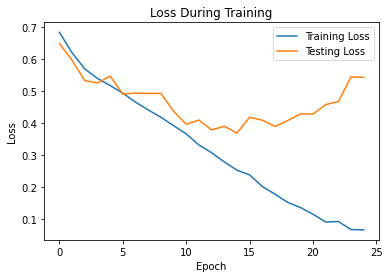

In [10]:
# === Plot the Data === #
plt.plot( history_dict['loss']     , label='Training Loss' )
plt.plot( history_dict['val_loss'] , label='Testing Loss' )

# === Label the Chart === #
plt.xlabel( 'Epoch' )
plt.ylabel( 'Loss' )
plt.title( 'Loss During Training' )
plt.legend( )

# === Display the Chart === #
plt.show( )

## Visualize Accuracy

This next cell shows a plot of the training and validation accuracy for the model (the exact results are saved in a future cell for later processing in another notebook.

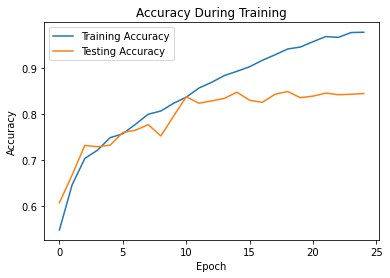

In [11]:
# === Plot the Data === #
plt.plot( history_dict['accuracy']     , label='Training Accuracy' )
plt.plot( history_dict['val_accuracy'] , label='Testing Accuracy'  )

# === Label the Chart === #
plt.xlabel( 'Epoch' )
plt.ylabel( 'Accuracy' )
plt.title( 'Accuracy During Training' )
plt.legend( )

# === Display the Chart === #
plt.show( )

## Save the Model 

Now that the model has been fully trained, we want to save the learned weights in order to be further evaluated later if needed. 

In [12]:
# === Save for Future Evaluation === #
hypermodel.save( 'No_Preprocess_Results/TUNED_vgg19_catvdog_model.h5' )

## Display Runtimes

We will show the measured preprocessing overhead time and the training time of this program in order to gain an understanding of the behavior of this baseline application. These resutls are saved in a future slide for later processing in a different notebook. 

In [13]:
for t in times:
    print( '{}: {}s'.format( t['Event'] , round( t['Time (sec)'] , 4 ) ) )

Load/Process Dataset: 19.5395s
Hyperparameter Tuning: 6361.8466s
Training: 7897.0399s


## Save Time Data

The above data is converted into a pandas DataFrame for saving into a formatted CSV file. This csv file will be used for processing in a different notebook. 

In [14]:
time_data  = {
    'Event': [t['Event'] for t in times],
    'Time (sec)': [t['Time (sec)'] for t in times]
}
time_table = pd.DataFrame( time_data )
time_table.to_csv( 'No_Preprocess_Results/TUNED_vgg19_catvdog_times.csv' , index=False )
time_table.head( )

,Event,Time (sec)
0,Load/Process Dataset,19.539480
1,Hyperparameter Tuning,6361.846556
2,Training,7897.039905


## Save Training/Validation Data

Finally, construct a pandas dataframe of the training loss, validation loss, training accuracy, and validation accuracy at each epoch during training. These values are saved for processing in a different notebook. 

In [15]:
model_data = {
    'Epoch': [i+1 for i in range(25)],
    'Training Accuracy': history_dict['accuracy'],
    'Validation Accuracy': history_dict['val_accuracy'],
    'Training Loss': history_dict['loss'],
    'Validation Loss': history_dict['val_loss']
}
model_table = pd.DataFrame( model_data )
model_table.to_csv( 'No_Preprocess_Results/TUNED_vgg19_catvdog_history.csv' , index=False )
model_table.head( len( model_table ) )

,Epoch,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss
0,1,0.548000,0.6070,0.683342,0.647980
1,2,0.645750,0.6670,0.619100,0.595633
2,3,0.703125,0.7315,0.568665,0.532148
3,4,0.721000,0.7285,0.539179,0.524764
4,5,0.748250,0.7320,0.516827,0.546217
5,6,0.756750,0.7595,0.492763,0.490048
6,7,0.777375,0.7645,0.464975,0.493245
7,8,0.799125,0.7765,0.440585,0.491973
8,9,0.806125,0.7520,0.417699,0.492454
9,10,0.822875,0.7950,0.391406,0.436379
